<font size="5">**Customer Segmentation con k-means**</font><br>

> (c) 2025 Antonio Piemontese

Come prima cosa, **rileviamo l'ambiente di esecuzione del notebook** (Jupyter oppure Google Colab: la cella imposta una variabile booleana `IN_COLAB` che sarà testata da alcune celle del notebook (in particolare quelle di visualizzazione di immagini) per personalizzarne il comportamento a seconda dell'ambiente di esecuzione dell'ambiente rilevato.

In [ ]:
# impostazione del TOGGLE BINARIO:
try:
    import google.colab                      # package disponibile SOLO in Google Colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Siamo in Colab:", IN_COLAB)


# IMPORT dei package necessari per la VISUALIZZAZIONE delle IMMAGINI (necessari sia in JN che in Colab):
from IPython.display import Image, display   # import dei package di incorporamento e visualizzazione immagine (una tantum)
                                             # Image e display sono entrambi necessari a Jupyter Notebook
                                             # Google Colab utilizza solo Image
import os                                    # necessario a Google Colab per vedere da una cella codice
                                             # i contenuti del 'content'

Questo notebook incorpora le seguenti immagini PNG:
- `det_prob.png`
- `clustering_types.png`
- `WSS.png`
- `WSSvsBSS.png`
- `kmeans_iterations.png`
- `KmeansAlgorithm.png`
- `kmeans_inners.png`
- `LocMinvsGlobMin.png`
- `distances_pictures.png`
- `why_not_euclidean_distance.png`
- `why_not_euclidean_distance2.png`
- `Silhouette_score.png`
- `elbow_vs_silhouette.png`
- `Limitations_silhouette_score.png`
- `workflow_complessivo.png`
- `workflow_info.png`
- `kmeans_limits.png`
- `evaluation_incipit.png`
- `evaluation.png`

ed i seguenti file PDF:

- `metrics.pdf`
- `Breathing KMeans vs KMeans.pdf`
- `Intrinsic Measures for Clustering Evaluation.pdf`

# Clustering deterministico vs clustering probabilistico
![](det_prob.png)
Da pillole UniGE.

---
Nel clustering probabilistico **non ci sono filtri decisi dall'utente. La riga è considerata <u>nel suo insieme</u>**. <br>
Il Clustering (k-means, HC, od altro) permette all'attributo discriminativo di agire. **Noi non sappiamo a priori quali siano gli attributi più discriminativi**. Nella segmentazione *manuale* la scelta dell'attributo è invece rigida e guidata dall'utente.<br>

**Algoritmi di clustering**

![](clustering_types.png)

Un ulteriore algoritmo di clustering abbastanza diffuso è il [T-SNE](https://it.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

# La segmentazione cliente con il clustering k-means (non gerarchico)
L'algoritmo *k-means* utilizza metriche di **distanza** (le vedremo) che permettono di **pesare** le singole variabili in modo differente, pur utilizzandole <u>tutte</u> (non possibile nella segmentazione manuale).

La seguente cella permette di eseguire plot di matplotlib in una singola cella

In [1]:
%matplotlib inline      

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import Image                     # per importare in una cella di tipo CODICE un'immagine

In [3]:
# abilitare la Table Of Contents (ToC) - stack overflow 21151450
# The jupyterlab-toc extension adds the ToC as a side panel that can number headings, collapse sections, and be used for 
# navigation. This extension is included by default since JupyterLab 3.0, in older version you can install it with the following
# command (from a conda prompt, which is NOT the DOS shell):
# - pip install jupyter_contrib_nbextensions
# - jupyter contrib nbextension install --user
# - chiudere e riaprire conda
# --> nella home di Jupyter compare ora un quarto tab, da configurare.

Con i big data è importante poter misurare i tempi di esecuzione delle celle; 3 modi:
- `%timeit`: non misura il rendering
- differenza dei tempi (con `time.time`)
- `conda install jupyterlab_execute_time`

In [4]:
!pip install jupyterlab_execute_time

  Using cached jupyterlab_execute_time-3.2.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)
Using cached jupyterlab_execute_time-3.2.0-py3-none-any.whl (527 kB)
Using cached webcolors-24.11.1-py3-none-any.whl (14 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)

   ---------------------------------------- 5/5 [jupyterlab_execute_time]



# Caricare i dati
Il dataset è disponibile su [kaggle](https://www.kaggle.com/datasets/mrmining/online-retail?select=Online+Retail.xlsx).

Si tratta della lista delle **transazioni di acquisto** fatte da un insieme di clienti veri ad un sito inglese di e-commerce (vero).

Il file NON è in terza forma normale: alcune colonne sono relative al prodotto, altre (ridondate) relative al cliente.

In [5]:
df = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail') # 'read_excel' richiede anche il nome del foglio,
                                                                     # a differenza di 'read_csv'.
                                          # tempo di esecuzione: 
                                          # circa 1'15" su laptop Fujitsu con Intel i7 2.20GHz, 8 GB RAM; 
                                          # circa 40" su desktop Intel i5 4.9ghz 12MB cache, 16GB RAM.
            
                                          # Architettura hardware (Windows 10) consigliata per ML:
                                          # - processori i5/i7 (i9 eccessivo);
                                          # - frequenza (ghz) del processore: almeno 4 ghz;
                                          # - consigliabili processori della 11-a generazione (hanno
                                          #   facility per le reti neurali);
                                          # - 6/8 core (molti algoritmi di ML sono parallelizzabili);
                                          # - 12/16 GB RAM;
                                          # - GPU NVIDIA (utilizzata da alcuni software per math o 3D).
                                          # - TSU di Google Colab
              
                                          # Architettura hardware (Apple) consigliata per ML:
                                          # - processori M1;
                                          # - 8 GB RAM unificata.
                        
                                          # La libreria ottimizzata per i chip M1 di Apple sfrutta il nuovo framework ML Compute
                                          # (di Apple), che ha lo scopo di accelerare l'addestramento delle reti neurali 
                                          # impiegando non solo le CPU, ma anche tutte le GPU disponibili.  
                                          # Il nuovo framework ML Compute di Apple è incluso nell’ultimo aggiornamento di macOS,
                                          # Big Sur, e consente agli utenti di TensorFlow di sfruttare tutto il potenziale della
                                          # CPU a 8 core e della GPU a 8 core del chip M1.
                                          
                                          # In generale, non indispensabili per ML (perchè a-specifici):
                                          # - dischi allo stato solido (SSD);
                                          # - scheda grafica avanzata (salvo l'aspetto delle GPU).



Se avete problemi a caricare un file `.xlsx` (il che è abbastanza frequente!), create la versione `.csv` del suddetto file (con tipo file: *CDV (delimitato dal separatore di elenco* e poi:

In [6]:
# df = pd.read_csv(('Online Retail.csv')

In [7]:
df.shape

(541909, 8)

In [8]:
df.head() # --> una fattura può avere diversi prodotti, come si può notare (dataset non normalizzato secondo le Codd NF)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
df.nunique() # il numero di elementi distinti per ogni attributo

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [10]:
# verifichiamo qual è l'indice
df.index # indice di default numerico

RangeIndex(start=0, stop=541909, step=1)

# Pulire / preparare i dati
Prima di segmentare spesso occorre pulire i dati e preparali alla modellazione. 5 passi, in questo caso:
* Eliminare gli ordini cancellati (con quantità negativa o zero);
* Eliminare gli ordini senza CustomerId;
* Eliminare le date incomplete;
* Calcolare il totale riga (dalle colonne 'Quantity' e 'UnitPrice');
* **Raggruppare per cliente (perchè vogliamo fare una segmentazione clienti)**.

## Escludere le righe con Quantity negativa/zero

In [11]:
df.loc[df['Quantity'] <= 0].shape  # 10.000+ record cancellati (quantità negativa o zero)

(10624, 8)

In [12]:
df.shape                           # dimensioni totali (già viste prima, qui nuovamente riportate per comodità)

(541909, 8)

In [13]:
df = df.loc[df['Quantity'] > 0]    # sovrascrittura dei soli record con quantità positiva

In [14]:
df.shape

(531285, 8)

## Escludere le righe con CustomerID mancante

In [15]:
pd.isnull(df['CustomerID']).sum()

np.int64(133361)

In [16]:
df = df[pd.notnull(df['CustomerID'])]

In [17]:
df.shape

(397924, 8)

## Escludere le righe con mese incompleto
Il dataset ha alcune date incomplete nel mese di dicembre 2011.

In [18]:
print('Date Range: %s ~ %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max())) # stampa il range delle date;
                                                                                  # argomenti: formato, valore min, valore max.

Date Range: 2010-12-01 08:26:00 ~ 2011-12-09 12:50:00


In [19]:
df.loc[df['InvoiceDate'] >= '2011-12-01'].shape # le date potenzialmente errate.

(17304, 8)

In [20]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']   # sovrascrittura dei soli record con data corretta

In [21]:
df.shape

(380620, 8)

## Calcolare i totali di riga

In [22]:
df['Sales'] = df['Quantity'] * df['UnitPrice']  # creazione di una nuova colonna (in coda) per ogni record.
# Nel ML le righe del dataset sono in genere chiamate: osservazioni, casi, unità statistiche, punti (non 'record').
# Le colonne sono in genere chiamate: colonne, attributi, feature, variabili, dimensioni, predittori, regressori, ecc.

In [23]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


## Aggregare i dati per *CustomerId*
**Per segmentare i clienti, occorre prima trasformare il dataset (di transazioni di acquisto) raggruppando i dati per cliente. <br>
3 passi.**

In [24]:
# 1) raggruppamento per 'CustomerID' su due attributi: Sales e InvoiceNo:
customer_df = df.groupby('CustomerID').agg({   # in Python c'è la consuetudine di usare "_" nei nomi delle variabili. In R, ".".
                                               # .agg è il metodo pandas per definire quali funzioni di aggregazione eseguire
                                               # su ogni raggruppamento individuato dalla 'groupby'.
    'Sales': 'sum',
    'InvoiceNo': lambda x: x.nunique()         # le funzioni 'lambda', in Python come in altri linguaggi (jAVA, C#, C++, ecc),
                                               # si basano sul lambda calcolo, ed hanno una sintassi più restrittiva ma 
                                               # particolarmente concisa, a differenza delle funzioni regolari (macchina di 
                                               # Turing a stati: funzioni imperative).
})

customer_df.head()

,Sales,InvoiceNo
CustomerID,,
12346.0,77183.60,1
12347.0,4085.18,6
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


Come si vede, la `groupyby` ha creato un indice su `CustomerID`: La seguente utility individua quale è l'indice di un (generico) dataframe:

In [25]:
def index_info(df):
    print("Index Type:", type(df.index))
    print("Index Name:", df.index.name)
    if df.index.name in df.columns:
        print(f"The index comes from column: {df.index.name}")
    else:
        print("The index is not a named column (maybe autogenerated or anonymous).")
index:index_info(customer_df)

Index Type: <class 'pandas.core.indexes.base.Index'>
Index Name: CustomerID
The index is not a named column (maybe autogenerated or anonymous).


In [26]:
# 2)
customer_df.columns = ['TotalSales', 'OrderCount']  # i due attributi (colonne) vengono rinominate più correttamente.
                                                    # NB. Nel passo 1) ciò non era possibile, perchè i nomi degli attributi
                                                    # della funzione 'groupby' e del metodo 'agg' debbono essere quelli del
                                                    # dataset originario.
customer_df.head()

,TotalSales,OrderCount
CustomerID,,
12346.0,77183.60,1
12347.0,4085.18,6
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


In [27]:
customer_df.shape

(4298, 2)

In [28]:
# 3) creazione di un terzo attributo
customer_df['AvgOrderValue'] = customer_df['TotalSales']/customer_df['OrderCount']

In [29]:
customer_df.shape

(4298, 3)

---
Questo piccolo dataset clienti ci serve per imparare il funzionamento del clustering con il kmeans. Nella secondsa parte del notebook, applicheremo il k-means ad un big dataset di 1.000.000 di clienti. 

---

In [30]:
customer_df.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


In [31]:
customer_df.describe() # la distribuzione dei tre attributi: numero, media, deviazione standard (la radice quadrata della 
                       # varianza), min, max, i tre quantili al 25%, 50% e 75%. 
                       # Il quantile al 50% è anche chiamato 'mediana'.
                       # --> poichè la std (standard deviation) è differente tra le colonne, per applicare correttamente
                       # il clustering (di qualsiasi tipo, cioè k-means e HC) occorre pre-standardizzare i dati.

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4298.000000
mean,1952.818779,4.131689,400.255621
std,8354.913254,7.420253,1271.187289
min,0.000000,1.000000,0.000000
25%,304.305000,1.000000,178.602500
50%,657.265000,2.000000,295.033958
75%,1599.515000,4.000000,431.594250
max,268478.000000,201.000000,77183.600000


In [32]:
customer_df['TotalSales'].median()  # La mediana (= quantile al 50%).
                                    # E' una misura 'robusta' perchè meno sensibile della media agli outlier.

657.265

**Mediana vs media (esempio)**

In [33]:
sr = pd.Series([10,25,3,11,24,6,1800])
index_ = ['Coca Cola','Sprite','Fanta','Liquore','Caffè','Thè','Cappuccino']
sr.index = index_
print(sr.mean())
print(sr.sort_values())
print(sr.median())

268.42857142857144
Fanta            3
Thè              6
Coca Cola       10
Liquore         11
Caffè           24
Sprite          25
Cappuccino    1800
dtype: int64
11.0


In [34]:
# Per ordinare il nostro dataset ridotto:
customer_df.sort_values(by='TotalSales')

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
13256.0,0.00,1,0.000000
16446.0,2.90,1,2.900000
16738.0,3.75,1,3.750000
14792.0,6.20,1,6.200000
16454.0,6.90,2,3.450000
...,...,...,...
12415.0,124914.53,21,5948.310952
14911.0,136846.14,192,712.740313
17450.0,192988.39,45,4288.630889


In [35]:
# Come mai un cliente con TotalSales = 0? Non erano stati esclusi??
df[df['CustomerID']==13256] # NON escluso prima perchè qui Quantity>0. Ma UnitPrice=0 --> Sales e poi TotalSales = 0!

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,0.0


In [36]:
# Un altro possibile ordinamento:
customer_df.sort_values(by='OrderCount')

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
18240.0,422.58,1,422.580000
18249.0,95.34,1,95.340000
18250.0,349.27,1,349.270000
18251.0,4314.72,1,4314.720000
18255.0,103.30,1,103.300000
...,...,...,...
14606.0,11800.94,91,129.680659
13089.0,54144.21,93,582.195806
17841.0,38435.26,120,320.293833


## *Ranking* e Standardizzazione
Come facilmente visibile dalle statistiche fornite dal metodo *describe* di sopra, i tre attributi hanno scale (*std*) molto differenti. Gli algoritmi di clustering hanno bisogno che gli attributi siano espressi nella stessa scala, **in particolare il k_means**. Serve 
la standardizzazione.<br><br>
Inoltre, è spesso meglio esprimere i dati come POSIZIONE ("rank") all'interno del dataset, anzichè come VALORE.<br>
Infatti **noi vogliamo segmentare e dunque ci interessano le posizioni di un cliente rispetto agli altri e non i suoi valori 
in assoluto**.

Per familiarizzare con il ranking vediamo un esempio su una 'Series' di pandas, A PRESCINDERE dal nostro dataset:

In [37]:
sr = pd.Series([10,25,3,11,24,60,87])
index_ = ['Coca Cola','Sprite','Fanta','Liquore','Caffè','Thè','Cappuccino']
sr.index = index_
print(sr)
result = sr.rank(ascending=True)
print("\n")   # salta riga
print(result) # attenzione: senza 'print' è visualizzato solo l'ultimo output.
print(sr.median()) # --> attenzione, la mediana è il valore del vettore (colonna del df) con tanti valori maggiori
                   #     quanti sono i valori minori. Il rank è la posizione del valore singolo rispetto a tutti gli altri.
                   #     OGNI riga ha il suo rank, solo UNA riga è la mediana.

Coca Cola     10
Sprite        25
Fanta          3
Liquore       11
Caffè         24
Thè           60
Cappuccino    87
dtype: int64


Coca Cola     2.0
Sprite        5.0
Fanta         1.0
Liquore       3.0
Caffè         4.0
Thè           6.0
Cappuccino    7.0
dtype: float64
24.0


Il rank NON è l'ordinamento, ma la **posizione** rispetto a TUTTI gli elementi del vettore considerato. Non confondere!

In [38]:
# Per ordinare la serie di prima:
print(sr.sort_values())

Fanta          3
Coca Cola     10
Liquore       11
Caffè         24
Sprite        25
Thè           60
Cappuccino    87
dtype: int64


---
**Il metodo `.rank()` può essere utile quando**:
- Le variabili hanno scale troppo diverse o outlier che distorcono la media o la varianza.
- Si vuole dare importanza all'ordine dei valori e non al valore assoluto (es: un cliente con spesa 1000 o 2000 ha stessa posizione se sono rispettivamente il 1° e 2° più alto)
- le distribuzioni sono non gaussiane, asimmetriche, o con code lunghe.

---

Ora **torniamo al nostro dataset**:

In [39]:
# ed ora il ranking del nostro dataset ridotto:
rank_df = customer_df.rank(method='first')  # l'argomento 'method':
                                            # dall'help on-line: "How to rank the group of records that have the same 
                                            # value (i.e. ties)        

Il metodo migliore per gestire i **ties** (valori a pari merito) con `rank()` dipende dallo scopo dell'analisi. Ecco una panoramica dei principali metodi disponibili nel parametro `method`:

✅ 1. **"average" (default)**<br>
Assegna ai valori a pari merito il rank medio tra le posizioni.
```python
s = pd.Series([100, 100, 50])
s.rank(method="average")
```
Output: [2.5, 2.5, 1.0]

👉 Quando usarlo: è la scelta migliore per **analisi statistiche**, come quando si calcola la correlazione tra ranghi (es. Spearman).

✅ 2. **"min"**<br>
Assegna ai valori a pari merito il rank più basso (più favorevole).
```python
s.rank(method="min")
```

Output: [2.0, 2.0, 1.0]

👉 Quando usarlo: utile per classifiche dove conta arrivare **prima**, come in gare sportive.

✅ 3. **"max"**<br>
Assegna il rank più alto (meno favorevole) a tutti i pari merito.
```python
s.rank(method="max")
```

Output: [3.0, 3.0, 1.0]

👉 Quando usarlo: quando vuoi considerare i pari merito come se occupassero l’ultima posizione utile.

✅ 4. **"first"**<br>
Assegna il rank in base all’ordine in cui appaiono nella serie.
```python
s.rank(method="first")
```
Output: [2.0, 3.0, 1.0]

👉 Quando usarlo: per esigenze dove **l’ordine originale è importante**, ad esempio flussi di dati temporali.

✅ 5. **"dense"**<br>
Come "min", ma non salta i rank successivi.
```python
s = pd.Series([100, 100, 50, 30])
s.rank(method="dense")
```
Output: [2.0, 2.0, 1.0, 3.0]

👉 Quando usarlo: utile per classificazioni **“compatte”** (es. medaglie oro/argento/bronzo).

**In sintesi: quale scegliere?**<br>
- Analisi statistica (es. Spearman)	--> "average"
- Gare e classifiche --> "min"
- Premi o posizioni limitate --> "max"
- Ordine di arrivo	-->  "first"
- Classifiche compatte senza buchi	--> "dense"


In [40]:
rank_df.head(15)    # --> sono POSIZIONI (non valori)
                    # le posizioni di ogni attributo vanno da 1 a 4298.
          
                    # Notare l'effetto dell'argomento 'method': alle varie osservazioni con 'OrderCount' = 1 (molte!)
                    # sono assegnati rank crescenti! Cioè, ad esempio, ai clienti 12346, 12349 e 12350, che hanno tutti e
                    # tre 'OrderCount' = 1, sono assegnati rank crescenti (1 --> 2 --> 3). In questo modo tutti gli
                    # attributi hanno rank massimo = 4298 (il numero di osservazioni).
                    
                    # nota estetica: 'print' in questo caso produrrebbe un output meno gradevole (dipende dai casi)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12347.0,3958.0,3470.0,3888.0
12348.0,3350.0,2861.0,3303.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
12352.0,3630.0,3774.0,2360.0
12353.0,119.0,4.0,201.0
12354.0,2781.0,5.0,4151.0
12355.0,1670.0,6.0,3354.0


In [41]:
rank_df.tail(15)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
18265.0,2420.0,2343.0,3046.0
18268.0,16.0,1531.0,19.0
18269.0,515.0,1532.0,963.0
18270.0,982.0,2344.0,650.0
18272.0,3692.0,3469.0,3633.0
18273.0,422.0,2345.0,152.0
18274.0,548.0,1533.0,1037.0
18276.0,1247.0,1534.0,2572.0
18277.0,204.0,1535.0,347.0


In [42]:
rank_df.sample(30)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
17839.0,1259.0,1405.0,2601.0
12362.0,4016.0,3871.0,3578.0
17133.0,4033.0,3745.0,3901.0
14823.0,1179.0,2552.0,316.0
13520.0,3883.0,3505.0,3757.0
15270.0,3594.0,3695.0,2611.0
13712.0,791.0,362.0,1614.0
16833.0,2188.0,2733.0,1559.0
13113.0,4224.0,4229.0,3560.0


In [43]:
rank_df.shape  # stesse dimensioni, ma ogni elemento è una posizione (nella singola colonna presa a se stante),
               # anzichè un valore

(4298, 3)

---
Poichè le celle del dataframe `rank_df` sono POSIZIONI e non valori, nessuna cella in questo caso può superare 4298 (il numero di righe del dataset).

---

In [44]:
# Poichè il CustomerID 12346 aveva un TotalSales tra i più alti, gli è assegnata la POSIZIONE 4290 (molto vicino a 4298,
# che è il numero totale dei clienti nel dataframe).
customer_df.head(20)                # --> VALORI (non posizioni), come check.
                                    #     qui, tra i primi 20 il Customer ID 12346 ha il TotalSales più alto, in effetti.



,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
12352.0,2506.04,8,313.255000
12353.0,89.00,1,89.000000
12354.0,1079.40,1,1079.400000
12355.0,459.40,1,459.400000


In [45]:
customer_df.corr()

,TotalSales,OrderCount,AvgOrderValue
TotalSales,1.000000,0.575523,0.292106
OrderCount,0.575523,1.000000,0.031715
AvgOrderValue,0.292106,0.031715,1.000000


Non ci sono correlazioni interessanti (cioè superiori a |0.7|)

In [46]:
import numpy as np
np.linalg.matrix_rank(customer_df)

np.int64(3)

In [47]:
# è possibile ordinare le POSIZIONI:
rank_df.sort_values(by='OrderCount') 

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
12353.0,119.0,4.0,201.0
12354.0,2781.0,5.0,4151.0
...,...,...,...
14606.0,4223.0,4294.0,533.0
13089.0,4284.0,4295.0,3714.0
17841.0,4276.0,4296.0,2428.0


Ora dobbiamo eseguire il secondo passo: la standardizzazione dei dati (valori o posizioni che siano)

In [48]:
rank_df.mean()

TotalSales       2149.5
OrderCount       2149.5
AvgOrderValue    2149.5
dtype: float64

Dopo il ranking le feature sono ancora su scale diverse. La standardizzazione (`StandardScaler`) riporta tutto a media 0 e varianza 1, rendendo le feature comparabili nel calcolo della distanza euclidea, quella usata dal `KMeans`.

Facciamo la standardizzazione a mano, per capirla meglio.

In [49]:
# ed ora standardizziamo i dati (aka, normalizzazione) - esistono anche delle funzioni di scikit-learn:
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()    # funzionamento vettoriale (ogni colonna è gestita in modo independente)

In [50]:
normalized_df.head(15) # --> la standardizzazione è fattibile per qualsiasi dato NUMERICO, quindi sia con i VALORI che 
                       #     con le POSIZIONI.

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
12352.0,1.193114,1.309162,0.169639
12353.0,-1.636352,-1.729029,-1.570269
12354.0,0.508917,-1.728223,1.612981
12355.0,-0.386422,-1.727417,0.970690


I dati ora variano tra -6 e +6 per tutte le colonne.<br>
La standardizzazione si può fare (meglio) con la funzione `StandardScaler` del modulo `preprocessing` di *scikit-learn*. Vedi [qui](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).<br>
Facciamo anche la standardizzazione del dataframe originale (valori e non posizioni).

In [51]:
customer_df = (customer_df - customer_df.mean()) / customer_df.std() # la standardizzazione sui VALORI (di tutte le righe)
customer_df.head(15)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,9.004376,-0.422046,60.402857
12347.0,0.255222,0.251785,0.220745
12348.0,-0.018621,-0.017747,0.038589
12349.0,-0.023372,-0.422046,1.067738
12350.0,-0.193709,-0.422046,-0.051806
12352.0,0.066215,0.521318,-0.068440
12353.0,-0.223081,-0.422046,-0.244854
12354.0,-0.104540,-0.422046,0.534260
12355.0,-0.178747,-0.422046,0.046527


In [52]:
normalized_df.describe() # --> le POSIZIONI sono centrate intorno a 0 e soprattutto le std sono 1, ora!
                         #     Ora siamo pronti a segmentare.

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4.298000e+03
mean,0.000000,0.000000,-6.612776e-18
std,1.000000,1.000000,1.000000e+00
min,-1.731446,-1.731446,-1.731446e+00
25%,-0.865723,-0.865723,-8.657232e-01
50%,0.000000,0.000000,0.000000e+00
75%,0.865723,0.865723,8.657232e-01
max,1.731446,1.731446,1.731446e+00


# La Segmentazione Cliente con il clustering K-Means 

Clustering refers to a very broad set of techniques for finding subgroups, or clustering clusters, in a data set. When we cluster the observations of a data set, we seek to **<u>partition</u>** them into distinct groups so that **the observations within each group are quite similar to each other, while observations in different groups are quite different from each other**. Of course, to make this concrete, we must define what it means for two or more observations to be similar or different (the so-called ***distance***). Indeed, this is often a domain-specific consideration that must be made based on knowledge of the data being studied.

The goal in customer segmentation is to identify subgroups of people who might be <u>more receptive to a particular form of advertising, or more likely to purchase a particular product</u>. [Questa è una **assunzione**, spesso vera]. The task of performing customer segmentation amounts to clustering the people in the data set.

Since clustering is popular in many fields, there exist a great number of clustering methods. The two best-known clustering approaches are</u>: **K-means clustering** and **hierarchical clustering**.<br><br>
In K-means clustering, we seek to partition the observations into a <u>pre-specified number of clusters</u>. On the other hand, in hierarchical clustering, we <u>do not know in advance</u> how many clusters we want; in fact, we end up with a tree-like visual representation of the observations, called a **dendrogram**, that allows us to view at once the clusterings obtained for each possible number of clusters, from 1 to n.<br><br> There are **advantages and disadvantages** to each of these clustering approaches. 

*James, Gareth; Witten, Daniela; Hastie, Trevor; Tibshirani, Robert. An Introduction to Statistical Learning: with Applications in R (Springer Texts in Statistics)* 

E se ci sono anche nel dataframe delle variabili **categoriche** (ad es. la regione del cliente) che vogliamo siano considerate dalla segmentazione?
* La standardizzazione ed il ranking hanno senso SOLO per le variabili numeriche; teniamo la variabile categorica così com'è;
* esistono tipi di distanze tra osservazioni (le vedremo tra poco) che calcolano la distanza tenendo conto sia delle variabili numeriche che di quelle categoriche.

[Il Clustering in scikit-learn](https://scikit-learn.org/stable/modules/clustering.html)<br>
[La funzione KMeans di scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [53]:
from sklearn.cluster import KMeans   # import del modulo di kmeans da scikit_learn.

## K-Means Clustering [Nota matematica facoltativa]
K-means clustering is a simple and elegant approach for <u>partitioning</u> a data set into **K distinct, non-overlapping clusters**. 

[Cos'è un partizionamento in matematica](https://it.wikipedia.org/wiki/Partizione_(teoria_degli_insiemi)#:~:text=In%20matematica%20una%20partizione%20di,%22coprono%22%20X%20senza%20sovrapporsi.&text=dati%20due%20sottoinsiemi%20(distinti)%20qualsiasi,di%20X%2C%20questi%20sono%20disgiunti.)<br>
[Un esempio di partizionamento](https://www.google.com/search?q=partizionamento&rlz=1C2WPZC_enIT808IT808&sxsrf=AOaemvKnkeeYdX2yV4gRuOwAVikij_BZrQ:1632684189067&source=lnms&tbm=isch&sa=X&ved=2ahUKEwia4_nIrp3zAhVJhv0HHYukCa0Q_AUoBHoECAEQBg&biw=1536&bih=722&dpr=1.25#imgrc=N6YwgLO4HuyrcM)

The K-means clustering procedure results from a simple and intuitive mathematical problem. We begin by defining some notation. Let C1,...,CK denote sets containing the indices of the observations in each cluster. These sets satisfy two properties:<br>
* C1 ∪ C2 ∪... ∪ CK = {1,...,n}. In other words, each observation belongs to at least one of the K clusters.<br>
* Ck ∩ Ck' = ∅ for all k != k'. In other words, the clusters are nonoverlapping: no observation belongs to more than one cluster.

The idea behind K-means clustering is that a good clustering is one for which **the within-cluster variation is as small as possible.** The within-cluster variation for cluster k is a measure of the amount by which the observations within a cluster differ from each other.

We want to partition the observations into K clusters such that the **total within-cluster variation, summed over all K clusters, is as small as possible.**

We need to define the within-cluster variation. There are many possible ways to define this concept, but by far the most common choice involves squared **Euclidean distance**. 
[Definizione di Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance) 

[Ecco la formula della WSS-j del k-means](WSS.png) dove mu-j è il vettore delle medie campionarie del cluster j.

For this reason, within-cluster variation is usually named **Within Sum-of-Squares (WSS)**.

(Minimizing Total WSS implies maximizing BSS (Between Sum of Squares). [WSS vs BSS](WSSvsBSS.png)

To perform K-means clustering, we must first specify the desired number of clusters K; then the K-means algorithm will assign each observation to exactly one of the K clusters.

*James, Gareth; Witten, Daniela; Hastie, Trevor; Tibshirani, Robert. An Introduction to Statistical Learning: with Applications in R (Springer Texts in Statistics)* 

In scikit-learn la prima cosa da fare è sempre l'istanziazione dell'algoritmo. Poi il fit, qui in cascata:

In [54]:
import time
start_time = time.time() # adesso

kmeans = KMeans(n_clusters=4,random_state=1).fit(normalized_df)
                           # specifica nostra del numero di cluster;
                           # se è necessario avere la stessa generazione iniziale dei centroidi, usare 'random_state=k';
                           # fit dei dati di training.
                           # --> produce un MODELLO di CLUSTERING (kmeans), applicabile poi anche ad altri dati!

end_time = time.time()
tempo_exec = round(end_time - start_time,2)

print("Il tempo impiegato è stato di secondi: ", tempo_exec)

Il tempo impiegato è stato di secondi:  0.16


Perchè la funzione *KMeans()* usa sempre la distanza euclidea? (ed infatti non ha l'argomento *distance*). [La risposta](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric)<br>
Anche Orange fa così.

In [55]:
type(kmeans)  # La classe dell'oggetto creato 

sklearn.cluster._kmeans.KMeans

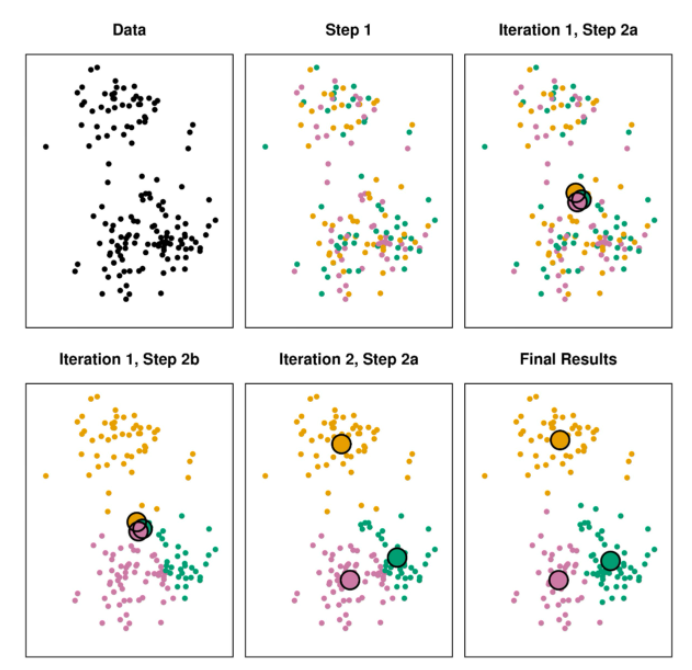

In [56]:
Image(filename='kmeans_iterations.png', width=600)
                                                      # --> step 1: assegna casualmente un cluster ad ogni istanza, con K=3.
    
                                                      #     iterazione 1, step 2a: calcola i centroidi dei tre cluster,
                                                      #     in genere vicini tra loro (in questa prima iterazione)
            
                                                      #     iterazione 1, step 2b: riassegna i cluster alle varie istanze
                                                      #     (quello il cui centroide è il meno distante dall'istanza stessa)
                    
                                                      #     iterazione 2, step 2a: calcola nuovamente i centroidi dei tre
                                                      #     cluster
                            
                                                      #     ecc .... sino al risultato finale (convergenza raggiunta)

![](kmeans_inners.png)

In [57]:
# La funzione 'KMeans', oltre a produrre l'oggetto visto (il modello), memorizza le LABEL (il numero del cluster per ogni 
# osservazione) ed i CENTROIDI (mean vectors) di ogni cluster nei due oggetti seguenti, che sono accessibili direttamente:

In [58]:
print(type(kmeans.labels_)) # --> 'ndarray' è un datatype multi-dimensionale, qui vettoriale (non è Pandas)
print(len(kmeans.labels_))
print(kmeans.labels_)
print(kmeans.labels_[2])    # il terzo elemento (python conta da 0)
print(kmeans.labels_[0:3])  # i primi tre elementi (3 è escluso)

<class 'numpy.ndarray'>
4298
[3 1 1 ... 0 2 1]
1
[3 1 1]


In [59]:
kmeans.labels_

array([3, 1, 1, ..., 0, 2, 1], dtype=int32)

In [60]:
# ed ora le coordinate dei CENTROIDI (mean vector) di ogni cluster:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=normalized_df.columns) 
                               # In 3+ dimensioni è comune il suffisso 'oide': centroide, paraboloide, ellissoide, ecc
                               # anzichè: centro, parabola, ellissi, come consueto in due dimensioni.
                               # Per i più precisi: in fisica il centroide corrisponde al centro di gravità (o baricentro) solo
                               # se il corpo è omogeneo.
                
                               # --> anche le coordinate (componenti del vettore) dei centroidi sono ovviamente
                               # per POSIZIONE e STANDARDIZZATA.
                        
# pd.set_option('precision',3)
centroids

,TotalSales,OrderCount,AvgOrderValue
0,-1.248156,-0.799846,-1.061792
1,1.207247,1.008547,0.865115
2,0.212752,0.710973,-0.643203
3,-0.130887,-0.848854,0.799777


In [61]:
# calcolare la distanza di ogni osservazione dai centroidi di classe:
distances = kmeans.transform(normalized_df) 

# trovare il cluster più vicino ad ogni osservazione (min distance): 
minSquaredDistances = distances.min(axis=1)**2 

# combinare in un unico dataframe le min distance e le etichette dei cluster: 
df = pd.DataFrame({'squaredDistance': minSquaredDistances, 'cluster': kmeans.labels_}, 
                  index = normalized_df.index) 

# raggruppare per cluster e visualizzare: 
for cluster, data in df.groupby('cluster'): 
    count = len( data) 
    withinClustSS = data.squaredDistance.sum() 
    print(f'Cluster {cluster} ({count} members): {withinClustSS:.2f} within cluster ')

Cluster 0 (1148 members): 722.03 within cluster 
Cluster 1 (1133 members): 742.14 within cluster 
Cluster 2 (954 members): 694.15 within cluster 
Cluster 3 (1063 members): 885.74 within cluster 


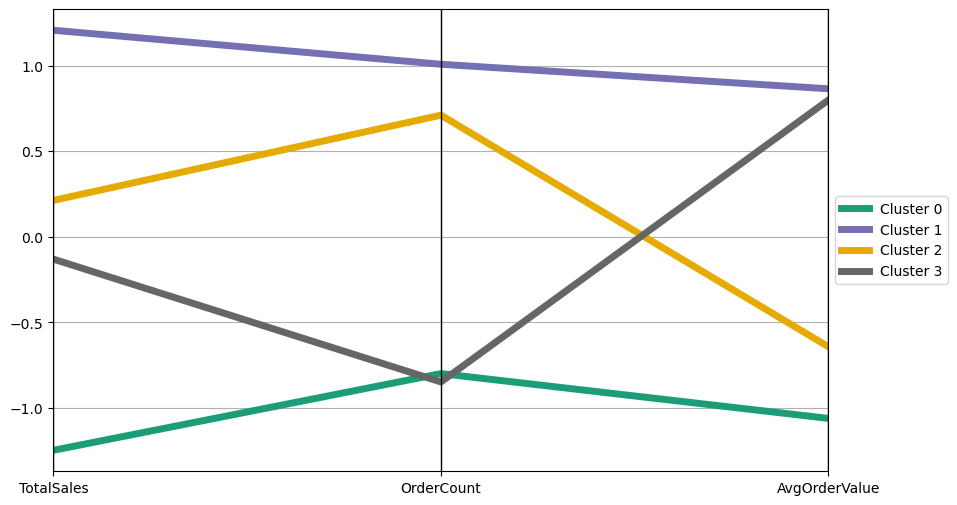

In [62]:
# il cosiddetto 'profile plot', cioè la rappresentazione grafica dei centroidi dei cluster:
centroids['cluster'] = ['Cluster {}'. format( i) for i in centroids.index] 
plt.figure(figsize =(10,6)) 
pd.plotting.parallel_coordinates(centroids, class_column ='cluster', colormap ='Dark2', linewidth = 5) 
plt.legend(loc ='center left', bbox_to_anchor =( 1, 0.5))
plt.show()

In [63]:
# Ora esaminiamo i cluster assegnati alle varie osservazioni:
four_cluster_df = normalized_df.copy(deep=True) 
                                            # copia del dataframe (dati ed indici) per valore anzichè per referenza (deep=False)
four_cluster_df['Cluster'] = kmeans.labels_ # salva le label di ogni riga (il cluster al quale la riga è stata
                                            # assegnata) in una quarta colonna.
four_cluster_df.head(20)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,3
12347.0,1.457445,1.064173,1.401033,1
12348.0,0.967466,0.573388,0.929590,1
12349.0,0.944096,-1.730641,1.683093,3
12350.0,-0.732148,-1.729835,0.331622,3
12352.0,1.193114,1.309162,0.169639,1
12353.0,-1.636352,-1.729029,-1.570269,0
12354.0,0.508917,-1.728223,1.612981,3
12355.0,-0.386422,-1.727417,0.970690,3


In [64]:
# le cardinalità di ogni cluster:
four_cluster_df.groupby('Cluster').count()['TotalSales'] # --> 1171 + 935 + 1126 + 1066 = 4298.
                                                         # Il subsetting finale elimina info ridondanti.

Cluster
0    1148
1    1133
2     954
3    1063
Name: TotalSales, dtype: int64

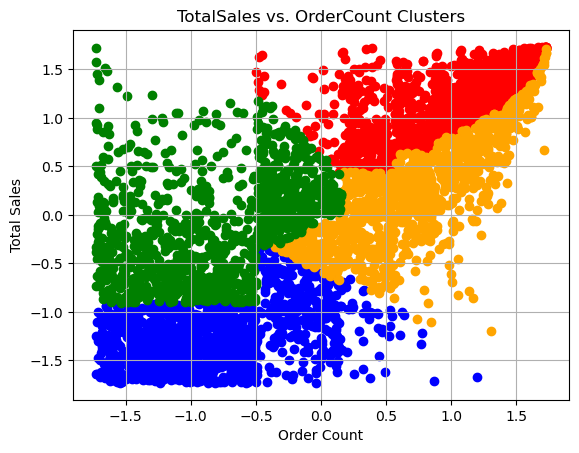

In [65]:
# e visualizziamo i cluster graficamente secondo le due dimensioni OrderCount e TotalSales:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c='green'
)

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

In [66]:
# Si arriva qui alla INTERPRETAZIONE business (applicativa) del risultato.
# Cosa vediamo?
# Il cluster in arancione è quello dei clienti di "basso valore" (non hanno comprato molto i nostri prodotti).
# Il cluster in rosso è quello dei clienti "di alto valore" (hanno comprato molto e spesso).
# Gli altri cluster sono meno interessanti (K=4 è stato scelto a priori).
# La visualizzazione aiuta molto.

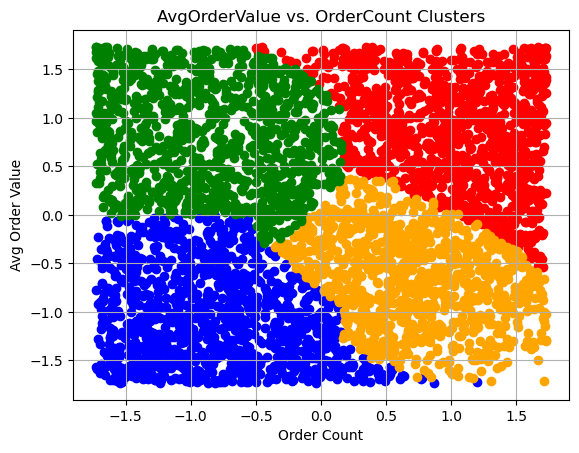

In [67]:
# Ovviamente, con TRE attributi del dataset, possiamo scegliere altre due coppie per la visualizzazione:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green'
)

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

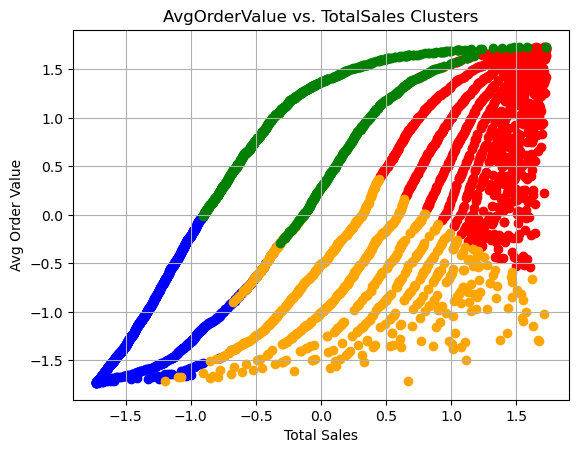

In [68]:
# ed infine:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green'
)

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

## La funzione obiettivo del k-means [Nota matematica facoltativa]
L'algoritmo k-means minimizza una funzione obiettivo così definita:<br><br>
minimize **Sum [j=1..K] WSS-j**<br>
C1, C2,..CK<br><br>
E' un problema di ottimizzazione molto difficile da risolvere in modo esatto (perchè WSS non è convessa ancorchè sia quadratica) se p (il numero di attributi del dataset) è anche solo medio (qualche decina). Fortunatamente, c'è un semplice algoritmo **iterativo** che permette di trovare delle soluzioni approssimate. [Eccolo](KmeansAlgorithm.png).<br><br>
Questo algoritmo trova un minimo locale, che non necessariamente, in funzioni non-convesse, corrisponde al minimo globale.
[Minimo locale vs minimo globale](LocMinvsGlobMin.png). Questa è la ragione dell'argomento *max_iter* di *KMeans*.<br><br>
K-means è così computazionalmente più performante del clustering gerarchico.

## Le distanze
Per variabili numeriche si può usare la distanza euclidea.<br>
Per variabili categoriche ci sono distanze apposite (ad es. [Jaccard](https://it.wikipedia.org/wiki/Indice_di_Jaccard)), e così per mix di variabili (numeriche e categoriche) (ad esempio [Gower](https://stats.stackexchange.com/questions/15287/hierarchical-clustering-with-mixed-type-data-what-distance-similarity-to-use/15313#15313)).<br>
Vediamo qui sotto un **confronto grafico** tra le principali distanze:<br>
![](distances_pictures.png)<br>
Dal post di Linkedin:<br>
Un bel riassunto delle misure di distanza, ha coperto alcune delle principali negli algoritmi di ML:
1) Euclideo: misura la distanza in linea retta tra due punti in uno spazio multidimensionale, comunemente usato negli algoritmi di clustering e di nearest neighbor.
2) Coseno: calcola il coseno dell'angolo tra due vettori per misurarne la somiglianza, spesso utilizzato nei sistemi di text mining e di raccomandazione.

3) Hamming: determina la dissomiglianza tra due stringhe di uguale lunghezza contando i diversi elementi, comunemente utilizzati nel rilevamento degli errori e nell'analisi della somiglianza dei documenti.

4) Manhattan: calcola la somma delle differenze assolute tra le coordinate corrispondenti di due punti, adatto per applicazioni come l'analisi di rete e l'elaborazione delle immagini.

5) Minkowski: una misura di distanza generalizzata che comprende sia le distanze euclidee che quelle di Manhattan, offrendo flessibilità attraverso un parametro che controlla il grado di somiglianza.

6) Chebyshev: misura la differenza massima tra le coordinate corrispondenti di due punti, adatto per scenari in cui la distanza massima è cruciale, come negli algoritmi di gioco.

7) Jaccard: calcola la dissomiglianza tra due insiemi confrontando la loro intersezione con la loro unione, comunemente utilizzata nei sistemi di data mining e di raccomandazione.

8) Haversine: calcola la distanza tra due punti su una sfera, in genere utilizzata nelle applicazioni di analisi geospaziale e navigazione.

9) Dice di Sorensen: determina la dissomiglianza tra due insiemi confrontando la loro intersezione con la somma delle loro cardinalità, spesso utilizzata nel text mining e nell'analisi delle sequenze biologiche.

Queste misure di distanza svolgono un ruolo fondamentale in varie attività di apprendimento automatico, aiutando nell'analisi dei dati, nel riconoscimento dei modelli e nelle valutazioni di somiglianza.


**Quando la distanza euclidea non va bene?** Ecco un esempio commentato:<br>
![](why_not_euclidean_distance2.png)<br>
![](why_not_euclidean_distance.png)<br>

Su "Distanza Euclidea vs Distanza di Mahalanobis" vedi anche la **newsletter di DDoDS** del 21.12.2024 (nella cartella *newsletters*).

## Selezionare il numero di cluster "migliore"
Spesso, come nel caso di prima, non sappiamo in anticipo quale numero di cluster sia il migliore. Si può allora usare il **silhouette score**<br> che misura, A POSTERIORI, <u>quanto vicine le varie osservazioni siano ai loro rispettivi cluster ai quali sono stati assegnati dall'algoritmo</u>. Per ogni numero di cluster ipotizzato si calcola: <br><br>
***S = (b-a) / max (a,b)***<br><br>
dove:<br> 
* b è la media della distanza tra un'osservazione ed il suo cluster più vicino;
* a è la distanza media tra le osservazioni dello stesso cluster.<br>

Il Silhouette score assume valori tra **-1 ed 1**: più il suo valore è vicino a 1, migliore è la suddivisione dei dati fornita da <u>quel numero</u> di cluster.

In [69]:
from sklearn.metrics import silhouette_score  # import della funzione scikit-learn

In [70]:
# sperimentiamo sette differenti numeri di cluster.
# [la cella è in esecuzione sintantochè le quadre a sinistra della cella contengono '*' e non il numero di esecuzione.]
distortions = []
for n_cluster in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(normalized_df) # il fit del modello di clustering sui dati;
                                                             # come prima, è fatto sul dataframe 'normalized_df'.
    silhouette_avg = silhouette_score(normalized_df,kmeans.labels_)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))
    distortions.append(kmeans.inertia_) # inertia sono le SS (preferibili per la curva a gomito?!)


Silhouette Score for 2 Clusters: 0.4288
Silhouette Score for 3 Clusters: 0.3653
Silhouette Score for 4 Clusters: 0.4117
Silhouette Score for 5 Clusters: 0.3829
Silhouette Score for 6 Clusters: 0.3806
Silhouette Score for 7 Clusters: 0.3780
Silhouette Score for 8 Clusters: 0.3732


In [71]:
type(distortions)
distortions

[6436.979447269447,
 4904.607558798299,
 3044.051547120627,
 2567.2282780574296,
 2094.8987907160454,
 1774.0269739317882,
 1574.9225742422682]

Il miglior numero di cluster, quello che meglio suddivide i dati, è 2, come avevamo intuito già dal primo scatter plot.<br>
C'è comunque da notare che gli score delle sette sette suddivisioni sono molto vicini tra loro.

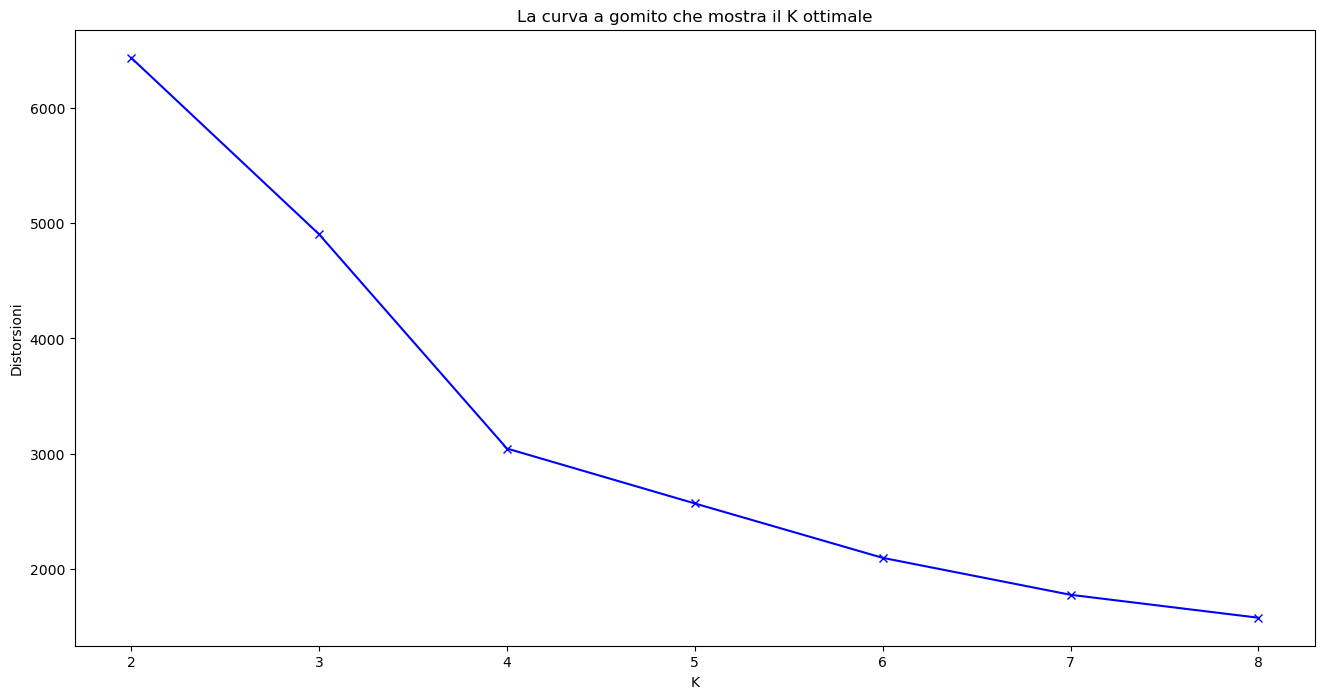

In [72]:
# Plot della curva a gomito: è una tecnica alternativa, GRAFICA (qui con le SS come metrica di confronto):
plt.figure(figsize=(16,8))
plt.plot(range(2,9), distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distorsioni')
plt.title('La curva a gomito che mostra il K ottimale')
plt.show()  # --> K ottimale è 4 o 5, anche se non c'è un chiaro gomito.

Un **utile post** sull'uso del silhoutette score

![](Silhouette_score.png)

Un **utile post** sulle metriche di valutazione del clustering:

In [73]:
from IPython.display import IFrame
IFrame("metrics.pdf", width=600, height=600)

**Elbow vs silhouette** (da [qui](https://www.linkedin.com/posts/avi-chawla_if-you-use-elbow-curve-in-kmeans-read-this-activity-7209133818195156993-JkOz?utm_source=share&utm_medium=member_desktop)):
![](elbow_vs_silhouette.png)

## Interpretare i Segmenti Cliente
Vediamo ora alcuni modi per ricavare "insight" dai risultati del clustering.

In [74]:
# clustering con 4 cluster (k=4 è interessante, sebbene non sia quello che fornisce il miglior coefficiente Silhouette):
kmeans = KMeans(n_clusters=4,random_state=1).fit(normalized_df)

In [75]:
# creazione di un nuovo dataframe con la (quarta) colonna 'cluster' (esattamente come fatto prima)
four_cluster_df = normalized_df.copy(deep=True) # 'copy'!
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.head()

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,3
12347.0,1.457445,1.064173,1.401033,1
12348.0,0.967466,0.573388,0.929590,1
12349.0,0.944096,-1.730641,1.683093,3
12350.0,-0.732148,-1.729835,0.331622,3


In [76]:
print("         TotalSales","  OrderCount","  AvgOrderValue") # heading manuale 
kmeans.cluster_centers_                                       # i centroidi sono le medie dei cluster (mean vectors).

         TotalSales   OrderCount   AvgOrderValue


array([[-1.24815591, -0.79984623, -1.06179228],
       [ 1.20724665,  1.00854659,  0.86511523],
       [ 0.21275184,  0.7109726 , -0.64320306],
       [-0.13088688, -0.84885426,  0.79977693]])

In [77]:
pd.DataFrame(data=kmeans.cluster_centers_, columns=['TotalSales','OrderCount','AvgOrderValue'] )

,TotalSales,OrderCount,AvgOrderValue
0,-1.248156,-0.799846,-1.061792
1,1.207247,1.008547,0.865115
2,0.212752,0.710973,-0.643203
3,-0.130887,-0.848854,0.799777


**Questa array multi-dimensionale riporta i CENTROIDI dei 4 cluster**.

Il secondo cluster (quello ROSSO nello scatterplot) ha tutti e tre gli attributi medio-alti: cioè i clienti di questo cluster comprano spesso e comprano prodotti cari e quindi forniscono il venduto maggiore; in genere le aziende focalizzano le loro azioni di marketing su questo segmento perchè è quello che darà il miglior ritorno.

Il primo cluster ((quello BLU nello scatterplot) ) è quello con i tre attributi più bassi: cioè i clienti di questo cluster  sono quelli di minor valore per l'azienda.

Se dobbiamo prendere solo due cluster (K=2), come suggerito dal silhouette score visto prima, effettivamente i cluster 1 e 2 sono quelli maggiormente differenziati (tutte le componenti del centroide sono alte oppure basse).

Ma anche il cluster 3 e 4 sono interessanti!

Il clienti del terzo cluster (quello ARANCIONE) comprano abbastanza spesso ma l'importo medio dei loro ordini è basso: un marketing di prodotti di basso valore dovrebbe avere un buon ritorno (cioè un buon rapporto costo/benefici).

Infine anche il quarto cluster (quello VERDE) è di un certo interesse: questi clienti danno un venduto medio-basso, però comprano prodotti cari (sebbene non spesso): dunque un marketing mirato ai prodotti cari dovrebbe risultare molto proficuo.

---
*k=4* ci ha comunque fornito delle indicazioni utili, ancorchè i 4 segmenti siano meno differenziati che 2.

---

**In sintesi**: grazie al <u>ranking</u> ed alla <u>standardizzazione</u> (ed al <u>clustering</u> ovviamente), possiamo confrontare i tre attributi dei vari cluster e capire come **differenziare le azioni di marketing in modo da garantirne un buon ritorno (ROI) dell'azione di marketing stessa**.<br>
I <u>centroidi</u> dei cluster ci aiutano a capire meglio i vari cluster (segmenti).

In [78]:
# Visual presentation (profile plot) of cluster centroids (DMfBA python) 

**Limitazioni dei silhouette score**:

**DBCV**<br>
Silhouette score and Calinski-Harabasz index are typically higher for globular (spherical in the case of 3D) clusters.

Thus, using them on density-based clustering can produce misleading results.

DBCV (density-based clustering validation) solves this, and it computes two values:
- The density **within** a cluster.
- The density overlap **between** clusters.

A high density within a cluster and a low density overlap between clusters indicate good clustering results. **The effectiveness of DBCV is evident from the image below**:

![](Limitations_silhouette_score.png)

As depicted above:

The clustering output of KMeans is worse, but its Silhouette score is still higher than that of Density-based clustering.
With DBCV, the score for the clustering output of KMeans is worse, and that of density-based clustering is higher.

## I prodotti *best-seller* per segmento

Per finire, vediamo quali sono i prodotti che vendono meglio in ogni segmento (esempio con il cluster 2). E' molto utile.<br>
Per comodità, ricapitoliamo prima i vari dataframe sin qui creati:
* *df*: il dataframe di dettaglio (con i singoli ordini):
    * originale: cardinalità (541909, 8);
    * pulito (primi 4 step): cardinalità (380620, 8);
* *customer_df*: il dataframe pulito e raggruppato per cliente (3 attributi):
    * cardinalità (4298, 3);
* *rank_df*: il *customer_df* per posizioni (anzichè per valori):
    * cardinalità (4298, 3);
* *normalized_df*: il *rank_df* standardizzato:
    * cardinalità (4298, 3);
* *four_cluster_df*: il *normalized_df* con in più il cluster assegnato da KMeans (quarta colonna):
    * cardinalità (4298, 4). <br>

Siccome lo statement finale è un pò complesso procediamo a passi e check progressivi.

In [79]:
# step 1) estraiamo dall'ultimo dataframe creato le righe del cluster 1 (il secondo) e creiamo un nuovo dataframe 
# (relativo solo a C1).
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 1]   # 1 è il secondo cluster (il migliore).
high_value_cluster.head()                                                   # le righe del cluster 2.

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12347.0,1.457445,1.064173,1.401033,1
12348.0,0.967466,0.573388,0.929590,1
12352.0,1.193114,1.309162,0.169639,1
12356.0,1.268868,0.158357,1.557375,1
12359.0,1.585581,0.574194,1.672617,1


In [80]:
# per nostra comprensione, check VISIVO dell'indice:
high_value_cluster.index # --> l'elenco dei clienti assegnati al cluster 2

Index([12347.0, 12348.0, 12352.0, 12356.0, 12359.0, 12360.0, 12362.0, 12370.0,
       12372.0, 12380.0,
       ...
       18235.0, 18239.0, 18242.0, 18251.0, 18257.0, 18259.0, 18260.0, 18263.0,
       18272.0, 18287.0],
      dtype='float64', name='CustomerID', length=1133)

Ora un paio di veririche che richiedono il reset dell'indice:

In [81]:
high_value_cluster_no_index = high_value_cluster.copy()
high_value_cluster_no_index.reset_index(inplace=True)
high_value_cluster_no_index.head()

,CustomerID,TotalSales,OrderCount,AvgOrderValue,Cluster
0,12347.0,1.457445,1.064173,1.401033,1
1,12348.0,0.967466,0.573388,0.929590,1
2,12352.0,1.193114,1.309162,0.169639,1
3,12356.0,1.268868,0.158357,1.557375,1
4,12359.0,1.585581,0.574194,1.672617,1


In [82]:
# altro check VISIVO, sempre per nostra comprensione:
high_value_cluster_no_index['CustomerID'].isin(high_value_cluster_no_index.index) # isin significa is-in?
                                                # produce un vettore di booleani con:
                                                # - True se il CustomerID della riga è compreso in quelli di C2
                                                # - False altrimenti

0       False
1       False
2       False
3       False
4       False
        ...  
1128    False
1129    False
1130    False
1131    False
1132    False
Name: CustomerID, Length: 1133, dtype: bool

---
**La seguente cella contiene un ERRORE (da correggere)**.

---

In [83]:
# step 2):
# - estraiamo dal dataset originario (col dettaglio) le righe con CustomerID contenuto nell'indice creato allo step 1);
#   si usa qui anche un subsetting booloeano (non vista nell'introduzione a pandas)
# - raggruppiamo per descrizione prodotto;
# - contiamo;
# - ordiniamo in modo discendente.
pd.DataFrame(df.loc[df['CustomerID'].isin(high_value_cluster.index)].groupby('Description').count()['StockCode'].sort_values(ascending=False).head()
)

KeyError: 'CustomerID'

In [ ]:
# Al segmento 2 si possono dunque raccomandare prodotti simili a questi! Utile per le nostre campagne di marketing.

## Clustering con valori
Rimane un'ultima verifica da fare.<br>
Possiamo usare 'KMeans' con i **valori** anzichè le posizioni?<br>
Cioè eseguiamo lo stesso clustering k-means di prima (n_clusters=4,random_state=1) sul dataframe *customer_df* anzichè sul dataframe *rank_df*, ed ovviamente facciamo la standardizzazione preliminare dei dati (comunque necessaria nel clustering).

In [84]:
normalized_df = (customer_df - customer_df.mean()) / customer_df.std() # la standardizzazione
kmeans = KMeans(n_clusters=4,random_state=1).fit(normalized_df)
four_cluster_df = normalized_df.copy(deep=True) 
four_cluster_df['Cluster'] = kmeans.labels_
print(four_cluster_df.head()) # VALORI standardizzati (non ranked)
print("         TotalSales","  OrderCount","  AvgOrderValue") # heading manuale 
kmeans.cluster_centers_  

            TotalSales  OrderCount  AvgOrderValue  Cluster
CustomerID                                                
12346.0       9.004376   -0.422046      60.402857        2
12347.0       0.255222    0.251785       0.220745        0
12348.0      -0.018621   -0.017747       0.038589        0
12349.0      -0.023372   -0.422046       1.067738        0
12350.0      -0.193709   -0.422046      -0.051806        0
         TotalSales   OrderCount   AvgOrderValue


array([[-5.54243595e-02, -5.16676007e-02, -1.95695186e-02],
       [ 6.23815806e+00,  8.67174940e+00,  6.23899845e-01],
       [ 9.00437610e+00, -4.22046161e-01,  6.04028573e+01],
       [ 2.80784760e+01,  7.21471085e+00,  2.94295339e+00]])

In [85]:
# Come si vede l'interpretazione dei centroidi dei cluster non è più così chiara!
# Ad esempio, non c'è più distinzione chiara tra cluster 3 (high-value) e cluster 1 (low-value)!
# Perchè succede questo? 
# Insight: i valori, ancorchè standardizzati, sono comunque influenzati dalla loro magnitudo. La posizione, no.
# Reminder: la mediana NON è influenzata dagli outlier, la media, sì.

## Altre applicazioni del k-means 

**Google News** usa il clustering k-means. Prende i news feed e li clusterizza al volo, con tecnologia *massive parallel*.

# Segmentazione big customer data
Esempi di Claude.

---
**Devo segmentare 1 milione di clienti: uso KMeans o Clustering Gerarchico?**

In breve: **meglio KMeans** (o una sua variante ottimizzata). Il **clustering gerarchico** su dataset così grandi è **da evitare**.

**KMeans è preferibile**:

| Aspetto              | KMeans                                     | Clustering Gerarchico                               |
| -------------------- | ------------------------------------------ | --------------------------------------------------- |
| **Scalabilità**      | ✅ Ottimo su milioni di record              | ❌ Complessità quadratica → ingestibile su big data  |
| **Velocità**         | ✅ Veloce, specialmente con MiniBatchKMeans | ❌ Lentissimo su grandi dataset                      |
| **Uso di memoria**   | ✅ Contenuto                                | ❌ Molto alto (memorizza distanze tra tutti i punti) |
| **Parallelizzabile** | ✅ Sì                                       | ❌ No                                                |
| **Visualizzabilità** | ✅ Cluster ben definiti                     | ❌ Dendrogrammi inutilizzabili su 1M righe           |

---

**Variante del kmeans consigliata: **MiniBatchKMeans****<br>

È una versione di KMeans (sempre della libreria scikit-learn) pensata per dataset grandi:

```python
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000, random_state=42)
kmeans.fit(X)  # dove X è la matrice delle caratteristiche
```

* Lavora a blocchi (anzichè a righe singole) → molto più veloce e leggero (meno risorse hardware e tempi di elaborazione minore)
* Risultati simili al KMeans classico
* Gestisce senza problemi milioni di righe

---

⚠️ Attenzione a:

* **Scegliere il numero di cluster (`k`)**: puoi usare l’**elbow method** o lo **silhouette score** su un sottoinsieme del dataset
* KMeans funziona bene se i cluster sono "sferici" e di densità simile – se non è così, ci sono alternative

---

Alternative se vuoi qualcosa di più avanzato:

| Algoritmo          | Quando usarlo                                                            |
| ------------------ | ------------------------------------------------------------------------ |
| **HDBSCAN**        | Non sai quanti cluster ci sono, e hai densità variabili (ma più pesante) |
| **DBSCAN**         | Se i cluster sono definiti per densità (non scala bene su 1M)            |
| **PCA + KMeans**   | Se hai tante feature, fai prima PCA e poi cluster                        |
| **UMAP + HDBSCAN** | Se vuoi un clustering + visualizzazione più evoluta                      |

---

Prima del clustering: **preprocessing**

* **Standardizza** le feature con `StandardScaler`
* **Riduci le dimensioni** con PCA (es. a 20 colonne); PCA sta per [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)
* Puoi **estrarre un campione** (es. 100.000 clienti) per testare le strategie prima di lavorare sull’intero milione

Il primo step è obbligatorio con il kmeans().<br>
Il secondo step è utile se le colonne sono diverse decine.<br>
IL terzo step è una possibilità, utile se uso il `kmeans`, non necessario con `MiniBatchKMeans`

---

In sintesi:

* **Usa `MiniBatchKMeans`**
* **Evita clustering gerarchico** su dataset grandi
* **Pre-elabora i dati** con StandardScaler (sempre) ed eventualmente con PCA 
* **Valuta alternative** (come HDBSCAN) solo se hai esigenze particolari e molte risorse hardware

---



## MiniBatchKMeans

Il [package `MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) di *scikit-learn* è perfetto per big data.

**Cos'è MiniBatchKMeans**<br>
MiniBatchKMeans è una variante dell'algoritmo KMeans che usa **mini-batch** per ridurre il tempo di calcolo, continuando a ottimizzare la stessa funzione obiettivo. I mini-batch sono sottoinsiemi dei dati di input, campionati casualmente ad ogni iterazione di training.

**Come Funziona l'Algoritmo**<br>

1. ***Processo Standard KMeans vs MiniBatch***

    KMeans Tradizionale:
    1. Carica TUTTI i dati in memoria
    2. Calcola distanze per OGNI punto dai centroidi
    3. Assegna TUTTI i punti ai cluster (il più vicino)
    4. Ricalcola centroidi con TUTTI i punti
    5. Ripeti fino a convergenza

    <br>

    MiniBatchKMeans:
    1. Carica solo un PICCOLO BATCH (es: 10K punti)
    2. Calcola distanze solo per il batch
    3. Assegna solo i punti del batch
    4. Aggiorna centroidi incrementalmente
    5. Prendi un NUOVO batch e ripeti
<br>

2. **Aggiornamento Incrementale dei Centroidi**

    L'algoritmo itera tra due passi principali. Nel primo passo, b campioni vengono estratti casualmente dal dataset per formare un mini-batch, che vengono poi assegnati al centroide più vicino. Nel secondo passo, i centroidi vengono aggiornati su base per-campione. Per ogni campione nel mini-batch, il centroide assegnato viene aggiornato prendendo la media mobile del campione e di tutti i campioni precedenti assegnati a quel centroide.

    Formula dell'aggiornamento:
    ```
    nuovo_centroide = (1 - learning_rate) * vecchio_centroide + learning_rate * nuovo_punto
    ```
    
    Dove `learning_rate` diminuisce nel tempo per stabilizzare la convergenza.

**Vantaggi per Big Data**

1. ***Memoria Ridotta***
    - **KMeans**: Richiede `n_samples × n_features × 8 bytes` in memoria
    - **MiniBatchKMeans**: Richiede solo `batch_size × n_features × 8 bytes`
      
    <br>
    
        Esempio pratico:
            Dataset: 10M clienti × 15 features
            - KMeans: ~1.2 GB di RAM
            - MiniBatchKMeans (batch=10K): ~1.2 MB di RAM
<br>

2. ***Velocità di Convergenza***(cioè quando la funziona obiettivo da minimizzare non migliora oltre una certa tolleranza) :<br>
    MiniBatchKMeans è più veloce, ma dà risultati leggermente diversi rispetto al KMeans standard.

    **Tempi tipici (sui nostri dati)**:
    - **100K clienti**: KMeans 2 min → MiniBatch 30 sec
    - **1M clienti**: KMeans 20 min → MiniBatch 5 min  
    - **10M clienti**: KMeans impossibile → MiniBatch 30 min
<br>

3. ***Scalabilità***<br>
Per apprendimento su larga scala (diciamo `n_samples > 10k`) `MiniBatchKMeans` è probabilmente molto più veloce dell'implementazione batch predefinita.

Nota terminologica sul Machine Learning:
- `features`: le colonne del dataset
- `samples`: le righe del dataset

**Parametri chiave dell'algoritmo `MiniBatchKmeans()`**:<br>
```python
MiniBatchKMeans(
    n_clusters=5,           # Numero di cluster finali
    batch_size=10000,       # Dimensione mini-batch
    max_iter=300,          # Massimo iterazioni
    random_state=42,       # Riproducibilità
    n_init=3               # Inizializzazioni multiple
)
```

**Batch Size**: Bilanciamento Qualità/Velocità:
- **Piccolo (1K)**: Velocissimo, ma meno accurato
- **Medio (10K)**: Buon compromesso
- **Grande (100K)**: Più accurato, ma più lento

**Qualità dei Risultati**

MiniBatchKMeans converge più velocemente di KMeans, ma la qualità dei risultati è ridotta. In pratica questa differenza di qualità può essere abbastanza piccola.

**Perdita di qualità tipica** (rispetto al `kmeans`):
- **Silhouette Score**: -5% rispetto a KMeans standard
- **Inertia**: +3-8% rispetto a KMeans standard
- **Stabilità**: Leggermente meno stabile tra run diversi

**Ottimizzazioni Implementate**

1. Campionamento Intelligente
```python
# Nel nostro codice per silhouette score
sample_size = min(50000, len(features_scaled))
sample_indices = np.random.choice(len(features_scaled), sample_size)
```

2. Early Stopping
- Stop quando i centroidi si muovono poco
- Stop dopo max iterazioni
- Stop quando l'inertia non migliora

3. Inizializzazione K-means++
- Centroidi iniziali ben distribuiti
- Migliore convergenza rispetto a inizializzazione casuale

**Quando Usare MiniBatchKMeans**

**✅ Usa MiniBatchKMeans quando**:
- Dataset > 50K punti
- Memoria limitata
- Serve velocità
- Accuratezza "buona" è sufficiente

**❌ Usa KMeans standard quando**:
- Dataset piccolo (< 10K punti)
- Massima accuratezza richiesta
- Memoria abbondante
- Tempo non è critico

**Risultati nel Nostro Caso d'Uso**:<br>
Per la **segmentazione clienti**, MiniBatchKMeans è perfetto perché:
1. **Business Impact**: La differenza di qualità è minima ma il tempo di analisi si riduce drasticamente
2. **Iterazioni Veloci**: Permette di testare rapidamente diversi numeri di cluster
3. **Scalabilità**: Gestisce facilmente milioni di clienti
4. **Robustezza**: Risultati sufficientemente stabili per decisioni business

In sostanza, MiniBatchKMeans ci permette di fare clustering **enterprise-grade** su big data mantenendo tempi ragionevoli e qualità accettabile! 🚀

**`MiniBatchKMeans` usa solo la CPU, non la GPU**. Ecco perchè:<br> 
🖥️ Architettura di `MiniBatchKMeans`:
1. Implementazione CPU-Only

    - Scikit-learn: Tutte le implementazioni sono CPU-based
    - Linguaggio: Python + Cython + C per le parti critiche
    - Parallelismo: KMeans beneficia del parallelismo basato su OpenMP attraverso Cython. Piccoli chunk di dati (256 campioni) vengono processati in parallelo 2.3. Clustering — scikit-learn 1.7.0 documentation
    - Threading: Multi-threading su CPU, non GPU computing


2. Perché Non GPU?

    La architettura di scikit-learn:
    - CPU Memory ←→ CPU Cores (multi-threaded)<br>
    - No GPU acceleration built-in

## Un sistema completo di  clustering clienti in ambito e-commerce

Questo esempio mostra **un sistema completo di clustering per big data** applicato alla **segmentazione clienti** in un contesto **e-commerce**.

Ecco i punti chiave del sistema completo di clustering:<br>

**Caratteristiche Big Data**:<br>
- Scalabilità: Usa `MiniBatchKMeans` invece di `K-means` standard per gestire grandi volumi (fino a milioni di record)
- Efficienza memoria: `MiniBatchKMeans` implementa tecniche di campionamento per il calcolo del silhouette score e gestisce la memoria in modo ottimale
- Performance: `MiniBatchKMeans` utilizza batch processing e limita le iterazioni per tempi di esecuzione ragionevoli

**Funzionalità Principali** del sistema:
- Generazione dati sintetici: **Simula** un dataset **realistico** con metriche RFM (Recency, Frequency, Monetary)
- **Configurazione** dell'algoritmo e **fit** sul dataset
- Ottimizzazione automatica: Trova il numero ottimale di cluster (`n_cluster`) usando **elbow method** e **silhouette analysis**
- Analisi avanzata: Profiling automatico dei cluster con **interpretazione business**
- Visualizzazione: Riduzione dimensionale **con PCA** per visualizzare cluster complessi
- Esportazione: **Salvataggio risultati** per utilizzo downstream

**Segmenti Tipici Identificati**:
- Clienti **VIP Attivi**: alto valore, acquisti frequenti
- Clienti **a Rischio**: alto valore ma inattivi
- Clienti **nuovi**: pochi ordini, da sviluppare
- Clienti **dormienti**: da riattivare con campagne mirate
- Clienti **standard**: base clienti regolare

Per dataset reali ancora più grandi, si possono considerare tecnologie come **Dask** per il parallelismo o **Spark** per cluster hardware distribuiti.

**Flusso Logico Completo del notebook**:<br>
Creazione Dati Raw → Pulizia → Features → Ottimizzazione → Clustering → Analisi numerica → Visualizzazione → Export → Business Report.

Ogni cella costruisce sui risultati della precedente, creando **una pipeline completa**, dall'analisi esplorativa alle raccomandazioni per il business!

In un'azienda reale, l'unico passo di questa pipeline da saltare è ovviamente il primo (la generazione dei dati).<br>
Questo notebook è comunque costruito in modo da minimizzare la personalizzazione.

### Import e Setup Iniziale

Scopo: Preparare l'ambiente di lavoro.<br>
Cosa fa:
- Import librerie: Carica tutte le librerie necessarie (pandas, sklearn, matplotlib, etc.)
- Configurazione grafica: Imposta stile seaborn per grafici più belli
- Parametri globali: Definisce N_CUSTOMERS (dimensione dataset) e RANDOM_SEED (per riproducibilità)
- Controllo ambiente: Verifica che tutto sia pronto per l'esecuzione

Output: Messaggio di conferma setup completato

In [86]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Impostazioni per la visualizzazione
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configurazione globale
N_CUSTOMERS = 1000000  # Modifica questo valore per cambiare la dimensione del dataset
RANDOM_SEED = 42

print(f"✅ Setup completato!")
print(f"📊 Dataset size: {N_CUSTOMERS:,} clienti")

✅ Setup completato!
📊 Dataset size: 1,000,000 clienti


### Generazione Dataset Sintetico

Scopo: Creare un dataset realistico di clienti e-commerce.<br>
Cosa fa:
- Simulazione comportamenti: Genera dati usando distribuzioni statistiche realistiche:
    * Poisson per conteggi (ordini, visite web)
    * Gamma per valori monetari (spesa totale, valore ordine)
    * Exponential per tempi (giorni dall'ultimo ordine)
    * Beta per percentuali (tasso di reso)
    * Normal per demografia (età)
- Pulizia dati: Applica limiti realistici (età 18-80, tassi reso 0-50%).
- Creazione DataFrame: Organizza tutto in una tabella pandas

Output:
- Dataset con ~13 colonne e N_CUSTOMERS righe
- Preview delle prime righe
- Statistiche descrittive

In [87]:
def generate_customer_data(n_customers=N_CUSTOMERS):
    """Genera dataset sintetico di clienti e-commerce"""
    print(f"Sta generando il dataset con {n_customers:,} clienti...")
    
    np.random.seed(RANDOM_SEED)
    
    # Generazione dati clienti
    data = {
        'customer_id': range(1, n_customers + 1),
        
        # Comportamento di acquisto (M = Monetary)
        'total_orders': np.random.poisson(8, n_customers),
        'total_spent': np.random.gamma(2, 150, n_customers),
        'avg_order_value': np.random.gamma(1.5, 80, n_customers),
        
        # Frequenza e recency (F = Frequency, R = Recency)
        'days_since_last_order': np.random.exponential(30, n_customers),
        'order_frequency': np.random.gamma(1, 0.5, n_customers),
        
        # Preferenze prodotto
        'categories_purchased': np.random.poisson(3, n_customers),
        'returns_rate': np.random.beta(2, 20, n_customers),
        
        # Engagement del cliente
        'website_visits': np.random.poisson(15, n_customers),
        'email_opens': np.random.poisson(5, n_customers),
        'social_media_engagement': np.random.poisson(2, n_customers),
        
        # Demografia simulata
        'age': np.random.normal(35, 12, n_customers),
        'tenure_months': np.random.exponential(24, n_customers)
    }
    
    # Creazione DataFrame
    df = pd.DataFrame(data)
    
    # Pulizia e trasformazioni
    df['age'] = np.clip(df['age'], 18, 80)
    df['tenure_months'] = np.clip(df['tenure_months'], 1, 120)
    df['returns_rate'] = np.clip(df['returns_rate'], 0, 0.5)
    
    return df

# Esecuzione
df = generate_customer_data()
print(f"✅ Dataset generato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
print(f"💾 Memoria utilizzata: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Preview dei dati
print("\n📊 Prime 5 righe:")
display(df.head())

print("\n📈 Statistiche descrittive:")
display(df.describe())

Sta generando il dataset con 1,000,000 clienti...
✅ Dataset generato: 1,000,000 righe, 13 colonne
💾 Memoria utilizzata: 80.11 MB

📊 Prime 5 righe:


,customer_id,total_orders,total_spent,avg_order_value,days_since_last_order,order_frequency,categories_purchased,returns_rate,website_visits,email_opens,social_media_engagement,age,tenure_months
0,1,6,364.990545,121.061286,34.353577,0.792294,8,0.031796,16,1,2,18.000000,8.987012
1,2,7,131.474831,158.023217,4.133035,0.168357,4,0.068631,9,1,1,39.520055,45.257540
2,3,6,160.559589,111.493619,28.255517,0.415759,5,0.041809,12,3,1,47.305159,3.509527
3,4,7,566.829253,62.219351,5.460623,0.088713,3,0.048395,14,5,3,27.391209,27.144926
4,5,7,206.553582,175.037904,60.795849,0.028916,1,0.243717,11,5,3,18.000000,41.258082



📈 Statistiche descrittive:


,customer_id,total_orders,total_spent,avg_order_value,days_since_last_order,order_frequency,categories_purchased,returns_rate,website_visits,email_opens,social_media_engagement,age,tenure_months
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,7.999024,299.974987,119.946534,30.018697,5.002971e-01,3.001121,0.090975,15.002837,4.995684,2.001392,35.422128,23.836025
std,288675.278933,2.828013,212.038583,97.919711,30.028910,5.006670e-01,1.732396,0.060025,3.876925,2.234148,1.414069,11.200254,23.093996
min,1.000000,0.000000,0.210383,0.005780,0.000009,6.784329e-07,0.000000,0.000036,1.000000,0.000000,0.000000,18.000000,1.000000
25%,250000.750000,6.000000,144.206621,48.506826,8.641380,1.439883e-01,2.000000,0.045817,12.000000,3.000000,1.000000,26.891109,6.912755
50%,500000.500000,8.000000,251.870155,94.663389,20.799971,3.468184e-01,3.000000,0.078632,15.000000,5.000000,2.000000,35.002361,16.646167
75%,750000.250000,10.000000,403.787187,164.339095,41.583370,6.927170e-01,4.000000,0.123224,18.000000,6.000000,3.000000,43.083179,33.255983
max,1000000.000000,26.000000,2657.571233,1209.299528,453.414828,6.662427e+00,15.000000,0.500000,38.000000,19.000000,13.000000,80.000000,120.000000


In [88]:
df.shape

(1000000, 13)

In [89]:
df.columns

Index(['customer_id', 'total_orders', 'total_spent', 'avg_order_value',
       'days_since_last_order', 'order_frequency', 'categories_purchased',
       'returns_rate', 'website_visits', 'email_opens',
       'social_media_engagement', 'age', 'tenure_months'],
      dtype='object')

### Calcolo RFM Scores

Scopo: Calcolare le metriche business fondamentali.<br>
Cosa fa:
- Recency Score: Divide i clienti in 5 gruppi basati su quanto recentemente hanno acquistato
    * 5 = molto recente, 1 = molto tempo fa
- Frequency Score: Divide in 5 gruppi basati sulla frequenza di acquisto
    * 5 = molto frequente, 1 = raro
- Monetary Score: Divide in 5 gruppi basati sulla spesa totale
    * 5 = alto spendente, 1 = basso spendente
- Quantili uniformi: Usa pd.qcut() per creare gruppi di dimensioni uguali
- Visualizzazione: Mostra la distribuzione dei punteggi RFM

Output: 3 nuove colonne RFM + grafici a barre delle distribuzioni

Sta calcolando gli RFM scores...
✅ RFM scores calcolati!


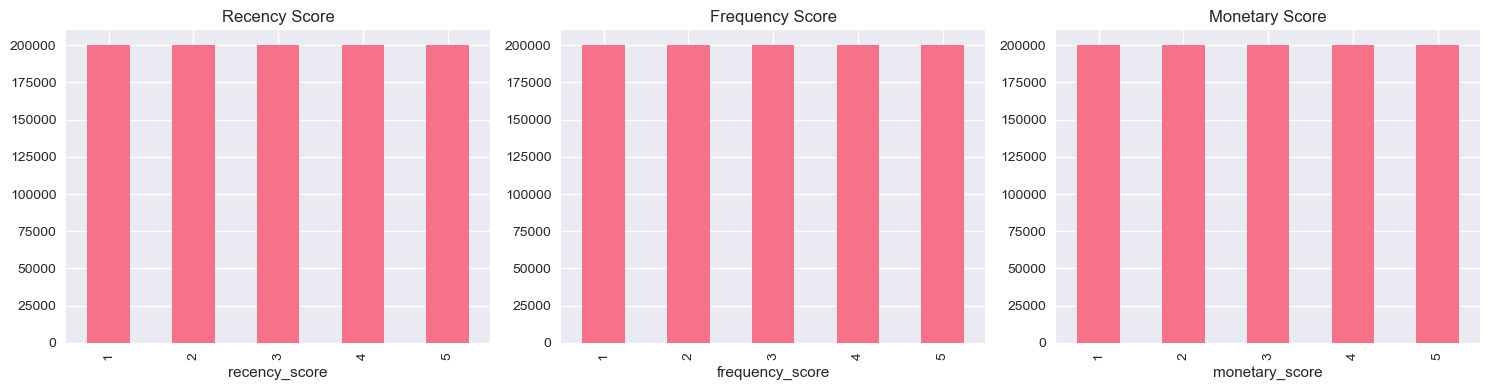


📊 Distribuzione RFM Scores:
Recency Score (5=molto recente, 1=molto tempo fa)
Frequency Score (5=molto frequente, 1=raro)
Monetary Score (5=alto valore, 1=basso valore)


In [90]:
def calculate_rfm_scores(df):
    """Calcola i punteggi RFM (Recency, Frequency, Monetary)"""
    print("Sta calcolando gli RFM scores...")
    
    df_rfm = df.copy()
    
    # Calcolo RFM scores
    df_rfm['recency_score'] = pd.qcut(df_rfm['days_since_last_order'], 
                                     q=5, labels=[5,4,3,2,1])
    df_rfm['frequency_score'] = pd.qcut(df_rfm['total_orders'].rank(method='first'), 
                                       q=5, labels=[1,2,3,4,5])
    df_rfm['monetary_score'] = pd.qcut(df_rfm['total_spent'], 
                                      q=5, labels=[1,2,3,4,5])
    
    # Conversione in numeric
    df_rfm['recency_score'] = df_rfm['recency_score'].astype(int)
    df_rfm['frequency_score'] = df_rfm['frequency_score'].astype(int)
    df_rfm['monetary_score'] = df_rfm['monetary_score'].astype(int)
    
    return df_rfm

# Esecuzione
df = calculate_rfm_scores(df)
print("✅ RFM scores calcolati!")

# Visualizzazione distribuzione RFM
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

df['recency_score'].value_counts().sort_index().plot(kind='bar', ax=axes[0], title='Recency Score')
df['frequency_score'].value_counts().sort_index().plot(kind='bar', ax=axes[1], title='Frequency Score')
df['monetary_score'].value_counts().sort_index().plot(kind='bar', ax=axes[2], title='Monetary Score')

plt.tight_layout()
plt.show()

print("\n📊 Distribuzione RFM Scores:")
print("Recency Score (5=molto recente, 1=molto tempo fa)")
print("Frequency Score (5=molto frequente, 1=raro)")
print("Monetary Score (5=alto valore, 1=basso valore)")

---
Il dataset generato (`df`) contiene 3 colonne in più (RFM) rispetto alle quali è ben **bilanciato**<br>

---

In [91]:
df.shape

(1000000, 16)

### Preparazione Features per Clustering

Scopo: Preparare i dati per l'algoritmo di machine learning.<br>
Cosa fa:
- Selezione features: Sceglie 15 variabili numeriche rilevanti per il clustering (tutte tranne il CustomerID)
- Gestione missing: Riempie eventuali valori mancanti con la mediana
- Standardizzazione: Trasforma tutte le variabili per avere media=0 e std=1
    * Perché importante: Gli algoritmi di clustering sono sensibili alla scala
    * Esempio: €1000 vs 5 ordini → entrambi diventano valori comparabili
- Analisi correlazioni: Mostra heatmap delle correlazioni tra variabili

Output:
- Array standardizzato pronto per clustering
- Oggetto scaler per future trasformazioni
- Heatmap correlazioni

In [92]:
def prepare_clustering_features(df):
    """Prepara le features per il clustering"""
    print("Sta preparando features per il clustering...")
    
    # Selezione features
    feature_columns = [
        
        'total_orders', 'total_spent', 'avg_order_value',
        'days_since_last_order', 'order_frequency',
        'categories_purchased', 'returns_rate',
        'website_visits', 'email_opens', 'social_media_engagement',
        'age', 'tenure_months',
        'recency_score', 'frequency_score', 'monetary_score'
    ]

   
    features = df[feature_columns].copy()
    
    # Gestione valori mancanti
    features = features.fillna(features.median())
    
    # Standardizzazione
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    print(f"✅ Features preparate: {len(feature_columns)} colonne")
    print(f"📊 Shape features: {features_scaled.shape}")
    
    return features, features_scaled, scaler, feature_columns



In [93]:
# Esecuzione
features, features_scaled, scaler, feature_columns = prepare_clustering_features(df)

Sta preparando features per il clustering...
✅ Features preparate: 15 colonne
📊 Shape features: (1000000, 15)


In [94]:
display("Feature: ",features)
display("Feature scaled: ", features_scaled)
display("Scaler: ",scaler)
display("Feature columns: ",feature_columns)

'Feature: '

,total_orders,total_spent,avg_order_value,days_since_last_order,order_frequency,categories_purchased,returns_rate,website_visits,email_opens,social_media_engagement,age,tenure_months,recency_score,frequency_score,monetary_score
0,6,364.990545,121.061286,34.353577,0.792294,8,0.031796,16,1,2,18.000000,8.987012,2,1,4
1,7,131.474831,158.023217,4.133035,0.168357,4,0.068631,9,1,1,39.520055,45.257540,5,2,2
2,6,160.559589,111.493619,28.255517,0.415759,5,0.041809,12,3,1,47.305159,3.509527,2,1,2
3,7,566.829253,62.219351,5.460623,0.088713,3,0.048395,14,5,3,27.391209,27.144926,5,2,5
4,7,206.553582,175.037904,60.795849,0.028916,1,0.243717,11,5,3,18.000000,41.258082,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,7,770.277570,138.537948,84.495023,0.079921,3,0.033261,12,5,2,42.603877,5.079587,1,3,5
999996,10,115.622419,17.130189,14.808063,1.711177,1,0.103660,17,6,4,30.317999,20.210842,4,5,1
999997,10,558.141900,40.349822,0.020649,0.113773,1,0.019463,11,5,2,46.744399,23.474152,5,5,5
999998,12,158.328497,28.516289,65.661733,1.025116,2,0.072871,19,11,2,24.808172,4.448697,1,5,2


'Feature scaled: '

array([[-0.70686558,  0.30662151,  0.01138435, ..., -0.70710678,
        -1.41421356,  0.70710678],
       [-0.35326023, -0.79466783,  0.38885635, ...,  1.41421356,
        -0.70710678, -0.70710678],
       [-0.70686558, -0.65750047, -0.086325  , ..., -0.70710678,
        -1.41421356, -0.70710678],
       ...,
       [ 0.70755582,  1.21754748, -0.81287772, ...,  1.41421356,
         1.41421356,  1.41421356],
       [ 1.41476652, -0.66802258, -0.93372713, ..., -1.41421356,
         1.41421356, -0.70710678],
       [ 1.41476652,  1.76634392, -0.72276349, ...,  0.        ,
         1.41421356,  1.41421356]])

'Scaler: '

,copy,True
,with_mean,True
,with_std,True


'Feature columns: '

['total_orders',
 'total_spent',
 'avg_order_value',
 'days_since_last_order',
 'order_frequency',
 'categories_purchased',
 'returns_rate',
 'website_visits',
 'email_opens',
 'social_media_engagement',
 'age',
 'tenure_months',
 'recency_score',
 'frequency_score',
 'monetary_score']

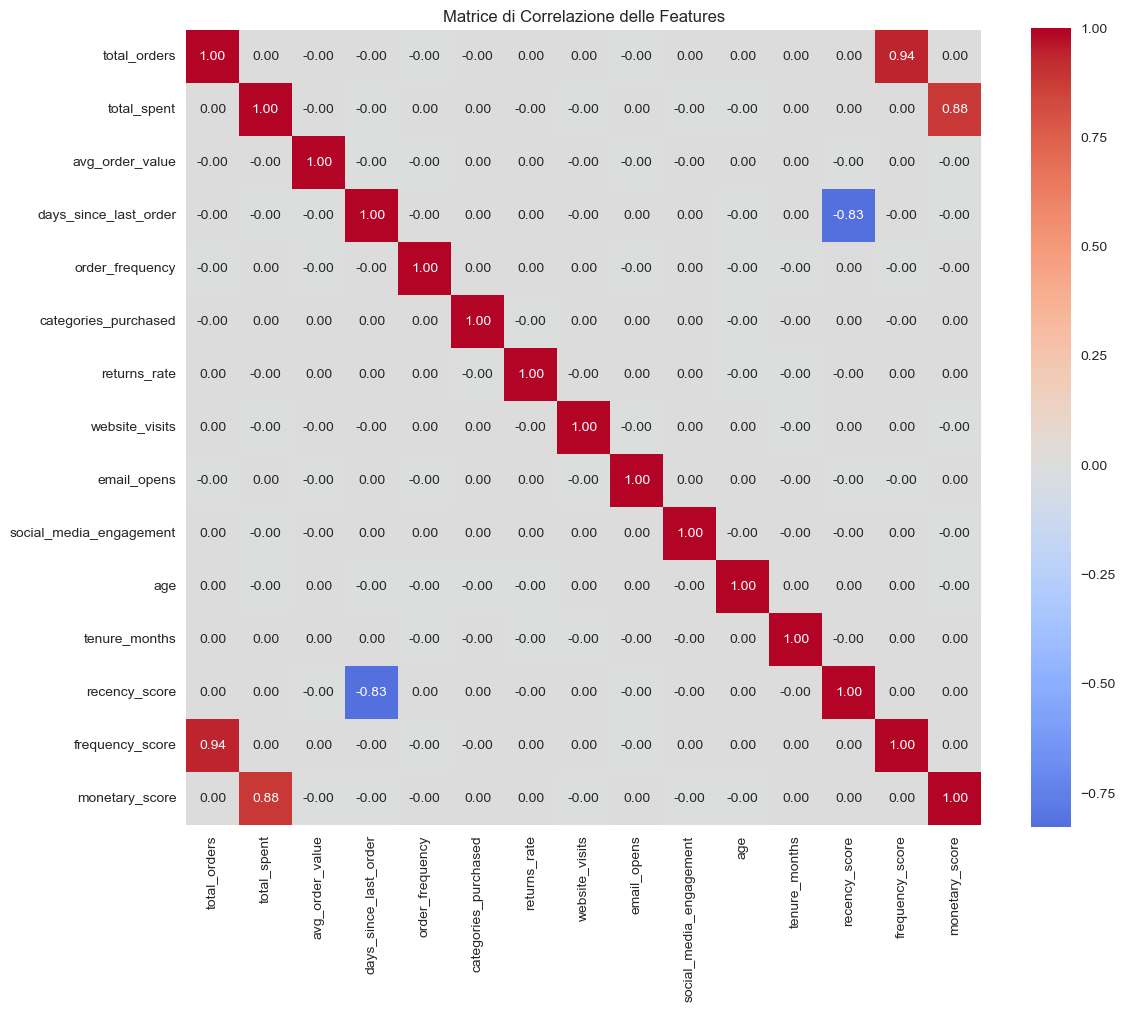


🔍 Features selezionate per clustering:
 1. total_orders
 2. total_spent
 3. avg_order_value
 4. days_since_last_order
 5. order_frequency
 6. categories_purchased
 7. returns_rate
 8. website_visits
 9. email_opens
10. social_media_engagement
11. age
12. tenure_months
13. recency_score
14. frequency_score
15. monetary_score


In [95]:
# Visualizzazione correlazioni
plt.figure(figsize=(12, 10))
correlation_matrix = features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Matrice di Correlazione delle Features')
plt.tight_layout()
plt.show()

print("\n🔍 Features selezionate per clustering:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

**Le tre correlazioni evidenziate sono ragionevoli**.

Il dataset `features_scaled` è **un'array numpy** (è l'output della classe `StandardScaler`).

In [96]:
features_scaled

array([[-0.70686558,  0.30662151,  0.01138435, ..., -0.70710678,
        -1.41421356,  0.70710678],
       [-0.35326023, -0.79466783,  0.38885635, ...,  1.41421356,
        -0.70710678, -0.70710678],
       [-0.70686558, -0.65750047, -0.086325  , ..., -0.70710678,
        -1.41421356, -0.70710678],
       ...,
       [ 0.70755582,  1.21754748, -0.81287772, ...,  1.41421356,
         1.41421356,  1.41421356],
       [ 1.41476652, -0.66802258, -0.93372713, ..., -1.41421356,
         1.41421356, -0.70710678],
       [ 1.41476652,  1.76634392, -0.72276349, ...,  0.        ,
         1.41421356,  1.41421356]])

### Ricerca Numero Ottimale di Cluster

Scopo: Determinare automaticamente quanti cluster usare.<br>
Cosa fa:
- Test multipli: Prova diversi numeri di cluster (da 2 a 8)
- Algoritmo efficiente: Usa MiniBatchKMeans per gestire grandi dataset
- Due metriche:
    * Inertia: Somma delle distanze quadrate dai centroidi (più basso = meglio)
    * Silhouette Score: Qualità della separazione tra cluster (più alto = meglio)
- Campionamento intelligente: Calcola silhouette su 50K campioni per velocità
- Visualizzazione decisionale:
    * Elbow Plot: Cerca il "gomito" dove l'inertia smette di migliorare
    * Silhouette Plot: Trova il picco di qualità

Output:
- Grafici per decision making
- Numero ottimale suggerito automaticamente

In [97]:
def find_optimal_clusters(features_scaled, max_k=10):
    """Trova il numero ottimale di cluster"""
    print("Sta cercando il numero ottimale di cluster...")
    
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        print(f"Testing k={k}...")
        
        # MiniBatchKMeans per performance su big data
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_SEED, 
                               batch_size=10000, max_iter=100)
        kmeans.fit(features_scaled)
        
        inertias.append(kmeans.inertia_)
        
        # Calcolo silhouette score su campione
        sample_size = min(50000, len(features_scaled))
        sample_indices = np.random.choice(len(features_scaled), 
                                        sample_size, replace=False)
        sample_features = features_scaled[sample_indices]
        sample_labels = kmeans.predict(sample_features)
        
        sil_score = silhouette_score(sample_features, sample_labels)
        silhouette_scores.append(sil_score)
        
        print(f"   Inertia: {kmeans.inertia_:.2f}, Silhouette: {sil_score:.3f}")
    
    return k_range, inertias, silhouette_scores

Per la seguente cella occorrono un paio di minuti (con `max_k=8`).

In [99]:
import time
start_time = time.time() # adesso

# Esecuzione
k_range, inertias, silhouette_scores = find_optimal_clusters(features_scaled, max_k=8)

end_time = time.time()
tempo_exec = round(end_time - start_time,2)

print("Il tempo impiegato è stato di secondi: ", tempo_exec)


Sta cercando il numero ottimale di cluster...
Testing k=2...


KeyboardInterrupt: 

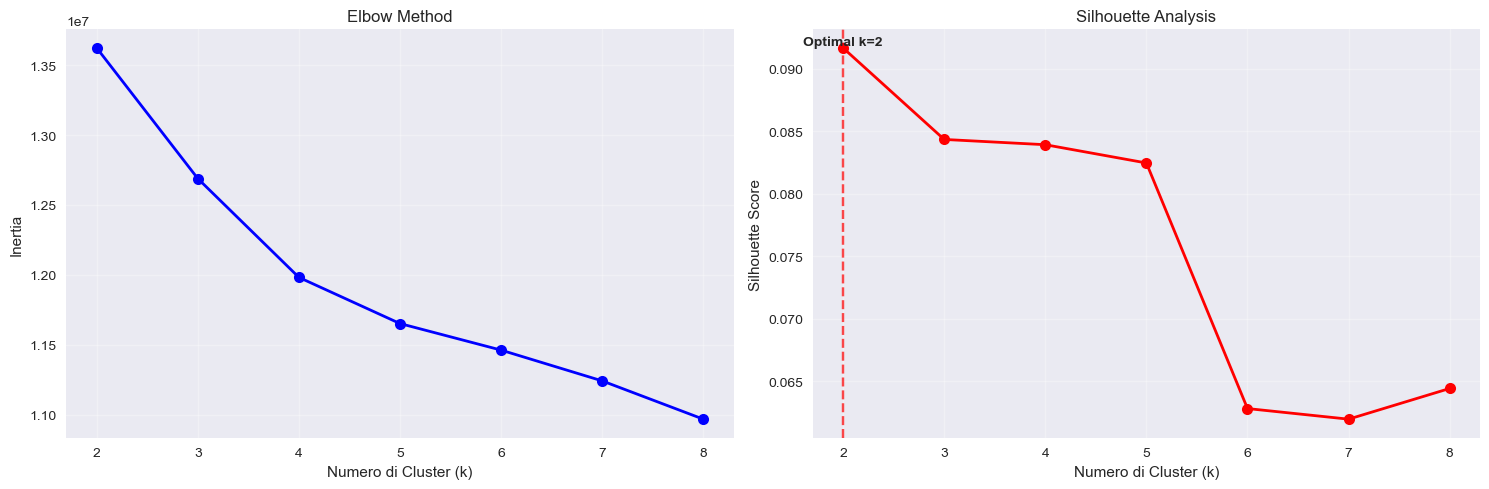


🎯 Numero ottimale di cluster suggerito: 2
📊 Silhouette score massimo: 0.092


In [100]:
# Visualizzazione risultati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Numero di Cluster (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Numero di Cluster (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True, alpha=0.3)

# Evidenzia il massimo
optimal_k = k_range[np.argmax(silhouette_scores)]
ax2.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)
ax2.text(optimal_k, max(silhouette_scores), f'Optimal k={optimal_k}', 
         ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎯 Numero ottimale di cluster suggerito: {optimal_k}")
print(f"📊 Silhouette score massimo: {max(silhouette_scores):.3f}")

Lo score silhouette consiglia **k=2**. Il grafico a sinistra (del metodo *elbow*) mostra invece un leggero gomito per **k=4**.<br>
Scegliamo per ora **k=2**.

### Esecuzione Clustering

Scopo: Applicare l'algoritmo di clustering finale.

Cosa fa:
- Configurazione algoritmo: Usa MiniBatchKMeans **ottimizzato per big data**
    * Batch size: 10K punti per iterazione
    * Max iterations: 300 per convergenza
    * Random seed: Per risultati riproducibili
- Training: Addestra il modello sui dati standardizzati
- Predizione: Assegna ogni cliente a un cluster
- Aggiunta risultati: Inserisce la colonna 'cluster' nel DataFrame originale

Output:
- Modello kmeans addestrato
- Distribuzione clienti per cluster
- Grafico a barre con percentuali

In [101]:
def perform_clustering(features_scaled, n_clusters=None):
    """Esegue il clustering finale"""
    if n_clusters is None:
        n_clusters = optimal_k
    
    print(f"Sto eseguendo clustering con {n_clusters} cluster...")
    
    # Clustering finale
    kmeans_final = MiniBatchKMeans(
        n_clusters=n_clusters, 
        random_state=RANDOM_SEED,
        batch_size=10000,
        max_iter=300
    )
    
    # Fit del modello

    import time
    start_time = time.time() # adesso
    
    kmeans_final.fit(features_scaled)                 # il fit

    end_time = time.time()
    tempo_exec = round(end_time - start_time,2)
    
    print("Il tempo impiegato è stato di secondi: ", tempo_exec)
    
    # Predizione cluster
    clusters = kmeans_final.predict(features_scaled)
    
    print("✅ Clustering completato!")
    
    return kmeans_final, clusters



Un punto importante con big data set è il metodo di **inizializzazione di centroidi** (parametro `init`).

🔹 1. **`init="k-means++"`** (consigliato)
- Default e anche **la scelta migliore nella maggior parte dei casi**.
- Inizializza i centroidi in modo intelligente, scegliendo punti distanti tra loro.
- Riduce la probabilità di convergere in un minimo locale pessimo.
-Funziona molto bene anche con `MiniBatchKMeans`.

👉 Vantaggi:
- Buona qualità del clustering.
- Si adatta bene a dataset molto grandi.

💡 Se vuoi velocizzare ulteriormente, puoi usare anche:
```python
init="k-means++", init_size=10000
```
dove `init_size` indica il sottoinsieme iniziale usato per scegliere i centroidi.


2. **`init="random"`**<br>
- Semplice inizializzazione casuale.
- Può portare a risultati peggiori o non stabili.

👉 Sconsigliato con dataset grandi: potresti finire in minimi locali.

🔹 3. **`init=array_like`**<br>
- Ti permette di fornire tu stesso i centroidi iniziali (array di shape (n_clusters, n_features)).

👉 Utile se:
- Hai già fatto un pre-clustering.
- Hai conoscenza pregressa (es. medie storiche dei segmenti).
- Vuoi riprodurre un clustering precedente


In [102]:
# Esecuzione (puoi modificare n_clusters se vuoi)

OPTIMAL_CLUSTERS = optimal_k  # Oppure scegli manualmente, es: OPTIMAL_CLUSTERS = 5
kmeans_final, clusters = perform_clustering(features_scaled, OPTIMAL_CLUSTERS)

Sto eseguendo clustering con 2 cluster...
Il tempo impiegato è stato di secondi:  0.36
✅ Clustering completato!



📊 Distribuzione cluster:
Cluster 0: 471,220 clienti (47.1%)
Cluster 1: 528,780 clienti (52.9%)


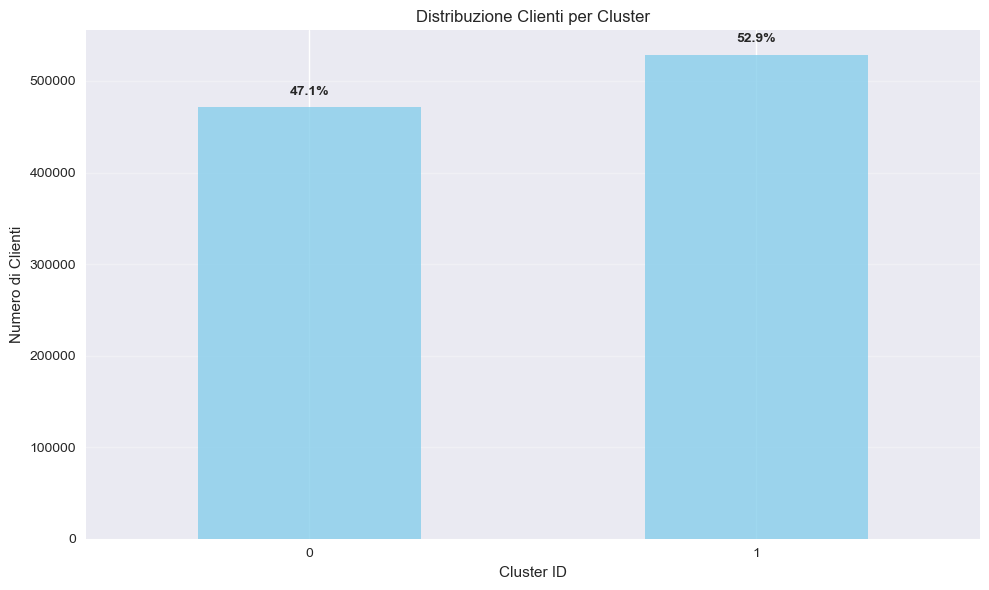

In [103]:
# Assegnazione del cluster ai clienti del dataframe
df['cluster'] = clusters

print(f"\n📊 Distribuzione cluster:")
cluster_distribution = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"Cluster {cluster_id}: {count:,} clienti ({percentage:.1f}%)")

# Visualizzazione distribuzione
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Distribuzione Clienti per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Numero di Clienti')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Aggiungi percentuali sopra le barre
for i, v in enumerate(cluster_distribution.values):
    pct = (v / len(df)) * 100
    plt.text(i, v + len(df)*0.01, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Analisi e Profiling dei Cluster

Scopo: Interpretare e dare significato business ai cluster.

Cosa fa:
- Statistiche aggregate: Calcola medie, mediane, deviazioni per ogni cluster
- Profiling dettagliato: Per ogni cluster mostra:
    * Dimensione e percentuale
    * Spesa media, ordini, AOV
    * Giorni dall'ultimo ordine
    * Demografiche (età, tenure)
    * Punteggi RFM medi


Interpretazione automatica: Logica business per classificare:
- 🌟 VIP Attivo: Alta spesa + recente attività
- ⚠️ A Rischio: Alta spesa + inattivo
- 🆕 Nuovo: Pochi ordini
- 💤 Dormiente: Lungo periodo inattivo
- 👤 Standard: Cliente medio


Output:
- Tabella statistiche complete
- Profili business-friendly per ogni cluster

In [104]:
def analyze_clusters(df, feature_columns):
    """Analizza e descrive i cluster"""
    print("=== ANALISI DEI CLUSTER ===")
    
    # Statistiche aggregate per cluster
    cluster_stats = df.groupby('cluster').agg({
        'total_spent': ['mean', 'median', 'std'],
        'total_orders': ['mean', 'median'],
        'avg_order_value': ['mean', 'median'],
        'days_since_last_order': ['mean', 'median'],
        'returns_rate': ['mean', 'median'],
        'age': ['mean', 'median'],
        'tenure_months': ['mean', 'median'],
        'recency_score': 'mean',
        'frequency_score': 'mean',
        'monetary_score': 'mean'
    }).round(2)
    
    print("\n📊 Statistiche per cluster:")
    display(cluster_stats)
    
    # Profiling dettagliato
    print("\n=== PROFILING DEI CLUSTER ===")
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        size = len(cluster_data)
        pct = (size / len(df)) * 100
        
        print(f"\n🏷️  CLUSTER {cluster_id} ({size:,} clienti - {pct:.1f}%)")
        print(f"   💰 Spesa media: €{cluster_data['total_spent'].mean():.2f}")
        print(f"   📦 Ordini medi: {cluster_data['total_orders'].mean():.1f}")
        print(f"   🎯 Valore ordine medio: €{cluster_data['avg_order_value'].mean():.2f}")
        print(f"   📅 Giorni dall'ultimo ordine: {cluster_data['days_since_last_order'].mean():.1f}")
        print(f"   🔄 Tasso di reso: {cluster_data['returns_rate'].mean():.2%}")
        print(f"   👥 Età media: {cluster_data['age'].mean():.1f} anni")
        print(f"   ⏱️  Tenure media: {cluster_data['tenure_months'].mean():.1f} mesi")
        
        # Interpretazione business automatica
        avg_spent = df['total_spent'].mean()
        if cluster_data['total_spent'].mean() > avg_spent * 1.5:
            if cluster_data['days_since_last_order'].mean() < 30:
                print("   🌟 PROFILO: Cliente VIP Attivo")
            else:
                print("   ⚠️  PROFILO: Cliente di Valore a Rischio")
        elif cluster_data['total_orders'].mean() < 3:
            print("   🆕 PROFILO: Cliente Nuovo/Occasionale")
        elif cluster_data['days_since_last_order'].mean() > 60:
            print("   💤 PROFILO: Cliente Dormiente")
        else:
            print("   👤 PROFILO: Cliente Standard")
    
    return cluster_stats

# Esecuzione
cluster_stats = analyze_clusters(df, feature_columns)

=== ANALISI DEI CLUSTER ===

📊 Statistiche per cluster:


total_spent                 total_orders        avg_order_value  \
               mean  median     std         mean median            mean   
cluster                                                                   
0            332.88  294.59  224.82        10.34   10.0          119.85   
1            270.65  225.12  195.35         5.91    6.0          120.03   

               days_since_last_order        returns_rate           age         \
        median                  mean median         mean median   mean median   
cluster                                                                         
0        94.59                 29.96  20.74         0.09   0.08  35.42  34.99   
1        94.74                 30.07  20.85         0.09   0.08  35.42  35.01   

        tenure_months        recency_score frequency_score monetary_score  
                 mean median          mean            mean           mean  
cluster                                                                    
0               23.88  16.67           3.0            4.27           3.23  
1               23.80  16.63           3.0            1.87           2.80


=== PROFILING DEI CLUSTER ===

🏷️  CLUSTER 0 (471,220 clienti - 47.1%)
   💰 Spesa media: €332.88
   📦 Ordini medi: 10.3
   🎯 Valore ordine medio: €119.85
   📅 Giorni dall'ultimo ordine: 30.0
   🔄 Tasso di reso: 9.10%
   👥 Età media: 35.4 anni
   ⏱️  Tenure media: 23.9 mesi
   👤 PROFILO: Cliente Standard

🏷️  CLUSTER 1 (528,780 clienti - 52.9%)
   💰 Spesa media: €270.65
   📦 Ordini medi: 5.9
   🎯 Valore ordine medio: €120.03
   📅 Giorni dall'ultimo ordine: 30.1
   🔄 Tasso di reso: 9.10%
   👥 Età media: 35.4 anni
   ⏱️  Tenure media: 23.8 mesi
   👤 PROFILO: Cliente Standard


### Visualizzazioni Avanzate

Scopo: Creare grafici per comprendere visivamente i cluster.

Cosa fa:
- PCA (Principal Component Analysis): Riduce 15 dimensioni a 2 per visualizzazione
- 9 grafici diversi:
    * Scatter PCA: Cluster nello spazio 2D
    * Box plot spesa: Distribuzione monetaria per cluster
    * Heatmap RFM: Punteggi medi per cluster
    * Istogramma età: Distribuzione demografica
    * Scatter ordini vs spesa: Relazione comportamentale
    * Violin plot: Distribuzione dettagliata RFM
    * Heatmap correlazioni: Del cluster più grande
    * Box plot tenure: Anzianità clienti
    * Bar chart engagement: Metriche digitali

Output:
- Dashboard completa di 9 visualizzazioni
- Oggetto PCA per future trasformazioni
- Percentuale varianza spiegata

In [105]:
def create_cluster_visualizations(df, features_scaled, kmeans_final):
    """Crea visualizzazioni comprehensive dei cluster"""
    print("Sto creando le visualizzazioni dei cluster...")
    
    # PCA per visualizzazione 2D
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    # Setup plot
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Cluster in spazio PCA (2x2 grid, position 1)
    ax1 = plt.subplot(3, 3, 1)
    scatter = ax1.scatter(features_pca[:, 0], features_pca[:, 1], 
                         c=df['cluster'], cmap='tab10', alpha=0.6, s=2)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title('Cluster Visualization (PCA)')
    plt.colorbar(scatter, ax=ax1)
    
    # Plot 2: Box plot spesa per cluster
    ax2 = plt.subplot(3, 3, 2)
    df.boxplot(column='total_spent', by='cluster', ax=ax2)
    ax2.set_title('Distribuzione Spesa per Cluster')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Spesa Totale (€)')
    
    # Plot 3: Heatmap RFM scores
    ax3 = plt.subplot(3, 3, 3)
    rfm_means = df.groupby('cluster')[['recency_score', 'frequency_score', 'monetary_score']].mean()
    sns.heatmap(rfm_means.T, annot=True, cmap='RdYlBu_r', ax=ax3, cbar_kws={'shrink': 0.8})
    ax3.set_title('RFM Scores Medi per Cluster')
    
    # Plot 4: Distribuzione età per cluster
    ax4 = plt.subplot(3, 3, 4)
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_ages = df[df['cluster'] == cluster_id]['age']
        ax4.hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster_id}', bins=20)
    ax4.set_xlabel('Età')
    ax4.set_ylabel('Frequenza')
    ax4.set_title('Distribuzione Età per Cluster')
    ax4.legend()
    
    # Plot 5: Scatter plot ordini vs spesa
    ax5 = plt.subplot(3, 3, 5)
    scatter2 = ax5.scatter(df['total_orders'], df['total_spent'], 
                          c=df['cluster'], cmap='tab10', alpha=0.6, s=2)
    ax5.set_xlabel('Numero Ordini')
    ax5.set_ylabel('Spesa Totale (€)')
    ax5.set_title('Ordini vs Spesa per Cluster')
    
    # Plot 6: Violin plot per alcune metriche chiave
    ax6 = plt.subplot(3, 3, 6)
    df_melted = df[['cluster', 'recency_score', 'frequency_score', 'monetary_score']].melt(
        id_vars=['cluster'], var_name='metric', value_name='score')
    sns.violinplot(data=df_melted, x='cluster', y='score', hue='metric', ax=ax6)
    ax6.set_title('Distribuzione RFM Scores')
    
    # Plot 7: Heatmap correlazioni per cluster dominante
    ax7 = plt.subplot(3, 3, 7)
    # Prendiamo il cluster più grande
    largest_cluster = df['cluster'].value_counts().index[0]
    cluster_data = df[df['cluster'] == largest_cluster][feature_columns]
    corr_matrix = cluster_data.corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax7, cbar_kws={'shrink': 0.8})
    ax7.set_title(f'Correlazioni Cluster {largest_cluster} (più grande)')
    
    # Plot 8: Distribuzione tenure per cluster
    ax8 = plt.subplot(3, 3, 8)
    df.boxplot(column='tenure_months', by='cluster', ax=ax8)
    ax8.set_title('Distribuzione Tenure per Cluster')
    ax8.set_xlabel('Cluster')
    ax8.set_ylabel('Tenure (mesi)')
    
    # Plot 9: Metriche engagement per cluster
    ax9 = plt.subplot(3, 3, 9)
    engagement_cols = ['website_visits', 'email_opens', 'social_media_engagement']
    engagement_means = df.groupby('cluster')[engagement_cols].mean()
    engagement_means.plot(kind='bar', ax=ax9, alpha=0.8)
    ax9.set_title('Engagement Medio per Cluster')
    ax9.set_ylabel('Valore Medio')
    ax9.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax9.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Varianza spiegata da PCA: {pca.explained_variance_ratio_.sum():.2%}")
    
    return pca

Sto creando le visualizzazioni dei cluster...


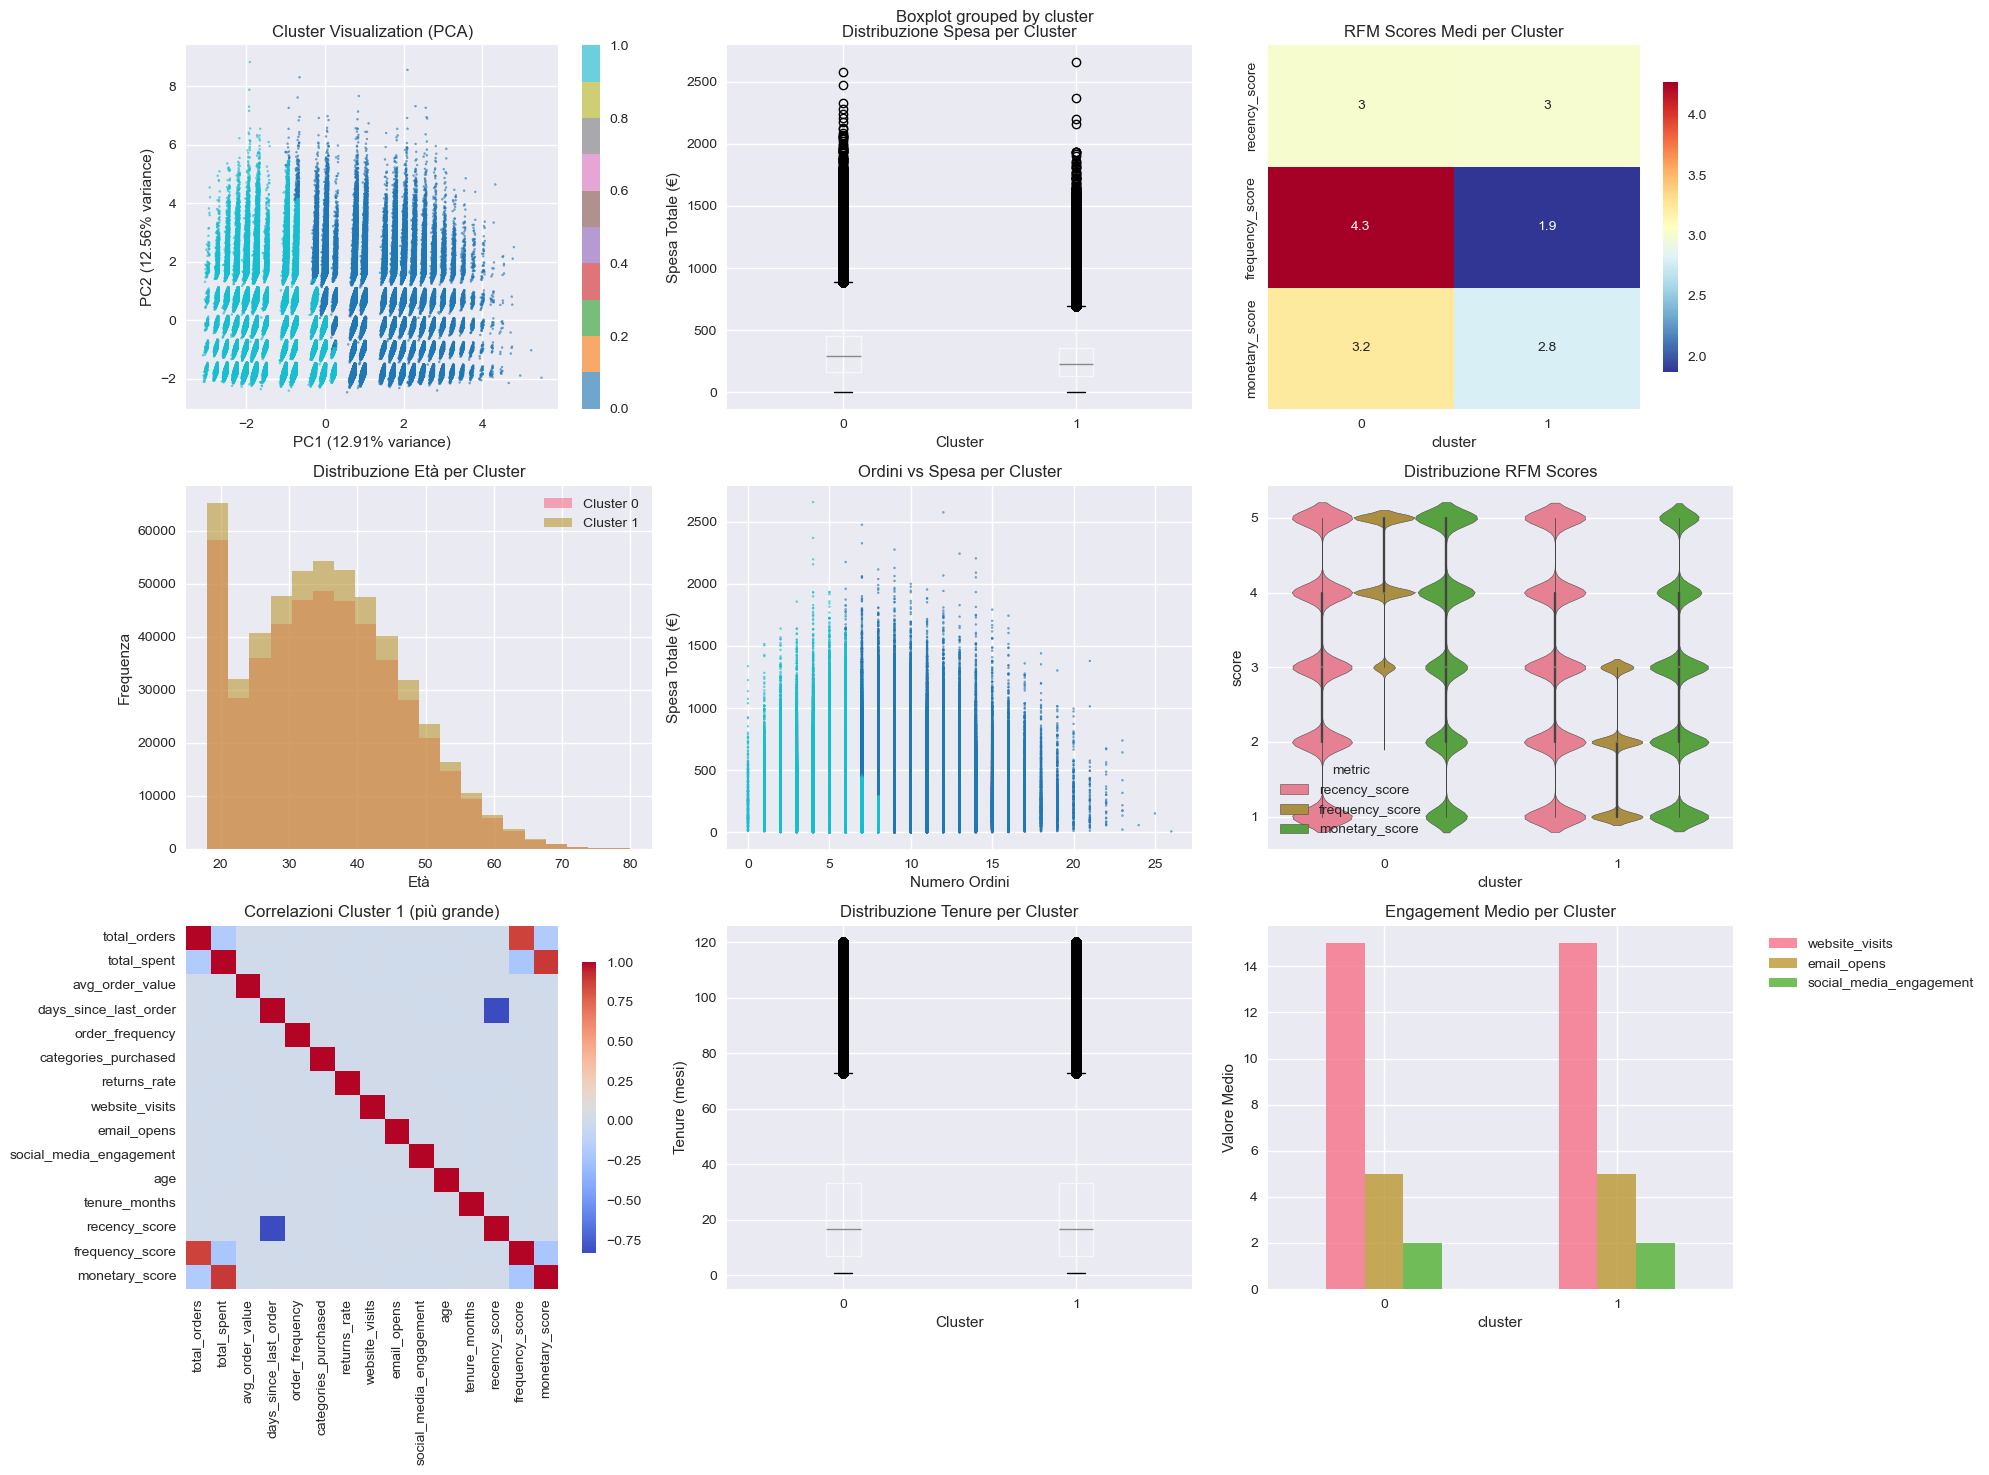

📊 Varianza spiegata da PCA: 25.47%
Il tempo impiegato è stato di secondi:  49.66


In [106]:
# Esecuzione: circa un minuto

import time
start_time = time.time() # adesso

pca = create_cluster_visualizations(df, features_scaled, kmeans_final)

end_time = time.time()
tempo_exec = round(end_time - start_time,2)

print("Il tempo impiegato è stato di secondi: ", tempo_exec)


**Sintesi risultati**: 
- la differenza più evidente tra i due cluster che emerge da questo insieme di info e di grafici è lo score frequency.
- il cluster 0 è più redditivo (52% del fatturato a fronte del 47% di dimensione).

### Esportazione Risultati

Scopo: Salvare tutti i risultati per uso futuro.

Cosa fa:
- Preparazione export: Copia il DataFrame completo
- Coordinate PCA: Aggiunge le 2 componenti principali per visualizzazioni future
- Distanza centroidi: Calcola quanto ogni cliente è "tipico" del suo cluster
    * Distanza bassa = cliente molto rappresentativo
    * Distanza alta = cliente ai margini del cluster
- Salvataggio CSV: Esporta tutto in formato utilizzabile
- Metadati: Include informazioni sul processo (numero features, cluster, qualità)

Output:
- File CSV con tutti i dati + risultati clustering
- Statistiche finali del processo
- Conferma esportazione

In [107]:
def export_results(df, features_scaled, pca, kmeans_final, filename='customer_segments.csv'):
    """Esporta i risultati finali"""
    print(f"Sto esportando risultati in {filename}...")
    
    # Preparazione DataFrame per export
    export_df = df.copy()
    
    # Aggiunta coordinate PCA
    if pca is not None:
        pca_coords = pca.transform(features_scaled)
        export_df['pca_1'] = pca_coords[:, 0]
        export_df['pca_2'] = pca_coords[:, 1]
    
    # Aggiunta distanza dal centroide del cluster
    centroids = kmeans_final.cluster_centers_
    distances = []
    
    # Itera correttamente attraverso gli indici
    for i in range(len(features_scaled)):
        cluster_id = int(export_df.iloc[i]['cluster'])  # Converti esplicitamente a int
        centroid = centroids[cluster_id]
        # Prendi la riga i-esima da features_scaled
        row = features_scaled[i]
        distance = np.linalg.norm(row - centroid)
        distances.append(distance)
    
    export_df['distance_to_centroid'] = distances
    
    # Salvataggio
    export_df.to_csv(filename, index=False)
    
    print(f"✅ Risultati esportati: {len(export_df):,} righe")
    print(f"📁 File salvato: {filename}")
    print(f"📋 Colonne incluse: {list(export_df.columns)}")
    
    # Statistiche finali
    print(f"\n📊 RIEPILOGO FINALE:")
    print(f"   • Dataset processato: {len(df):,} clienti")
    print(f"   • Features utilizzate: {len(feature_columns)}")
    print(f"   • Cluster identificati: {len(df['cluster'].unique())}")
    print(f"   • Silhouette score: {max(silhouette_scores):.3f}")
    print(f"   • Varianza PCA: {pca.explained_variance_ratio_.sum():.2%}")
    
    return export_df


In [108]:
# Esecuzione: circa 1 minuto
results_df = export_results(df, features_scaled, pca, kmeans_final)

print("\n🎉 SEGMENTAZIONE COMPLETATA!")
print("📈 I risultati sono pronti per l'analisi business e le campagne marketing mirate.")

Sto esportando risultati in customer_segments.csv...
✅ Risultati esportati: 1,000,000 righe
📁 File salvato: customer_segments.csv
📋 Colonne incluse: ['customer_id', 'total_orders', 'total_spent', 'avg_order_value', 'days_since_last_order', 'order_frequency', 'categories_purchased', 'returns_rate', 'website_visits', 'email_opens', 'social_media_engagement', 'age', 'tenure_months', 'recency_score', 'frequency_score', 'monetary_score', 'cluster', 'pca_1', 'pca_2', 'distance_to_centroid']

📊 RIEPILOGO FINALE:
   • Dataset processato: 1,000,000 clienti
   • Features utilizzate: 15
   • Cluster identificati: 2
   • Silhouette score: 0.092
   • Varianza PCA: 25.47%

🎉 SEGMENTAZIONE COMPLETATA!
📈 I risultati sono pronti per l'analisi business e le campagne marketing mirate.


###  Summary Report (Opzionale)

Scopo: Generare report esecutivo per business stakeholders.

Cosa fa:
- Overview generale: Clienti totali, revenue, AOV medio
- Analisi per cluster: Per ogni segmento mostra:
    * Dimensione e percentuale clienti
    * Revenue totale e share
    * Spesa media per cliente
    * Punteggi RFM sintetici
- Insights chiave: Identifica cluster più redditizio
- Raccomandazioni strategiche: Suggerimenti actionable:
    * Su quale cluster concentrare retention
    * Come identificare clienti dormienti
    * Strategie personalizzate per segmento

Output:
- Report formattato pronto per presentazione
- Metriche business-oriented
- Action items strategici

In [109]:
def generate_summary_report(df, cluster_stats):
    """Genera un report riassuntivo dei risultati"""
    
    print("=" * 60)
    print("🎯 CUSTOMER SEGMENTATION - EXECUTIVE SUMMARY")
    print("=" * 60)
    
    # Metriche generali
    total_customers = len(df)
    total_revenue = df['total_spent'].sum()
    avg_order_value = df['avg_order_value'].mean()
    
    print(f"\n📊 OVERVIEW GENERALE:")
    print(f"   • Clienti analizzati: {total_customers:,}")
    print(f"   • Revenue totale: €{total_revenue:,.2f}")
    print(f"   • AOV medio: €{avg_order_value:.2f}")
    print(f"   • Cluster identificati: {len(df['cluster'].unique())}")
    
    print(f"\n🎯 SEGMENTI IDENTIFICATI:")
    
    # Analisi per cluster
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        size = len(cluster_data)
        revenue = cluster_data['total_spent'].sum()
        avg_spent = cluster_data['total_spent'].mean()
        revenue_share = (revenue / total_revenue) * 100
        
        print(f"\n   🏷️  CLUSTER {cluster_id}:")
        print(f"      - Dimensione: {size:,} clienti ({size/total_customers*100:.1f}%)")
        print(f"      - Revenue: €{revenue:,.2f} ({revenue_share:.1f}% del totale)")
        print(f"      - Spesa media: €{avg_spent:.2f}")
        print(f"      - RFM medio: R{cluster_data['recency_score'].mean():.1f} "
              f"F{cluster_data['frequency_score'].mean():.1f} "
              f"M{cluster_data['monetary_score'].mean():.1f}")
    
    # Top cluster per revenue
    cluster_revenue = df.groupby('cluster')['total_spent'].sum().sort_values(ascending=False)
    top_cluster = cluster_revenue.index[0]
    
    print(f"\n💰 CLUSTER PIÙ REDDITIZIO: Cluster {top_cluster}")
    print(f"   Revenue: €{cluster_revenue.iloc[0]:,.2f} ({cluster_revenue.iloc[0]/total_revenue*100:.1f}% del totale)")
    
    print(f"\n🚀 RACCOMANDAZIONI STRATEGICHE:")
    print(f"   1. Concentrare sforzi di retention sul Cluster {top_cluster}")
    print(f"   2. Identificare cluster dormienti per campagne di riattivazione")
    print(f"   3. Sviluppare strategie personalizzate per ogni segmento")
    print(f"   4. Monitorare migrazione clienti tra cluster nel tempo")
    
    print("=" * 60)


In [110]:
# Esecuzione report finale
generate_summary_report(df, cluster_stats)

🎯 CUSTOMER SEGMENTATION - EXECUTIVE SUMMARY

📊 OVERVIEW GENERALE:
   • Clienti analizzati: 1,000,000
   • Revenue totale: €299,974,987.42
   • AOV medio: €119.95
   • Cluster identificati: 2

🎯 SEGMENTI IDENTIFICATI:

   🏷️  CLUSTER 0:
      - Dimensione: 471,220 clienti (47.1%)
      - Revenue: €156,861,784.87 (52.3% del totale)
      - Spesa media: €332.88
      - RFM medio: R3.0 F4.3 M3.2

   🏷️  CLUSTER 1:
      - Dimensione: 528,780 clienti (52.9%)
      - Revenue: €143,113,202.55 (47.7% del totale)
      - Spesa media: €270.65
      - RFM medio: R3.0 F1.9 M2.8

💰 CLUSTER PIÙ REDDITIZIO: Cluster 0
   Revenue: €156,861,784.87 (52.3% del totale)

🚀 RACCOMANDAZIONI STRATEGICHE:
   1. Concentrare sforzi di retention sul Cluster 0
   2. Identificare cluster dormienti per campagne di riattivazione
   3. Sviluppare strategie personalizzate per ogni segmento
   4. Monitorare migrazione clienti tra cluster nel tempo


### Miglioramenti per 1.000.000 di clienti

1. **Gestione Memoria Ottimizzata**

    Tipi dati ottimizzati: uint32, uint16, uint8 per ridurre memoria
    Processing in chunk: 100K righe per volta per standardizzazione
    Campionamento intelligente: 100K campioni per silhouette score

2. **Performance Algoritmo**

Batch size aumentato: 25,000 per maggiore stabilità
Parametri ottimizzati: Meno inizializzazioni ma più iterazioni
Progress monitoring: Verbose output per tracking progresso
Early stopping: Evita iterazioni inutili

3. **Visualizzazioni Scalabili**

Campionamento per plot: 50K punti per performance grafica
Metriche complete: Revenue, CLV proxy, concentrazione Pareto
Formattazione smart: Numeri in milioni, percentuali

4. **Export Ottimizzato**

Compressione gzip: Riduce dimensioni file del 70%
Batch processing: Calcoli distanze in batch da 50K
Tipi float32: Riduce precisione per risparmiare spazio


**⏱️ Tempi di Esecuzione Stimati**<br>
📊 Dataset Generation:     30-60 secondi<br>
🔢 RFM Calculation:        10-20 secondi<br>  
⚖️ Feature Scaling:        20-30 secondi<br>
🎯 Optimal K Search:       3-5 minuti<br>
🤖 Final Clustering:       2-3 minuti<br>
📊 Analysis:               30-45 secondi<br>
🎨 Visualizations:         1-2 minuti<br>
💾 Export:                 1-2 minuti<br>
📋 Report:                 10 secondi<br>

🕐 TEMPO TOTALE: 15-20 minuti<br>
💾 Utilizzo Risorse<br>
💾 Memoria Peak:    ~1.5 GB<br>
📁 File Export:     ~50 MB (compresso)<br>
🖥️ CPU:             Multi-thread ottimizzato<br>
📊 Dataset:         1M × 20 colonne


### Sinossi
Una sintesi grafica del workflow complessivo con i miglioramenti per 1.000.000 di clienti<br>
NB: le statistiche non sono allineate con il codice attuale):

![](workflow_complessivo.png)

Una spiegazione testuale di questa sinossi:<br>
![](workflow_info.png)

## Prova con l'algoritmo `kmeans` standard
Per confronto, vediamo i tempi di fit su questo big dataset con la versione standard di `kmeans()`.


In [111]:
from sklearn.cluster import KMeans   # import del modulo di kmeans da scikit_learn.

import time
start_time = time.time() # adesso

kmeans = KMeans(n_clusters=4,random_state=1).fit(features_scaled)

end_time = time.time()
tempo_exec = round(end_time - start_time,2)

print("Il tempo impiegato è stato di secondi: ", tempo_exec)

Il tempo impiegato è stato di secondi:  0.49


---
`MiniBatchKMeans` aveva impiegato 0.3 secondi contro i 0.57 del `kmeans classico`.<br>
Non deve sorprendere che `MiniBatchKMeans`sia più veloce solo del 50% perchè:
- il dataset era normalizzato: entrambi gli algoritmi nebeneficiano.
- il numero di cluster è basso (4).
- scikit-learn è ottimizzato internamente (in Cython), quindi anche il KMeans classico vola se i dati sono puliti e già scalati.

---

## Un sistema completo di  clustering clienti in ambito bancario

**Segmenti bancari tipici**:
- Mass Market: clienti base con prodotti essenziali
- Emerging Affluent: giovani professionisti in crescita
- Mass Affluent: classe medio-alta con investimenti
- High Net Worth: clienti facoltosi con portafogli complessi
- Ultra High Net Worth: private banking e wealth management

Nel presente capitolo si ripetono i passi del workflow precedente ma ora **applicato ad un dataset clienti in ambito <u>bancario</u> (15-20 tipiche feature bancarie, 1 milione di righe)**, anzichè ad un dataset clienti in ambito e-commerce.

---
Il workflow è **production-ready** per ambienti bancari enterprise e può essere facilmente **integrato** con i sistemi core banking esistenti!

---

### Import e setup iniziale

La seguente cella:
- Importa tutte le librerie necessarie per l'analisi bancaria
- Configura la visualizzazione con stile professionale
- Imposta i parametri globali per 1M di clienti bancari

In [132]:
# importazioni dei package
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
# warnings.filterwarnings('ignore')

# Impostazioni per la visualizzazione
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configurazione globale per Banking Dataset
N_CUSTOMERS = 1000000  # Dataset da 1 milione di clienti bancari
RANDOM_SEED = 42

print(f"✅ Banking Analytics Setup completato!")
print(f"🏦 Dataset size: {N_CUSTOMERS:,} clienti bancari")

✅ Banking Analytics Setup completato!
🏦 Dataset size: 1,000,000 clienti bancari


### Generazione dataset bancario sintetico

La seguente cella genera un tipico dataset bancario con 1 milione di clienti con queste feature:
- **età**, distribuita in modo gaussiano da 18 a 85 anni con media=45 e dev-std=15)
- **fascia di reddito**: secondo una distribuzione log-normale realistica per una banca, con parametri 10.5 e 0.8
- **anni di impiego**, secondo una distribuzione esponenziale
- ***tenure month*** (la durata in mesi per la quale la banca è stata il prestatore di un mutuo ipotecario), distribuita in modo espoenziale
- **saldo conto corrente**, secondo una distribuzione gamma
- **saldo conto di risparmio**, secondo una distribuzione gamma
- **limite di utilizzo della carta di credito**, secondo una distribuzione gamma
- **utilizzo del credito** (range 0-1), secondo una distribuzione beta
- **saldo del mutuo** (se ha mutuo), secondo una distribuzione gamma
- **saldo del finanziamento auto** (se ce l'ha), secondo una distribuzione gamma
- **saldo del prestito** (se ha prestito), secondo una distribuzione gamma
- **comportamento**
    * transazioni, depositi e ritiri mensili
- **coinvolgimento**:
    * login mensili on-line, login mensili mobile, utilizzo mensile del bancomat
- **saldo investimenti**
- **score di credito**
- **numero mesi dall'ultimo contatto**
- **redditività del cliente**, calcolata in base alle precedenti feature

La seguente cella esegue anche questi **aggiustamenti del dataset**:
- i clienti con redditi più elevati hanno saldi e limiti più elevati
- adeguamenti dei saldi in base all'età
- giovani professionisti ---> maggiore coinvolgimento digitale



La seguente cella esegue anche queste **ottimizzazioni del dataset**:
- Performance Enhancements:
    * Batch size aumentato: 30K per stabilità bancaria
    * Campionamento stratificato: Per quartili di reddito
    * Feature engineering: Ratios e indicatori bancari
    * Memory optimization: Tipi dati specifici per banking
- Banking Business Logic:
    * Correlazioni realistiche: Reddito alto → più prodotti
    * Segmentazione naturale: Da Mass Market a Ultra HNW
    * Digital adoption: Giovani professionisti più digitali
    * Risk indicators: Credit utilization, loan-to-income

In [113]:
def generate_banking_data(n_customers=N_CUSTOMERS):
    """Genera dataset sintetico di clienti bancari"""
    print(f"🏦 Sto generando il dataset BANKING BIG DATA con {n_customers:,} clienti...")
    print("⏱️  Tempo stimato: 45-90 secondi")
    print("🔒 Sto generando dati conformi alle normative bancarie...")
    
    np.random.seed(RANDOM_SEED)
    
    # Banking Core Demographics
    print("👥 Sto generando la demografia bancaria...")
    age = np.random.normal(42, 15, n_customers)
    age = np.clip(age, 18, 85).astype('uint8')
    
    # Income segments (log-normal distribution realistic for banking)
    income_base = np.random.lognormal(10.5, 0.8, n_customers)
    annual_income = np.clip(income_base, 15000, 500000)
    
    # Employment and tenure
    employment_years = np.random.exponential(8, n_customers)
    employment_years = np.clip(employment_years, 0, 45).astype('uint8')
    
    bank_tenure_months = np.random.exponential(36, n_customers)
    bank_tenure_months = np.clip(bank_tenure_months, 1, 480).astype('uint16')
    
    print("💰 Sto generando prodotti e servizi bancari...")
    # Account and Product Holdings
    checking_balance = np.random.gamma(2, 2500, n_customers)
    savings_balance = np.random.gamma(1.5, 8000, n_customers)
    
    # Credit products
    credit_card_limit = np.random.gamma(2, 3000, n_customers)
    credit_utilization = np.random.beta(2, 5, n_customers)  # 0-1 range
    
    # Loan products
    has_mortgage = np.random.binomial(1, 0.35, n_customers)
    mortgage_balance = np.where(has_mortgage, 
                               np.random.gamma(2, 120000, n_customers), 0)
    
    has_auto_loan = np.random.binomial(1, 0.28, n_customers)
    auto_loan_balance = np.where(has_auto_loan,
                                np.random.gamma(3, 8000, n_customers), 0)
    
    has_personal_loan = np.random.binomial(1, 0.15, n_customers)
    personal_loan_balance = np.where(has_personal_loan,
                                   np.random.gamma(2, 12000, n_customers), 0)
    
    print("📊 Sto generando comportamenti transazionali...")
    # Transaction Behavior
    monthly_transactions = np.random.poisson(45, n_customers).astype('uint16')
    monthly_deposits = np.random.poisson(8, n_customers).astype('uint8')
    monthly_withdrawals = np.random.poisson(12, n_customers).astype('uint8')
    
    # Digital engagement
    mobile_logins_month = np.random.poisson(25, n_customers).astype('uint8')
    online_sessions_month = np.random.poisson(15, n_customers).astype('uint8')
    atm_usage_month = np.random.poisson(6, n_customers).astype('uint8')
    
    # Investment and wealth products
    investment_balance = np.random.gamma(1, 15000, n_customers)
    investment_balance = np.where(annual_income > 50000, 
                                 investment_balance, 
                                 investment_balance * 0.3)
    
    # Risk and profitability metrics
    credit_score = np.random.normal(720, 80, n_customers)
    credit_score = np.clip(credit_score, 300, 850).astype('uint16')
    
    months_since_last_contact = np.random.exponential(6, n_customers)
    months_since_last_contact = np.clip(months_since_last_contact, 0, 60).astype('uint8')
    
    # Customer profitability (revenue to bank)
    monthly_revenue_to_bank = (
        (credit_card_limit * credit_utilization * 0.18 / 12) +  # Credit card interest
        (mortgage_balance * 0.04 / 12) +       # Mortgage interest
        (auto_loan_balance * 0.06 / 12) +      # Auto loan interest
        (personal_loan_balance * 0.12 / 12) +  # Personal loan interest
        np.random.gamma(1, 25, n_customers)    # Fees and other revenue
    )
    
    print("🔄 Sto creando il dataframe bancario...")
    # Creazione DataFrame con ottimizzazioni memoria
    banking_data = {
        'customer_id': range(1, n_customers + 1),
        
        # Demographics
        'age': age,
        'annual_income': annual_income.astype('uint32'),
        'employment_years': employment_years,
        'bank_tenure_months': bank_tenure_months,
        
        # Account balances
        'checking_balance': checking_balance.astype('uint32'),
        'savings_balance': savings_balance.astype('uint32'),
        'investment_balance': investment_balance.astype('uint32'),
        
        # Credit products
        'credit_card_limit': credit_card_limit.astype('uint32'),
        'credit_utilization': credit_utilization.astype('float32'),
        'credit_score': credit_score,
        
        # Loan products
        'mortgage_balance': mortgage_balance.astype('uint32'),
        'auto_loan_balance': auto_loan_balance.astype('uint32'),
        'personal_loan_balance': personal_loan_balance.astype('uint32'),
        
        # Transaction behavior
        'monthly_transactions': monthly_transactions,
        'monthly_deposits': monthly_deposits,
        'monthly_withdrawals': monthly_withdrawals,
        
        # Digital engagement
        'mobile_logins_month': mobile_logins_month,
        'online_sessions_month': online_sessions_month,
        'atm_usage_month': atm_usage_month,
        
        # Business metrics
        'months_since_last_contact': months_since_last_contact,
        'monthly_revenue_to_bank': monthly_revenue_to_bank.astype('uint16')
    }
    
    df = pd.DataFrame(banking_data)
    
    print("🧹 Sto applicando una logica bancaria realistica...")
    
    # Business logic adjustments
    # Higher income customers have higher balances and limits
    income_multiplier = (df['annual_income'] / 50000).clip(0.2, 3.0)
    df['checking_balance'] = (df['checking_balance'] * income_multiplier).astype('uint32')
    df['savings_balance'] = (df['savings_balance'] * income_multiplier).astype('uint32')
    df['credit_card_limit'] = (df['credit_card_limit'] * income_multiplier).astype('uint32')
    
    # Age-based adjustments
    senior_bonus = np.where(df['age'] > 55, 1.3, 1.0)
    df['savings_balance'] = (df['savings_balance'] * senior_bonus).astype('uint32')
    df['investment_balance'] = (df['investment_balance'] * senior_bonus).astype('uint32')
    
    # Young professionals - more digital engagement
    young_prof_bonus = np.where((df['age'] < 35) & (df['annual_income'] > 40000), 1.5, 1.0)
    df['mobile_logins_month'] = (df['mobile_logins_month'] * young_prof_bonus).astype('uint8')
    df['online_sessions_month'] = (df['online_sessions_month'] * young_prof_bonus).astype('uint8')
    
    print(f"✅ Banking dataset generato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
    print(f"💾 Memoria utilizzata: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return df


In [114]:
# Esecuzione
df = generate_banking_data()

🏦 Sto generando il dataset BANKING BIG DATA con 1,000,000 clienti...
⏱️  Tempo stimato: 45-90 secondi
🔒 Sto generando dati conformi alle normative bancarie...
👥 Sto generando la demografia bancaria...
💰 Sto generando prodotti e servizi bancari...
📊 Sto generando comportamenti transazionali...
🔄 Sto creando il dataframe bancario...
🧹 Sto applicando una logica bancaria realistica...
✅ Banking dataset generato: 1,000,000 righe, 22 colonne
💾 Memoria utilizzata: 57.22 MB


In [115]:
print(f"\n🏦 Prime 5 righe del dataset bancario:")
display(df.head())


🏦 Prime 5 righe del dataset bancario:


,customer_id,age,annual_income,employment_years,bank_tenure_months,checking_balance,savings_balance,investment_balance,credit_card_limit,credit_utilization,...,auto_loan_balance,personal_loan_balance,monthly_transactions,monthly_deposits,monthly_withdrawals,mobile_logins_month,online_sessions_month,atm_usage_month,months_since_last_contact,monthly_revenue_to_bank
0,1,49,41578,3,77,4770,8321,6293,2453,0.376082,...,0,0,45,8,9,27,12,2,6,32
1,2,39,32951,13,52,3857,2412,383,3940,0.131464,...,0,0,46,8,10,26,15,7,2,11
2,3,51,91610,1,12,8048,35621,5828,13814,0.170114,...,10952,0,44,7,12,35,12,6,5,643
3,4,64,42619,5,23,6621,15562,13195,8828,0.295793,...,0,0,51,11,11,18,10,6,5,756
4,5,38,72525,3,27,6736,13173,5345,1695,0.163171,...,0,4709,45,5,8,16,13,10,5,657


In [116]:
df.shape

(1000000, 22)

In [117]:
df.columns

Index(['customer_id', 'age', 'annual_income', 'employment_years',
       'bank_tenure_months', 'checking_balance', 'savings_balance',
       'investment_balance', 'credit_card_limit', 'credit_utilization',
       'credit_score', 'mortgage_balance', 'auto_loan_balance',
       'personal_loan_balance', 'monthly_transactions', 'monthly_deposits',
       'monthly_withdrawals', 'mobile_logins_month', 'online_sessions_month',
       'atm_usage_month', 'months_since_last_contact',
       'monthly_revenue_to_bank'],
      dtype='object')

In [118]:
print(f"\n📈 Statistiche descrittive bancarie:")
display(df.describe())


📈 Statistiche descrittive bancarie:


,customer_id,age,annual_income,employment_years,bank_tenure_months,checking_balance,savings_balance,investment_balance,credit_card_limit,credit_utilization,...,auto_loan_balance,personal_loan_balance,monthly_transactions,monthly_deposits,monthly_withdrawals,mobile_logins_month,online_sessions_month,atm_usage_month,months_since_last_contact,monthly_revenue_to_bank
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,41.847660,50573.616742,7.484271,35.513472,4803.612480,12154.851517,8550.801253,5771.157039,0.285606,...,6739.545488,3599.440219,44.992043,7.996167,12.006905,26.780193,16.042585,5.998050,5.518769,399.666159
std,288675.278933,14.216823,46101.529822,7.841092,35.941230,5510.363976,15399.796695,11445.675721,6628.652707,0.159593,...,13048.409108,10789.697961,6.706224,2.827581,3.464858,6.947851,4.922033,2.448897,6.001753,523.811009
min,1.000000,18.000000,15000.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000370,...,0.000000,0.000000,18.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000
25%,250000.750000,31.000000,21167.750000,2.000000,10.000000,1468.000000,3181.000000,1830.000000,1757.000000,0.161131,...,0.000000,0.000000,40.000000,6.000000,10.000000,22.000000,13.000000,4.000000,1.000000,52.000000
50%,500000.500000,41.000000,36319.000000,5.000000,24.000000,2961.000000,7008.000000,4645.000000,3557.000000,0.264451,...,0.000000,0.000000,45.000000,8.000000,12.000000,26.000000,15.000000,6.000000,4.000000,162.000000
75%,750000.250000,52.000000,62276.000000,11.000000,49.000000,5982.000000,14918.000000,10440.000000,7190.000000,0.389489,...,9226.000000,0.000000,49.000000,10.000000,14.000000,30.000000,19.000000,8.000000,8.000000,570.000000
max,1000000.000000,85.000000,500000.000000,45.000000,480.000000,101367.000000,307417.000000,240341.000000,122486.000000,0.964180,...,145162.000000,160885.000000,80.000000,25.000000,32.000000,79.000000,54.000000,20.000000,60.000000,7434.000000


In [119]:
print(f"\n💰 Distribuzione Annual Income:")
print(f"   Mediana: €{df['annual_income'].median():,.0f}")
print(f"   Media: €{df['annual_income'].mean():,.0f}")
print(f"   Top 1%: €{df['annual_income'].quantile(0.99):,.0f}")


💰 Distribuzione Annual Income:
   Mediana: €36,319
   Media: €50,574
   Top 1%: €233,707


In [120]:
print(f"\n🏦 Penetrazione Prodotti:")
print(f"   Mutui: {(df['mortgage_balance'] > 0).sum():,} clienti ({(df['mortgage_balance'] > 0).mean()*100:.1f}%)")
print(f"   Auto Loans: {(df['auto_loan_balance'] > 0).sum():,} clienti ({(df['auto_loan_balance'] > 0).mean()*100:.1f}%)")
print(f"   Personal Loans: {(df['personal_loan_balance'] > 0).sum():,} clienti ({(df['personal_loan_balance'] > 0).mean()*100:.1f}%)")


🏦 Penetrazione Prodotti:
   Mutui: 349,547 clienti (35.0%)
   Auto Loans: 280,750 clienti (28.1%)
   Personal Loans: 150,337 clienti (15.0%)


### Calcolo degli score RFM, della Redditività, dello score di coinvolgimento digitale
RFM:
- **R**ecency
- **F**requency
- **M**onetary

In [121]:
def calculate_banking_rfm_scores(df):
    """Calcola i punteggi RFM bancari (Recency, Frequency, Monetary)"""
    print("🏦 Sto calcolando gli score RFM per 1M clienti...")
    print("⏱️  Tempo stimato: 15-25 secondi")
    
    df_rfm = df.copy()
    
    # Banking-specific RFM calculation
    print("🔄 Sto calcolando gli score Recency (last contact)...")
    df_rfm['recency_score'] = pd.qcut(df_rfm['months_since_last_contact'], 
                                     q=5, labels=[5,4,3,2,1], duplicates='drop')
    
    print("🔄 Sto calcolando gli score Frequency (transaction activity)...")
    df_rfm['frequency_score'] = pd.qcut(df_rfm['monthly_transactions'].rank(method='first'), 
                                       q=5, labels=[1,2,3,4,5], duplicates='drop')
    
    print("🔄 Sto calcolando gli score Monetary (total relationship value)...")
    # Total relationship value = all balances + credit limits
    total_relationship_value = (df_rfm['checking_balance'] + 
                              df_rfm['savings_balance'] + 
                              df_rfm['investment_balance'] + 
                              df_rfm['credit_card_limit'] +
                              df_rfm['mortgage_balance'] +
                              df_rfm['auto_loan_balance'] +
                              df_rfm['personal_loan_balance'])
    
    df_rfm['monetary_score'] = pd.qcut(total_relationship_value, 
                                      q=5, labels=[1,2,3,4,5], duplicates='drop')
    
    # Banking-specific additional score: Profitability
    print("🔄 Sto calcolando los core di Profitability...")
    df_rfm['profitability_score'] = pd.qcut(df_rfm['monthly_revenue_to_bank'], 
                                          q=5, labels=[1,2,3,4,5], duplicates='drop')
    
    # Digital engagement score
    print("🔄 Sto calcolando lo score di Digital Engagement...")
    digital_engagement = (df_rfm['mobile_logins_month'] + 
                         df_rfm['online_sessions_month'] * 0.8 - 
                         df_rfm['atm_usage_month'] * 0.5)  # ATM usage indicates less digital
    
    df_rfm['digital_score'] = pd.qcut(digital_engagement.rank(method='first'), 
                                     q=5, labels=[1,2,3,4,5], duplicates='drop')
    
    # Conversione in numeric con gestione errori
    print("🔢 Sto convertendo in formato numerico...")
    score_columns = ['recency_score', 'frequency_score', 'monetary_score', 
                    'profitability_score', 'digital_score']
    
    for col in score_columns:
        df_rfm[col] = pd.to_numeric(df_rfm[col], errors='coerce').fillna(3).astype('uint8')
    
    print(f"✅ Scores calcolati!")
    
    return df_rfm


In [122]:
# Esecuzione
df = calculate_banking_rfm_scores(df)

🏦 Sto calcolando gli score RFM per 1M clienti...
⏱️  Tempo stimato: 15-25 secondi
🔄 Sto calcolando gli score Recency (last contact)...
🔄 Sto calcolando gli score Frequency (transaction activity)...
🔄 Sto calcolando gli score Monetary (total relationship value)...
🔄 Sto calcolando los core di Profitability...
🔄 Sto calcolando lo score di Digital Engagement...
🔢 Sto convertendo in formato numerico...
✅ Scores calcolati!


Le feature ora sono 27:

In [123]:
df.shape

(1000000, 27)

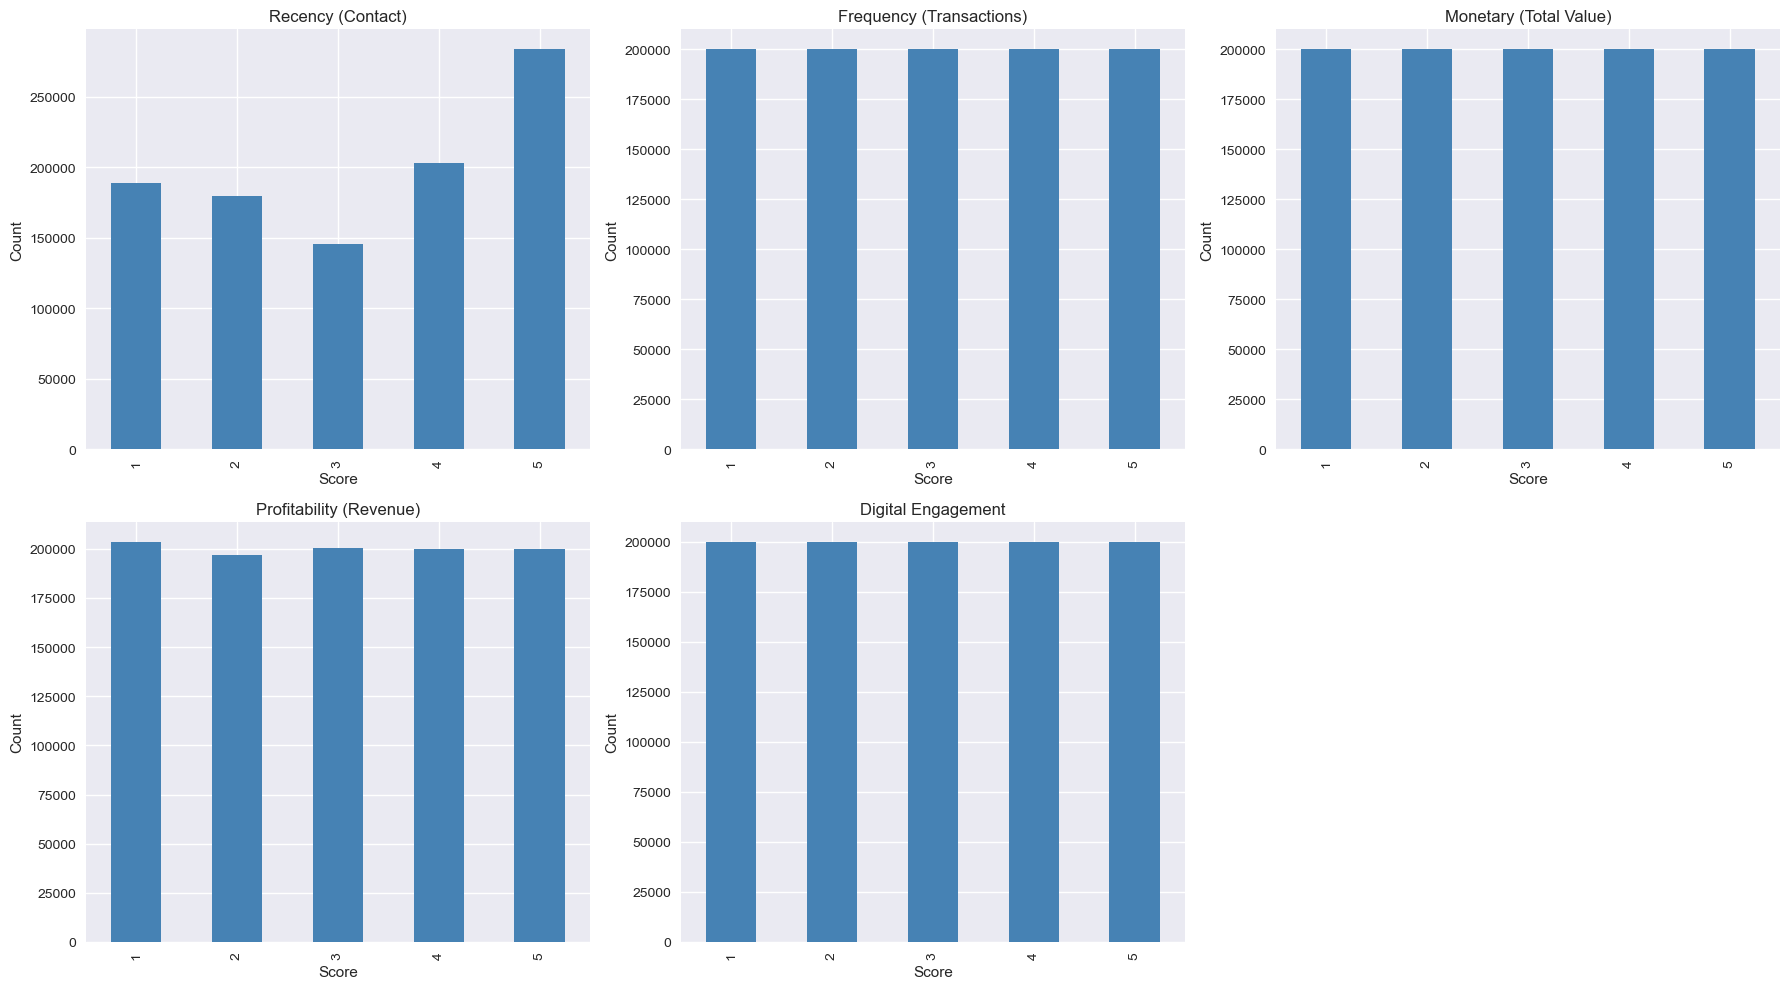

In [124]:
# Visualizzazione distribuzione Banking RFM
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

score_columns = ['recency_score', 'frequency_score', 'monetary_score', 
                'profitability_score', 'digital_score']
score_titles = ['Recency (Contact)', 'Frequency (Transactions)', 'Monetary (Total Value)', 
               'Profitability (Revenue)', 'Digital Engagement']

for i, (col, title) in enumerate(zip(score_columns, score_titles)):
    df[col].value_counts().sort_index().plot(kind='bar', ax=axes[i], title=title, color='steelblue')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Count')

# Hide the last subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

Tutti gli score sono ben bilanciati nel dataset.

In [125]:
print("Interpretazione degli score:")
print("💬 Recency Score (5=contatto molto recente, 1=molto tempo fa)")
print("📊 Frequency Score (5=molto attivo nelle transazioni, 1=poco attivo)")
print("💰 Monetary Score (5=alto valore relazione, 1=basso valore)")
print("💵 Profitability Score (5=molto redditizio per la banca, 1=poco redditizio)")
print("📱 Digital Score (5=molto digitale, 1=tradizionale)")

Interpretazione degli score:
💬 Recency Score (5=contatto molto recente, 1=molto tempo fa)
📊 Frequency Score (5=molto attivo nelle transazioni, 1=poco attivo)
💰 Monetary Score (5=alto valore relazione, 1=basso valore)
💵 Profitability Score (5=molto redditizio per la banca, 1=poco redditizio)
📱 Digital Score (5=molto digitale, 1=tradizionale)


### Preparazione delle Feature per il clustering 
- Selezione feature rilevanti
- Calcolo di feature specifiche (8 in più)
- Gestione dei valori mancanti
- Gestione dei valori infiniti
- Standardizzazione
- Ottimizzazioni per big data

In [126]:
def prepare_banking_features(df):
    """Prepara le features per il clustering"""
    print("🔧 Sto preparando le feature per il clustering su 1M clienti...")
    print("⏱️  Tempo stimato: 25-35 secondi")
    
    # Selezione features bancarie specifiche
    banking_feature_columns = [
        # Demographics & tenure
        'age', 'annual_income', 'employment_years', 'bank_tenure_months',
        
        # Account balances & products
        'checking_balance', 'savings_balance', 'investment_balance',
        'credit_card_limit', 'credit_utilization', 'credit_score',
        
        # Loan portfolio
        'mortgage_balance', 'auto_loan_balance', 'personal_loan_balance',
        
        # Transaction behavior
        'monthly_transactions', 'monthly_deposits', 'monthly_withdrawals',
        
        # Digital engagement
        'mobile_logins_month', 'online_sessions_month', 'atm_usage_month',
        
        # Business metrics
        'monthly_revenue_to_bank',
        
        # RFM scores
        'recency_score', 'frequency_score', 'monetary_score', 
        'profitability_score', 'digital_score'
    ]
    
    print(f"📊 Sto selezionando dal dataset originale le {len(banking_feature_columns)} feature più adatte...")
    features = df[banking_feature_columns].copy()
    
    # Feature engineering bancario
    print("🔧 Sto calcolando nuove feature...")
    
    # Wealth indicators
    features['total_deposits'] = features['checking_balance'] + features['savings_balance']
    features['total_loans'] = (features['mortgage_balance'] + features['auto_loan_balance'] + 
                              features['personal_loan_balance'])
    features['loan_to_income_ratio'] = features['total_loans'] / (features['annual_income'] + 1)
    features['deposits_to_income_ratio'] = features['total_deposits'] / (features['annual_income'] + 1)
    
    # Digital behavior ratios
    features['digital_vs_traditional'] = (features['mobile_logins_month'] + features['online_sessions_month']) / (features['atm_usage_month'] + 1)
    features['transaction_intensity'] = features['monthly_transactions'] / (features['bank_tenure_months'] + 1)
    
    # Risk indicators
    features['credit_utilization_risk'] = features['credit_utilization'] * (1 - features['credit_score'] / 850)
    features['age_tenure_ratio'] = features['age'] / (features['bank_tenure_months'] / 12 + 1)
    
    print(f"📊 Feature finali: {features.shape[1]}")
    
    # Gestione valori mancanti
    print("🔄 Sto gestendo i valori mancanti...")
    features = features.fillna(features.median())
    
    # Handle infinite values
    print("🔄 Sto gestendo i valori infiniti...")
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(features.median())
    
    # Standardizzazione con ottimizzazioni per big data
    print("⚖️ Sto standardizzando le feature (operazione intensiva)...")
    scaler = StandardScaler()
    
    # Standardizzazione in chunk per gestire memoria
    chunk_size = 100000  # 100K righe per volta
    n_chunks = len(features) // chunk_size + 1
    
    print(f"🧩 Sto processando {n_chunks} chunk da {chunk_size:,} righe...")
    
    # Primo fit per calcolare media e std
    scaler.fit(features.iloc[:chunk_size])
    
    # Trasformazione in chunk
    print("⚖️ Sto trasformando in chunk...")
    features_scaled_list = []
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(features))
        
        if start_idx < len(features):
            chunk = features.iloc[start_idx:end_idx]
            chunk_scaled = scaler.transform(chunk)
            features_scaled_list.append(chunk_scaled)
            
            if i % 5 == 0:  # Progress ogni 5 chunk
                print(f"   📈 Chunk {i+1}/{n_chunks} processato")
    
    # Concatenazione risultati
    print("🔗 Sto concatenando i risultati...")
    features_scaled = np.vstack(features_scaled_list)
    
    print(f"✅ Feature totali: {features.shape[1]} colonne")
    print(f"📊 Dimensioni del dataset: {features_scaled.shape}")
    print(f"💾 Occupazione di memoria: {features_scaled.nbytes / 1024**2:.1f} MB")
    
    return features, features_scaled, scaler, list(features.columns)



In [127]:
# Esecuzione
features, features_scaled, scaler, feature_columns = prepare_banking_features(df)

🔧 Sto preparando le feature per il clustering su 1M clienti...
⏱️  Tempo stimato: 25-35 secondi
📊 Sto selezionando dal dataset originale le 25 feature più adatte...
🔧 Sto calcolando nuove feature...
📊 Feature finali: 33
🔄 Sto gestendo i valori mancanti...
🔄 Sto gestendo i valori infiniti...
⚖️ Sto standardizzando le feature (operazione intensiva)...
🧩 Sto processando 11 chunk da 100,000 righe...
⚖️ Sto trasformando in chunk...
   📈 Chunk 1/11 processato
   📈 Chunk 6/11 processato
🔗 Sto concatenando i risultati...
✅ Feature totali: 33 colonne
📊 Dimensioni del dataset: (1000000, 33)
💾 Occupazione di memoria: 251.8 MB


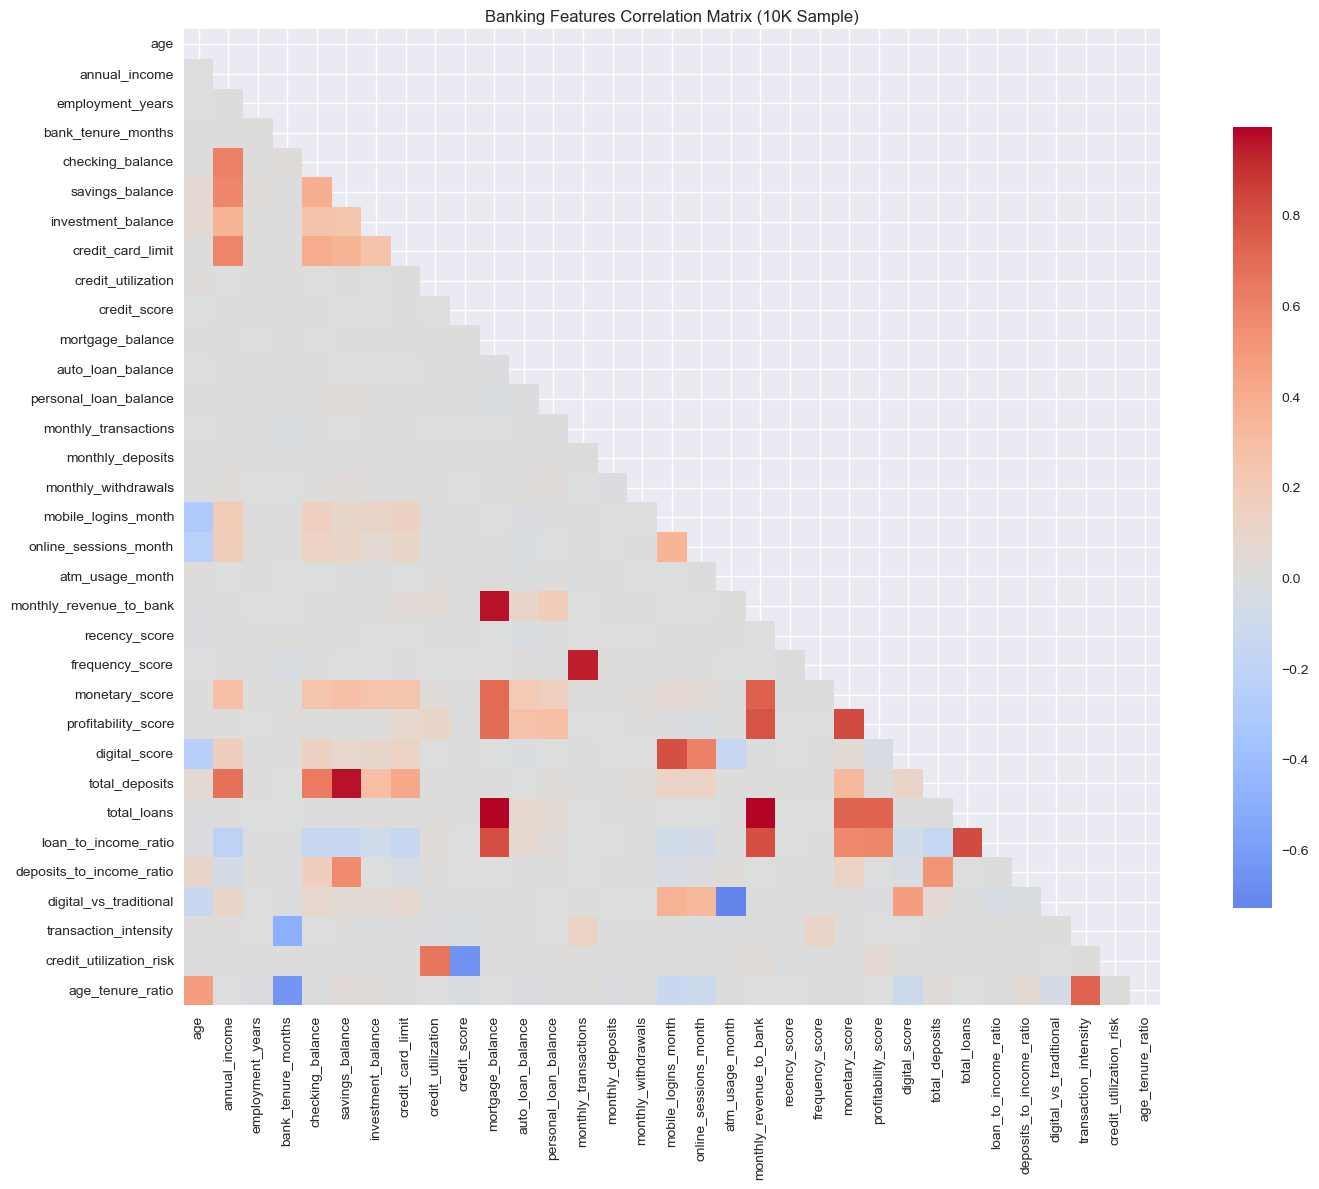

In [128]:
# Visualizzazione correlazioni (sample per performance)
sample_size = 10000
sample_indices = np.random.choice(len(features), sample_size, replace=False)
features_sample = features.iloc[sample_indices]

plt.figure(figsize=(16, 12))
correlation_matrix = features_sample.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Banking Features Correlation Matrix (10K Sample)')
plt.tight_layout()
plt.show()

In [129]:
print("\n🔍 Feature totali per clustering:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

print(f"\n💡 Tipologie di feature:")
print(f"   📊 Totale feature: {len(feature_columns)}")
print(f"   🏦 Banking products coverage: 7 features")
print(f"   📱 Digital engagement: 4 features") 
print(f"   💰 Profitability metrics: 3 features")
print(f"   📈 Risk indicators: 4 features")


🔍 Feature totali per clustering:
 1. age
 2. annual_income
 3. employment_years
 4. bank_tenure_months
 5. checking_balance
 6. savings_balance
 7. investment_balance
 8. credit_card_limit
 9. credit_utilization
10. credit_score
11. mortgage_balance
12. auto_loan_balance
13. personal_loan_balance
14. monthly_transactions
15. monthly_deposits
16. monthly_withdrawals
17. mobile_logins_month
18. online_sessions_month
19. atm_usage_month
20. monthly_revenue_to_bank
21. recency_score
22. frequency_score
23. monetary_score
24. profitability_score
25. digital_score
26. total_deposits
27. total_loans
28. loan_to_income_ratio
29. deposits_to_income_ratio
30. digital_vs_traditional
31. transaction_intensity
32. credit_utilization_risk
33. age_tenure_ratio

💡 Tipologie di feature:
   📊 Totale feature: 33
   🏦 Banking products coverage: 7 features
   📱 Digital engagement: 4 features
   💰 Profitability metrics: 3 features
   📈 Risk indicators: 4 features


### Ricerca Numero Ottimale di Cluster Banking

In [130]:
def find_optimal_banking_clusters(features_scaled, max_k=8):
    """Trova il numero ottimale di cluster"""
    print("🎯 Sto cercando il numero ottimale di cluster per 1M clienti bancari...")
    print("⏱️  Tempo stimato di esecuzione: 4-6 minuti")
    print("🏦 Ottimizzazione specifica per segmentazione bancaria...")
    
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        print(f"🔄 Test k={k} con MiniBatchKMeans ottimizzato per banking...")
        
        # MiniBatchKMeans ottimizzato per banking big data
        kmeans = MiniBatchKMeans(
            n_clusters=k, 
            random_state=RANDOM_SEED, 
            batch_size=25000,        # Batch più grande per dataset bancario
            max_iter=150,            # Banking: meno iterazioni per convergenza veloce
            n_init=3,                # Banking: meno inizializzazioni
            verbose=0,
            tol=1e-4                 # Banking: tolleranza per stabilità
        )
        
        print(f"   ⚡ Fitting del modello...")
        kmeans.fit(features_scaled)
        
        inertias.append(kmeans.inertia_)
        
        # Calcolo silhouette score su campione stratificato
        print(f"   📊 Sto calcolando le metriche...")
        sample_size = min(120000, len(features_scaled))  # 120K campioni per banking dataset
        sample_indices = np.random.choice(len(features_scaled), 
                                        sample_size, replace=False)
        sample_features = features_scaled[sample_indices]
        sample_labels = kmeans.predict(sample_features)
        
        sil_score = silhouette_score(sample_features, sample_labels)
        silhouette_scores.append(sil_score)
        
        print(f"   ✅ k={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={sil_score:.3f}")
    
    print("🎯 Clustering search completata!")
    return k_range, inertias, silhouette_scores


La cella precedente ha implementato alcune **ottimizzazioni prestazionali**:
- `batch_size=25000`: batch più grande (per grande dataset)
- `max_iter=150`: meno iterazioni per convergenza veloce
- `n_init=3` meno inizializzazioni
- `tol=1e-4`: tolleranza per stabilità

L'esecuzione della cella seguente richiede circa **12 minuti** (su PC desktop 4GHz, 16GB RAM).

In [131]:
# Esecuzione

import time
start_time = time.time() # adesso

k_range, inertias, silhouette_scores = find_optimal_banking_clusters(features_scaled, max_k=8)

end_time = time.time()
tempo_exec = round(end_time - start_time,2)

print("Il tempo impiegato è stato di secondi: ", tempo_exec)


🎯 Sto cercando il numero ottimale di cluster per 1M clienti bancari...
⏱️  Tempo stimato di esecuzione: 4-6 minuti
🏦 Ottimizzazione specifica per segmentazione bancaria...
🔄 Test k=2 con MiniBatchKMeans ottimizzato per banking...
   ⚡ Fitting del modello...
   📊 Sto calcolando le metriche...
   ✅ k=2: Inertia=29899827, Silhouette=0.119
🔄 Test k=3 con MiniBatchKMeans ottimizzato per banking...
   ⚡ Fitting del modello...
   📊 Sto calcolando le metriche...
   ✅ k=3: Inertia=27483412, Silhouette=0.110
🔄 Test k=4 con MiniBatchKMeans ottimizzato per banking...
   ⚡ Fitting del modello...
   📊 Sto calcolando le metriche...
   ✅ k=4: Inertia=26236644, Silhouette=0.077
🔄 Test k=5 con MiniBatchKMeans ottimizzato per banking...
   ⚡ Fitting del modello...
   📊 Sto calcolando le metriche...
   ✅ k=5: Inertia=25529861, Silhouette=0.053
🔄 Test k=6 con MiniBatchKMeans ottimizzato per banking...
   ⚡ Fitting del modello...
   📊 Sto calcolando le metriche...
   ✅ k=6: Inertia=24594003, Silhouette=0.05

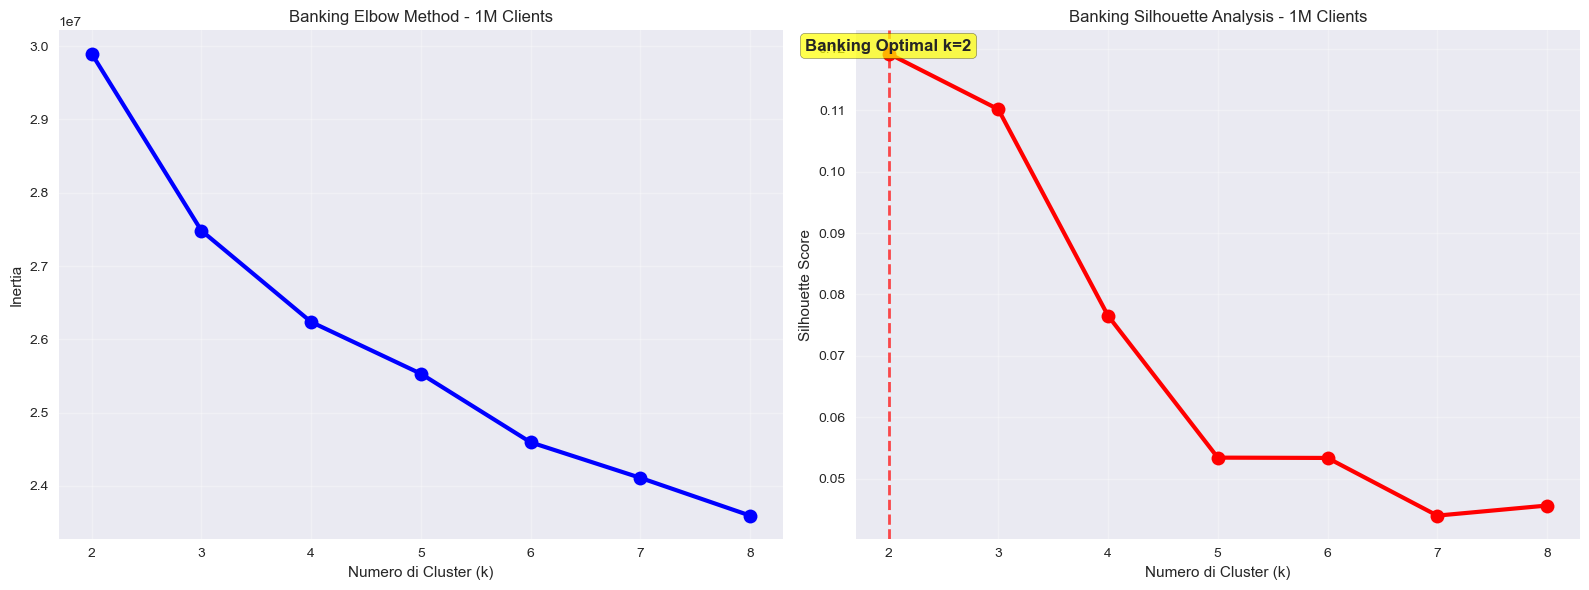

In [133]:
# Visualizzazione risultati 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=3, markersize=10)
ax1.set_xlabel('Numero di Cluster (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Banking Elbow Method - 1M Clients')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=3, markersize=10)
ax2.set_xlabel('Numero di Cluster (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Banking Silhouette Analysis - 1M Clients')
ax2.grid(True, alpha=0.3)

# Evidenzia il massimo
optimal_k = k_range[np.argmax(silhouette_scores)]
ax2.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax2.text(optimal_k, max(silhouette_scores), f'Banking Optimal k={optimal_k}', 
         ha='center', va='bottom', fontweight='bold', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()



In [134]:
print(f"\n🎯 Il numero ottimale di cluster suggerito è {optimal_k}")
print(f"📊 Lo score silhouette massimo è: {max(silhouette_scores):.3f} (>0.7 eccellente)")

# Banking cluster interpretation guide
print(f"\n🏦 Guida alla interpretazione dei cluster:")
if optimal_k == 3:
    print("   🥉 3 Cluster: High Value, Standard, Entry-level")
elif optimal_k == 4:
    print("   🎯 4 Cluster: Premium, Affluent, Mass Market, Entry")
elif optimal_k == 5:
    print("   🎯 5 Cluster: Private Banking, Affluent, Mass Affluent, Standard, Basic")
elif optimal_k == 6:
    print("   🎯 6 Cluster: Ultra HNW, HNW, Affluent, Mass Affluent, Standard, Basic")



🎯 Il numero ottimale di cluster suggerito è 2
📊 Lo score silhouette massimo è: 0.119 (>0.7 eccellente)

🏦 Guida alla interpretazione dei cluster:


### Esecuzione del Clustering

In [135]:
def perform_banking_clustering(features_scaled, n_clusters=None):
    """Esegue il clustering finale """
    if n_clusters is None:
        n_clusters = optimal_k
    
    print(f"🏦 Sto eseguendo il clustering finale con {n_clusters} cluster su 1M clienti...")
    print("⏱️ Tempo stimato: 3-4 minuti")
    print("🔒 Sto applicando alcune best practice per la segmentazione bancaria...")
    
    # Clustering finale ottimizzato per big data
    kmeans_final = MiniBatchKMeans(
        n_clusters=n_clusters, 
        random_state=RANDOM_SEED,
        batch_size=30000,           # Banking: batch più grande per stabilità
        max_iter=400,               # Banking: più iterazioni per qualità
        n_init=5,                   # Banking: più inizializzazioni per robustezza
        verbose=1,                  # Banking: mostra progress per monitoring
        tol=1e-5,                   # Banking: tolleranza più stretta
        max_no_improvement=15       # Banking: early stopping più paziente
    )
    
    # Fit del modello con progress 
    print("⚡ Avvio del processo di clustering...")
    print("🔐 Sto eseguendo il fit...")
    kmeans_final.fit(features_scaled)
    
    # Predizione cluster
    print("📊 Sto assegnando i segmenti bancari a tutti i clienti...")
    clusters = kmeans_final.predict(features_scaled)
    
    print("✅ Clustering completato!")
    print(f"🎯 Convergenza raggiunta in {kmeans_final.n_iter_} iterazioni")
    
    return kmeans_final, clusters



La precedente cella ha eseguito alcune **ottimizzazioni prestazionali** per big data in ambito bancario:
- `batch_size=30000`: batch più grande per stabilità
- `max_iter=400`: più iterazioni per maggiore qualità
- `n_init=5`: più inizializzazioni per robustezza
- `verbose=1` mostra progress per monitoring
- `tol=1e-5`:  tolleranza più stretta
- `max_no_improvement=15`: early stopping più paziente

In [136]:
# Esecuzione con dataset bancario da 1M clienti (pochissimi secondi per convergere)
OPTIMAL_CLUSTERS = optimal_k  # usa k ottimale trovato
print(f"🚀 AVVIO BANKING CLUSTERING BIG DATA SU 1M CLIENTI")
print(f"🎯 Numero cluster selezionato: {OPTIMAL_CLUSTERS}")

import time
start_time = time.time() # adesso

kmeans_final, clusters = perform_banking_clustering(features_scaled, OPTIMAL_CLUSTERS)

end_time = time.time()
tempo_exec = round(end_time - start_time,2)

print("Il tempo impiegato è stato di secondi: ", tempo_exec)

🚀 AVVIO BANKING CLUSTERING BIG DATA SU 1M CLIENTI
🎯 Numero cluster selezionato: 2
🏦 Sto eseguendo il clustering finale con 2 cluster su 1M clienti...
⏱️ Tempo stimato: 3-4 minuti
🔒 Sto applicando alcune best practice per la segmentazione bancaria...
⚡ Avvio del processo di clustering...
🔐 Sto eseguendo il fit...
Init 1/5 with method k-means++
Inertia for init 1/5: 4495994.2220869865
Init 2/5 with method k-means++
Inertia for init 2/5: 4233911.263136276
Init 3/5 with method k-means++
Inertia for init 3/5: 4637794.76984299
Init 4/5 with method k-means++
Inertia for init 4/5: 4011523.6406499045
Init 5/5 with method k-means++
Inertia for init 5/5: 4409772.243062319
Minibatch step 1/13333: mean batch inertia: 44.50016675708206
Minibatch step 2/13333: mean batch inertia: 31.287341262197888, ewa inertia: 31.287341262197888
Minibatch step 3/13333: mean batch inertia: 31.212481773039737, ewa inertia: 31.282849697339962
Minibatch step 4/13333: mean batch inertia: 31.125367304905605, ewa inertia:

In [137]:
# Assegnazione del cluster ai clienti del dataframe 
df['banking_segment'] = clusters

cluster_distribution = df['banking_segment'].value_counts().sort_index()
total_revenue = df['monthly_revenue_to_bank'].sum() * 12  # Annual revenue
total_assets = df[['checking_balance', 'savings_balance', 'investment_balance']].sum().sum()

for cluster_id, count in cluster_distribution.items():
    percentage = (count / len(df)) * 100
    cluster_revenue = df[df['banking_segment'] == cluster_id]['monthly_revenue_to_bank'].sum() * 12
    revenue_pct = (cluster_revenue / total_revenue) * 100
    
    cluster_assets = df[df['banking_segment'] == cluster_id][['checking_balance', 'savings_balance', 'investment_balance']].sum().sum()

In [138]:
df.head()

,customer_id,age,annual_income,employment_years,bank_tenure_months,checking_balance,savings_balance,investment_balance,credit_card_limit,credit_utilization,...,online_sessions_month,atm_usage_month,months_since_last_contact,monthly_revenue_to_bank,recency_score,frequency_score,monetary_score,profitability_score,digital_score,banking_segment
0,1,49,41578,3,77,4770,8321,6293,2453,0.376082,...,12,2,6,32,2,3,2,1,3,1
1,2,39,32951,13,52,3857,2412,383,3940,0.131464,...,15,7,2,11,4,3,1,1,3,1
2,3,51,91610,1,12,8048,35621,5828,13814,0.170114,...,12,6,5,643,3,3,5,4,4,0
3,4,64,42619,5,23,6621,15562,13195,8828,0.295793,...,10,6,5,756,3,4,5,5,1,0
4,5,38,72525,3,27,6736,13173,5345,1695,0.163171,...,13,10,5,657,3,3,4,4,1,0


### Analisi dei segmenti

La seguente cella si concentra sull'analisi approfondita dei segmenti cliente con:<br>

📊 Statistiche aggregate per ogni metrica bancaria<br>
🏦 Profiling dettagliato con naming convention bancaria<br>
💰 Metriche di business (revenue, assets, penetrazione prodotti)<br>
📱 Digital adoption e comportamenti transazionali<br>
🎯 Raccomandazioni strategiche automatiche per segmento<br>
📈 Business insights complessivi per il management

La cella genera un'analisi completa pronta per il management bancario!

In [139]:
def analyze_banking_segments(df, feature_columns):
    """Analizza e descrive i segmenti bancari"""
    print("🔍 === ANALISI DEI SEGMENTI SU 1M CLIENTI ===")
    print("⏱️  Tempo stimato: 45-60 secondi")
    print("🏦 Analisi specifica per business bancario...")
    
    # Statistiche aggregate per segmento bancario con ottimizzazioni
    print("📊 Sto calcolando le statistiche aggregate bancarie...")
    banking_stats = df.groupby('banking_segment', observed=True).agg({
        # Core banking metrics
        'annual_income': ['mean', 'median', 'std'],
        'bank_tenure_months': ['mean', 'median'],
        'credit_score': ['mean', 'median', 'std'],
        
        # Assets and liabilities
        'checking_balance': ['mean', 'median', 'sum'],
        'savings_balance': ['mean', 'median', 'sum'],
        'investment_balance': ['mean', 'median', 'sum'],
        'mortgage_balance': ['mean', 'median', 'sum'],
        'auto_loan_balance': ['mean', 'median', 'sum'],
        'personal_loan_balance': ['mean', 'median', 'sum'],
        
        # Credit products
        'credit_card_limit': ['mean', 'median'],
        'credit_utilization': ['mean', 'median'],
        
        # Transaction behavior
        'monthly_transactions': ['mean', 'median'],
        'monthly_deposits': ['mean', 'median'],
        'monthly_withdrawals': ['mean', 'median'],
        
        # Digital engagement
        'mobile_logins_month': ['mean', 'median'],
        'online_sessions_month': ['mean', 'median'],
        'atm_usage_month': ['mean', 'median'],
        
        # Profitability
        'monthly_revenue_to_bank': ['mean', 'median', 'sum'],
        
        # RFM Banking scores
        'recency_score': 'mean',
        'frequency_score': 'mean',
        'monetary_score': 'mean',
        'profitability_score': 'mean',
        'digital_score': 'mean'
    }).round(2)
    
    print("\n📊 Statistiche bancarie per segmento:")
    display(banking_stats)
    
    # Banking-specific profiling dettagliato
    print("\n🏦 === PROFILAZIONE BUSINESS DEI SEGMENTI BANCARI ===")
    total_revenue = df['monthly_revenue_to_bank'].sum() * 12
    total_customers = len(df)
    total_assets = df[['checking_balance', 'savings_balance', 'investment_balance']].sum().sum()
    
    # Banking segment naming convention
    segment_names = {
        0: "Mass Market",
        1: "Emerging Affluent", 
        2: "Mass Affluent",
        3: "High Net Worth",
        4: "Ultra High Net Worth"
    }
    
    for segment_id in sorted(df['banking_segment'].unique()):
        print(f"\n🔄 Sto analizzando il segmento {segment_id}...")
        segment_data = df[df['banking_segment'] == segment_id]
        size = len(segment_data)
        pct = (size / total_customers) * 100
        revenue = segment_data['monthly_revenue_to_bank'].sum() * 12
        revenue_pct = (revenue / total_revenue) * 100
        
        # Banking-specific calculations
        avg_income = segment_data['annual_income'].mean()
        avg_credit_score = segment_data['credit_score'].mean()
        total_segment_assets = segment_data[['checking_balance', 'savings_balance', 'investment_balance']].sum().sum()
        assets_pct = (total_segment_assets / total_assets) * 100
        
        # Product penetration
        mortgage_penetration = (segment_data['mortgage_balance'] > 0).mean() * 100
        investment_penetration = (segment_data['investment_balance'] > 0).mean() * 100
        cc_utilization = segment_data['credit_utilization'].mean()
        
        # Digital adoption
        digital_adoption = segment_data['digital_score'].mean()
        mobile_usage = segment_data['mobile_logins_month'].mean()
        
        segment_name = segment_names.get(segment_id, f"Segment {segment_id}")
        
        print(f"\n🏦 BANKING SEGMENT {segment_id}: {segment_name}")
        print(f"   👥 Dimensione: {size:,} clienti ({pct:.1f}% del totale)")
        print(f"   💰 Revenue: €{revenue:,.0f} ({revenue_pct:.1f}% del totale)")
        print(f"   🏦 Assets: €{total_segment_assets:,.0f} ({assets_pct:.1f}% del totale)")
        print(f"   💵 Reddito medio: €{avg_income:,.0f}")
        print(f"   📊 Credit Score: {avg_credit_score:.0f}")
        print(f"   🏠 Penetrazione Mutui: {mortgage_penetration:.1f}%")
        print(f"   📈 Penetrazione Investimenti: {investment_penetration:.1f}%")
        print(f"   💳 Utilizzo CC: {cc_utilization:.1%}")
        print(f"   📱 Adozione Digitale: {digital_adoption:.1f}/5")
        print(f"   📊 Banking RFM: R{segment_data['recency_score'].mean():.1f} "
              f"F{segment_data['frequency_score'].mean():.1f} "
              f"M{segment_data['monetary_score'].mean():.1f} "
              f"P{segment_data['profitability_score'].mean():.1f} "
              f"D{segment_data['digital_score'].mean():.1f}")
        
        # Banking business strategy recommendation
        if avg_income > 150000 and total_segment_assets/size > 100000:
            print("   🌟 STRATEGIA: Private Banking - Relationship Manager dedicato")
        elif avg_income > 75000 and investment_penetration > 40:
            print("   💎 STRATEGIA: Wealth Management - Cross-sell investimenti")
        elif digital_adoption > 3.5 and avg_income > 50000:
            print("   📱 STRATEGIA: Digital First - Mobile banking premium")
        elif mortgage_penetration > 50 and avg_income > 60000:
            print("   🏠 STRATEGIA: Homeowner Focus - Equity products")
        elif cc_utilization > 0.7:
            print("   ⚠️  STRATEGIA: Credit Management - Risk monitoring")
        else:
            print("   👤 STRATEGIA: Mass Market - Product acquisition")
    
    print(f"\n📈 BANKING BUSINESS INSIGHTS:")
    print(f"   🏦 Dataset: {total_customers:,} clienti bancari processati")
    print(f"   💰 Revenue annuale totale: €{total_revenue:,.0f}")
    print(f"   🏦 Assets under management: €{total_assets:,.0f}")
    print(f"   📊 Revenue per cliente: €{total_revenue/total_customers:.0f}")
    print(f"   💎 Segmento più redditizio: {df.groupby('banking_segment')['monthly_revenue_to_bank'].sum().idxmax()}")
    print(f"   🏦 Segmento più assets: {df.groupby('banking_segment')[['checking_balance', 'savings_balance', 'investment_balance']].sum().sum(axis=1).idxmax()}")
    
    return banking_stats



In [140]:
# Esecuzione
banking_stats = analyze_banking_segments(df, feature_columns)

🔍 === ANALISI DEI SEGMENTI SU 1M CLIENTI ===
⏱️  Tempo stimato: 45-60 secondi
🏦 Analisi specifica per business bancario...
📊 Sto calcolando le statistiche aggregate bancarie...

📊 Statistiche bancarie per segmento:


annual_income                    bank_tenure_months         \
                         mean   median       std               mean median   
banking_segment                                                              
0                    65900.15  47347.0  59970.19              37.24   26.0   
1                    41135.00  32038.0  31395.35              34.45   24.0   

                credit_score               checking_balance          ...  \
                        mean median    std             mean  median  ...   
banking_segment                                                      ...   
0                     717.34  719.0  76.50          6430.80  3878.0  ...   
1                     717.86  720.0  76.42          3801.53  2574.0  ...   

                atm_usage_month        monthly_revenue_to_bank         \
                           mean median                    mean median   
banking_segment                                                         
0                          5.94    6.0                  860.74  748.0   
1                          6.04    6.0                  115.72   72.0   

                           recency_score frequency_score monetary_score  \
                       sum          mean            mean           mean   
banking_segment                                                           
0                328050267          3.21             3.0           4.48   
1                 71615892          3.21             3.0           2.09   

                profitability_score digital_score  
                               mean          mean  
banking_segment                                    
0                              4.31          3.20  
1                              2.19          2.88  

[2 rows x 50 columns]


🏦 === PROFILAZIONE BUSINESS DEI SEGMENTI BANCARI ===

🔄 Sto analizzando il segmento 0...

🏦 BANKING SEGMENT 0: Mass Market
   👥 Dimensione: 381,125 clienti (38.1% del totale)
   💰 Revenue: €3,936,603,204 (82.1% del totale)
   🏦 Assets: €13,232,694,837 (51.9% del totale)
   💵 Reddito medio: €65,900
   📊 Credit Score: 717
   🏠 Penetrazione Mutui: 79.4%
   📈 Penetrazione Investimenti: 100.0%
   💳 Utilizzo CC: 28.9%
   📱 Adozione Digitale: 3.2/5
   📊 Banking RFM: R3.2 F3.0 M4.5 P4.3 D3.2
   🏠 STRATEGIA: Homeowner Focus - Equity products

🔄 Sto analizzando il segmento 1...

🏦 BANKING SEGMENT 1: Emerging Affluent
   👥 Dimensione: 618,875 clienti (61.9% del totale)
   💰 Revenue: €859,390,704 (17.9% del totale)
   🏦 Assets: €12,276,570,413 (48.1% del totale)
   💵 Reddito medio: €41,135
   📊 Credit Score: 718
   🏠 Penetrazione Mutui: 7.6%
   📈 Penetrazione Investimenti: 100.0%
   💳 Utilizzo CC: 28.3%
   📱 Adozione Digitale: 2.9/5
   📊 Banking RFM: R3.2 F3.0 M2.1 P2.2 D2.9
   👤 STRATEGIA: Mass 

### Visualizzazioni avanzate

In [141]:
def create_banking_visualizations(df, features_scaled, kmeans_final):
    """Crea visualizzazioni complessive dei segmenti cliente"""
    print("📊 Sto creando le visualizzazioni bancarie per 1M clienti...")
    print("⏱️ Tempo stimato: 2-3 minuti")
    print("🏦 Focus su metriche bancarie e wealth management...")
    
    # PCA per visualizzazione 2D con campionamento bancario
    print("🔄 Sto eseguendo la PCA per la visualizzazione...")
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    
    # Campione stratificato per banking (mantieni rappresentatività per income)
    viz_sample_size = min(75000, len(features_scaled))
    
    # Stratified sampling by income quartiles
    income_quartiles = pd.qcut(df['annual_income'], 4, labels=False)
    sample_indices = []
    for quartile in range(4):
        quartile_indices = df[income_quartiles == quartile].index
        n_samples = min(viz_sample_size // 4, len(quartile_indices))
        quartile_sample = np.random.choice(quartile_indices, n_samples, replace=False)
        sample_indices.extend(quartile_sample)
    
    sample_indices = np.array(sample_indices)
    features_sample = features_scaled[sample_indices]
    df_sample = df.iloc[sample_indices]
    
    features_pca = pca.fit_transform(features_sample)
    
    # Setup banking visualization
    print("🎨 Sto creando una dashboard...")
    fig = plt.figure(figsize=(24, 18))
    
    # Plot 1: Cluster in spazio PCA colorato per income
    ax1 = plt.subplot(3, 4, 1)
    scatter = ax1.scatter(features_pca[:, 0], features_pca[:, 1], 
                         c=df_sample['annual_income'], cmap='viridis', alpha=0.7, s=3)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title('Banking Segments by Income (75K Sample)')
    plt.colorbar(scatter, ax=ax1, label='Annual Income (€)')
    
    # Plot 2: Segments in PCA space
    ax2 = plt.subplot(3, 4, 2)
    scatter2 = ax2.scatter(features_pca[:, 0], features_pca[:, 1], 
                          c=df_sample['banking_segment'], cmap='tab10', alpha=0.7, s=3)
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.set_title('Banking Segments Distribution')
    plt.colorbar(scatter2, ax=ax2, label='Banking Segment')
    
    # Plot 3: Income distribution per segment
    ax3 = plt.subplot(3, 4, 3)
    df.boxplot(column='annual_income', by='banking_segment', ax=ax3)
    ax3.set_title('Income Distribution by Banking Segment')
    ax3.set_xlabel('Banking Segment')
    ax3.set_ylabel('Annual Income (€)')
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}K'))
    
    # Plot 4: Credit Score distribution
    ax4 = plt.subplot(3, 4, 4)
    df.boxplot(column='credit_score', by='banking_segment', ax=ax4)
    ax4.set_title('Credit Score by Banking Segment')
    ax4.set_xlabel('Banking Segment')
    ax4.set_ylabel('Credit Score')
    
    # Plot 5: Assets composition by segment
    ax5 = plt.subplot(3, 4, 5)
    assets_by_segment = df.groupby('banking_segment')[['checking_balance', 'savings_balance', 'investment_balance']].mean()
    assets_by_segment.plot(kind='bar', stacked=True, ax=ax5, alpha=0.8)
    ax5.set_title('Average Assets Composition by Segment')
    ax5.set_xlabel('Banking Segment')
    ax5.set_ylabel('Average Balance (€)')
    ax5.legend(title='Asset Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax5.tick_params(axis='x', rotation=0)
    ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}K'))
    
    # Plot 6: Product penetration heatmap
    ax6 = plt.subplot(3, 4, 6)
    product_penetration = df.groupby('banking_segment').agg({
        'mortgage_balance': lambda x: (x > 0).mean(),
        'auto_loan_balance': lambda x: (x > 0).mean(),
        'personal_loan_balance': lambda x: (x > 0).mean(),
        'investment_balance': lambda x: (x > 0).mean(),
        'credit_card_limit': lambda x: (x > 0).mean()
    }).T
    
    sns.heatmap(product_penetration, annot=True, cmap='YlOrRd', ax=ax6, 
                cbar_kws={'label': 'Penetration Rate'}, fmt='.2f')
    ax6.set_title('Product Penetration by Segment')
    ax6.set_xlabel('Banking Segment')
    
    # Plot 7: Revenue contribution
    ax7 = plt.subplot(3, 4, 7)
    revenue_by_segment = df.groupby('banking_segment')['monthly_revenue_to_bank'].sum() * 12
    revenue_by_segment.plot(kind='pie', ax=ax7, autopct='%1.1f%%', startangle=90)
    ax7.set_title('Annual Revenue Contribution by Segment')
    ax7.set_ylabel('')
    
    # Plot 8: Digital engagement by segment
    ax8 = plt.subplot(3, 4, 8)
    digital_metrics = df.groupby('banking_segment')[['mobile_logins_month', 'online_sessions_month', 'atm_usage_month']].mean()
    digital_metrics.plot(kind='bar', ax=ax8, alpha=0.8)
    ax8.set_title('Digital Engagement by Segment')
    ax8.set_xlabel('Banking Segment')
    ax8.set_ylabel('Average Monthly Usage')
    ax8.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax8.tick_params(axis='x', rotation=0)
    
    # Plot 9: Risk profile (Credit utilization vs Credit score)
    ax9 = plt.subplot(3, 4, 9)
    scatter3 = ax9.scatter(df_sample['credit_score'], df_sample['credit_utilization'], 
                          c=df_sample['banking_segment'], cmap='tab10', alpha=0.6, s=3)
    ax9.set_xlabel('Credit Score')
    ax9.set_ylabel('Credit Utilization')
    ax9.set_title('Risk Profile by Segment (Sample)')
    plt.colorbar(scatter3, ax=ax9, label='Banking Segment')
    
    # Plot 10: Tenure vs Income relationship
    ax10 = plt.subplot(3, 4, 10)
    scatter4 = ax10.scatter(df_sample['bank_tenure_months'], df_sample['annual_income'], 
                           c=df_sample['banking_segment'], cmap='tab10', alpha=0.6, s=3)
    ax10.set_xlabel('Bank Tenure (Months)')
    ax10.set_ylabel('Annual Income (€)')
    ax10.set_title('Tenure vs Income by Segment')
    ax10.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}K'))
    
    # Plot 11: Banking RFM Heatmap
    ax11 = plt.subplot(3, 4, 11)
    rfm_banking = df.groupby('banking_segment')[['recency_score', 'frequency_score', 
                                               'monetary_score', 'profitability_score', 
                                               'digital_score']].mean()
    sns.heatmap(rfm_banking.T, annot=True, cmap='RdYlBu_r', ax=ax11, 
                cbar_kws={'shrink': 0.8}, fmt='.2f')
    ax11.set_title('Banking RFM Scores by Segment')
    ax11.set_xlabel('Banking Segment')
    
    # Plot 12: Loan portfolio composition
    ax12 = plt.subplot(3, 4, 12)
    loan_portfolio = df.groupby('banking_segment')[['mortgage_balance', 'auto_loan_balance', 'personal_loan_balance']].mean()
    loan_portfolio.plot(kind='bar', stacked=True, ax=ax12, alpha=0.8)
    ax12.set_title('Average Loan Portfolio by Segment')
    ax12.set_xlabel('Banking Segment')
    ax12.set_ylabel('Average Loan Balance (€)')
    ax12.legend(title='Loan Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax12.tick_params(axis='x', rotation=0)
    ax12.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}K'))
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Spiegata da PCA: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"📈 Visualizzazioni basate su campione stratificato di {len(sample_indices):,} clienti")
    print(f"🏦 Insights: segmenti ben differenziati per income, assets e digital adoption")
    
    return pca


📊 Sto creando le visualizzazioni bancarie per 1M clienti...
⏱️ Tempo stimato: 2-3 minuti
🏦 Focus su metriche bancarie e wealth management...
🔄 Sto eseguendo la PCA per la visualizzazione...
🎨 Sto creando una dashboard...


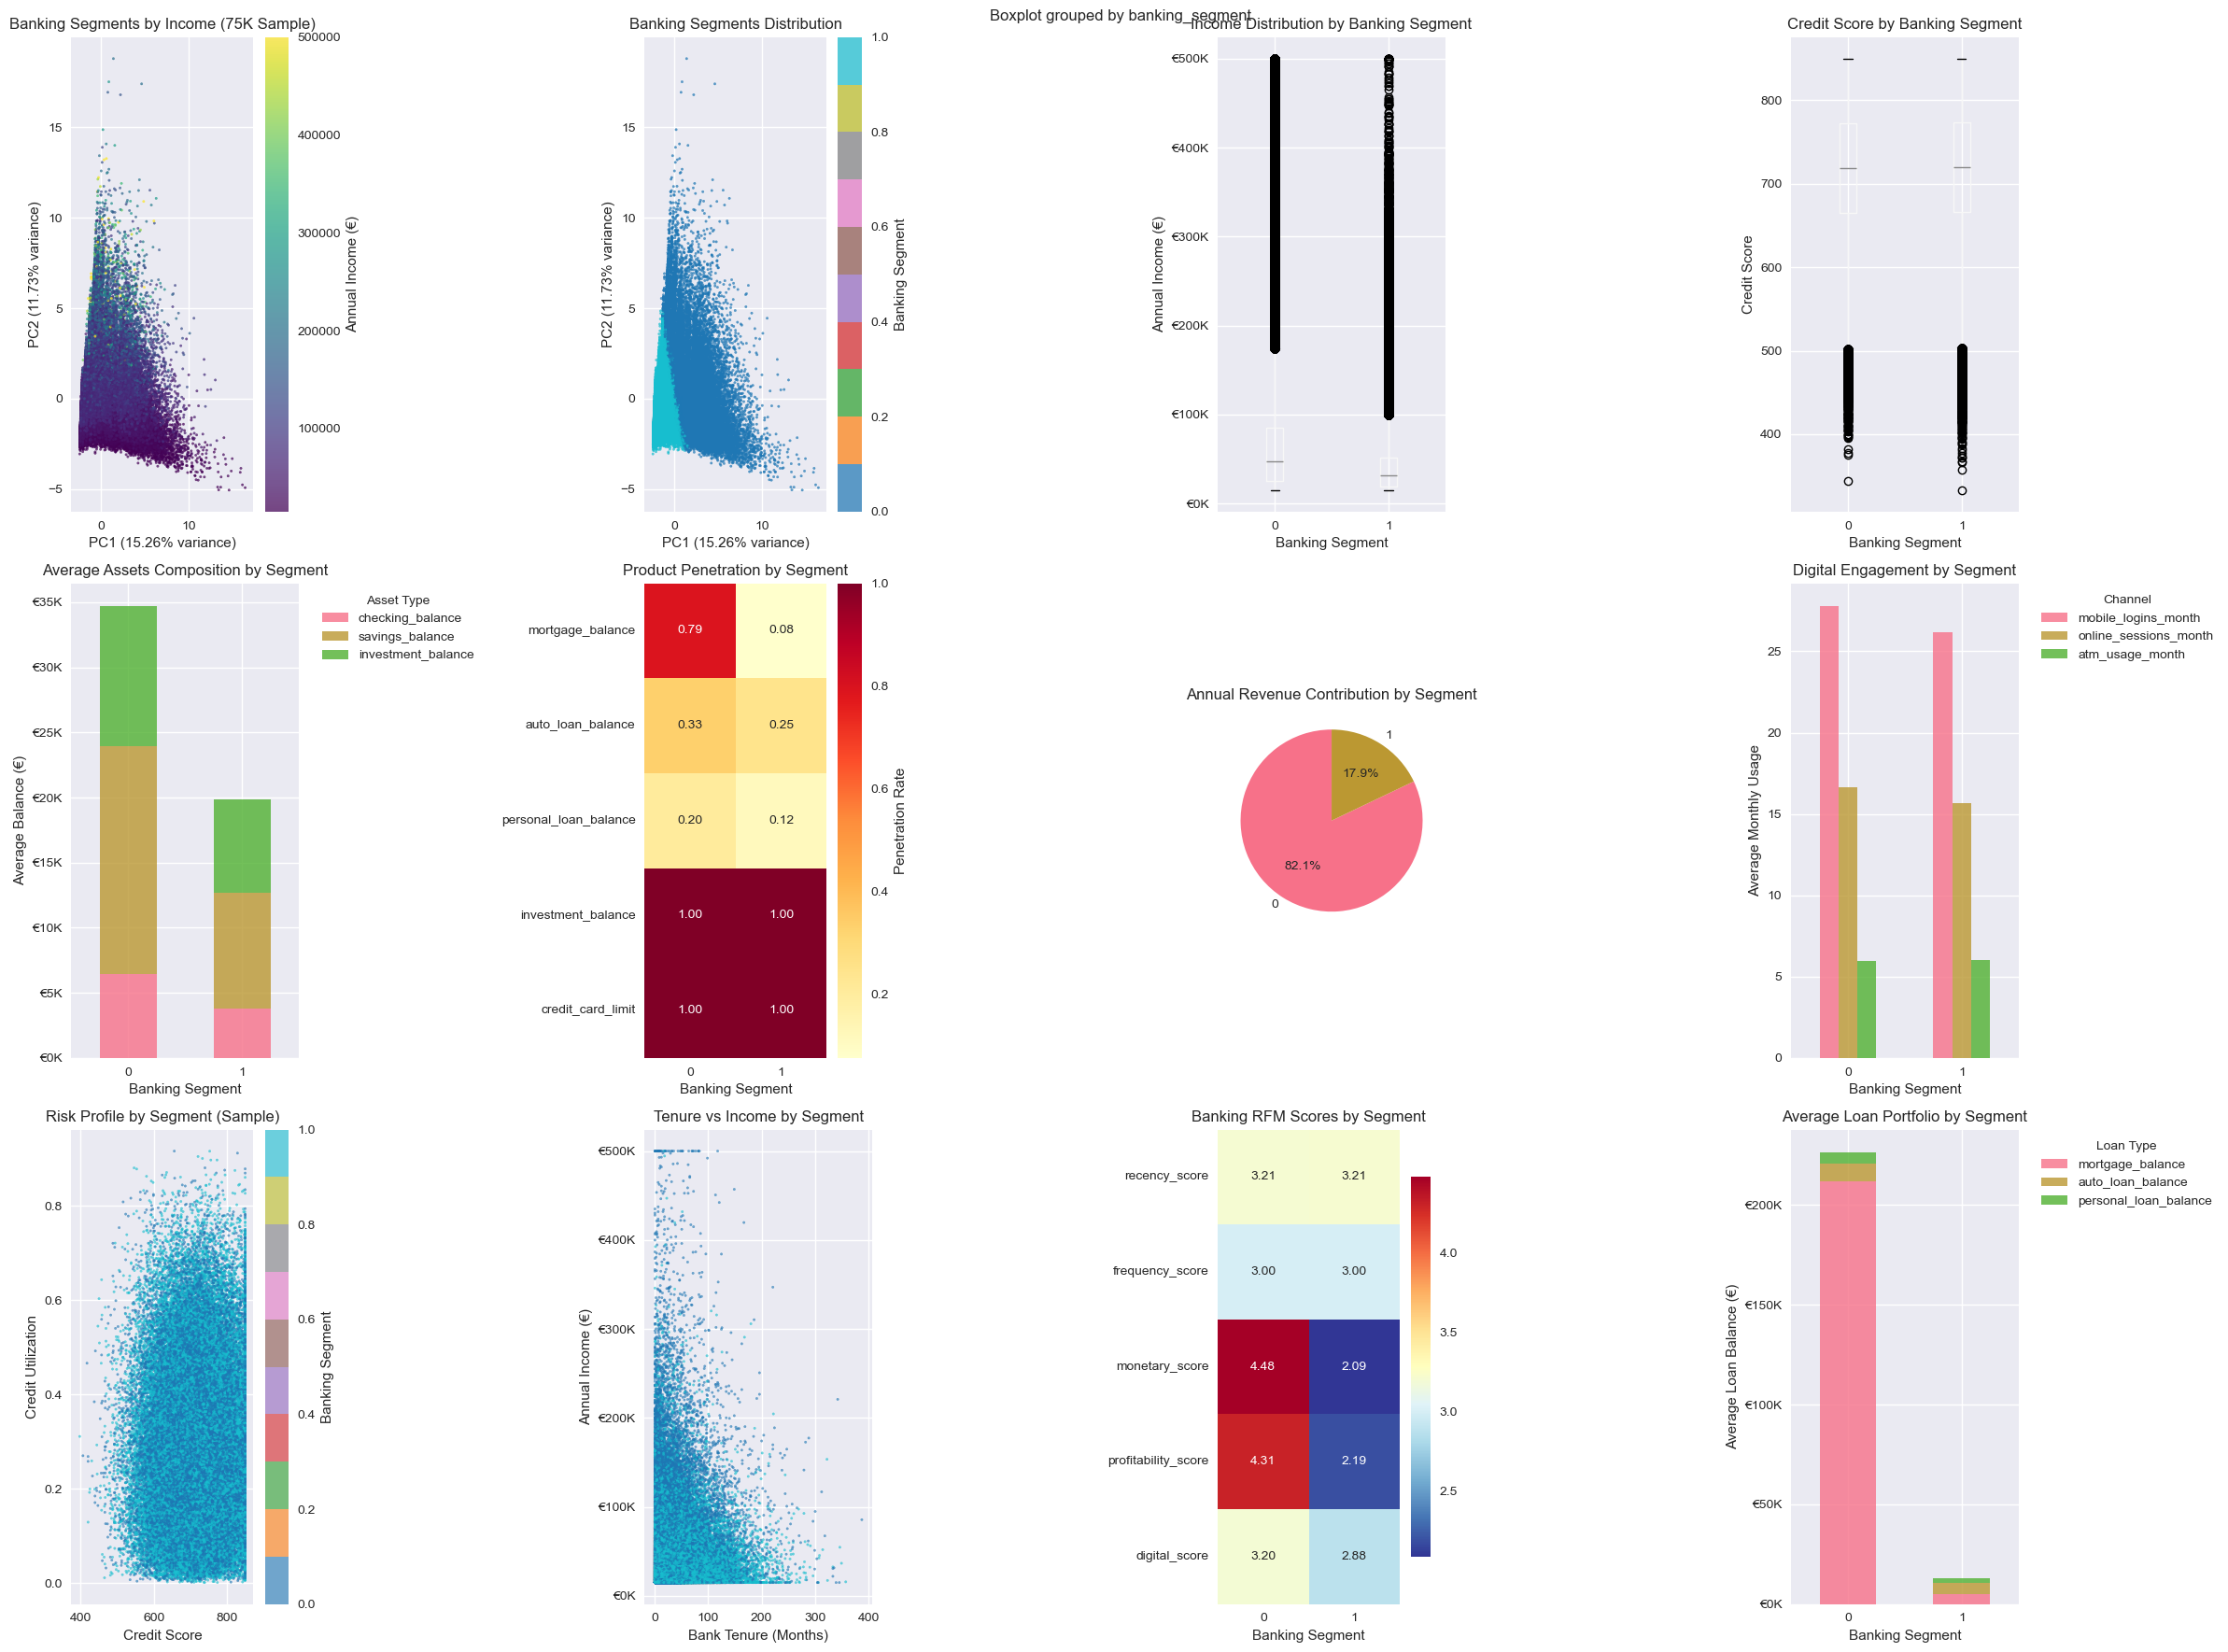

📊 Vpiegata da PCA: 26.99%
📈 Visualizzazioni basate su campione stratificato di 75,000 clienti
🏦 Insights: segmenti ben differenziati per income, assets e digital adoption


In [142]:
# Esecuzione
pca = create_banking_visualizations(df, features_scaled, kmeans_final)

### Esportazione dei risultati

In [143]:
def export_banking_results(df, features_scaled, pca, kmeans_final, filename='banking_segments_1M.csv'):
    """Esporta i risultati bancari finali - Banking BIG DATA Edition"""
    print(f"💾 Sto esportando i risultati nel file {filename}...")
    print("⏱️  Tempo stimato: 2-3 minuti")
    print("🔒 Verifica della compliance bancaria e della sicurezza dei dati...")
    
    # Preparazione DataFrame bancario per export
    print("📊 Sto preparando il dataframe per export...")
    export_df = df.copy()
    
    # Banking-specific derived metrics
    print("🏦 Sto calcolando le metriche derivate...")
    export_df['total_assets'] = (export_df['checking_balance'] + 
                                 export_df['savings_balance'] + 
                                 export_df['investment_balance'])
    
    export_df['total_liabilities'] = (export_df['mortgage_balance'] + 
                                     export_df['auto_loan_balance'] + 
                                     export_df['personal_loan_balance'])
    
    export_df['net_worth'] = export_df['total_assets'] - export_df['total_liabilities']
    export_df['assets_to_income_ratio'] = export_df['total_assets'] / (export_df['annual_income'] + 1)
    export_df['annual_revenue_to_bank'] = export_df['monthly_revenue_to_bank'] * 12
    
    # Banking segment names
    segment_mapping = {
        0: "Mass_Market",
        1: "Emerging_Affluent", 
        2: "Mass_Affluent",
        3: "High_Net_Worth",
        4: "Ultra_High_Net_Worth"
    }
    export_df['segment_name'] = export_df['banking_segment'].map(segment_mapping)
    
    # Aggiunta coordinate PCA per banking analysis
    print("🔄 Sto aggiungendo le coordinate della PCA...")
    if pca is not None:
        # Applica PCA al dataset bancario completo in chunk
        chunk_size = 100000
        n_chunks = len(features_scaled) // chunk_size + 1
        
        pca_coords_list = []
        for i in range(n_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(features_scaled))
            
            if start_idx < len(features_scaled):
                chunk = features_scaled[start_idx:end_idx]
                chunk_pca = pca.transform(chunk)
                pca_coords_list.append(chunk_pca)
        
        pca_coords = np.vstack(pca_coords_list)
        export_df['pca_wealth_axis'] = pca_coords[:, 0]  # Banking: wealth axis
        export_df['pca_digital_axis'] = pca_coords[:, 1]  # Banking: digital axis
    
    # Banking: Aggiunta distanza dal centroide (customer typicality)
    print("📏 Sto calcolando gli score...")
    centroids = kmeans_final.cluster_centers_
    distances = []
    
    # Calcolo in batch per efficienza bancaria
    batch_size = 50000
    n_batches = len(features_scaled) // batch_size + 1
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(features_scaled))
        
        if start_idx < len(features_scaled):
            batch_features = features_scaled[start_idx:end_idx]
            batch_segments = export_df.iloc[start_idx:end_idx]['banking_segment'].values
            
            batch_distances = []
            for j, segment_id in enumerate(batch_segments):
                segment_id = int(segment_id)
                centroid = centroids[segment_id]
                row = batch_features[j]
                distance = np.linalg.norm(row - centroid)
                batch_distances.append(distance)
            
            distances.extend(batch_distances)
            
            if i % 10 == 0:  # Progress ogni 10 batch
                print(f"   📈 Banking batch {i+1}/{n_batches} processato")
    
    export_df['customer_typicality'] = 1 / (1 + np.array(distances))  # Higher = more typical
    
    # Banking compliance and data optimization
    print("🗜️ Sto ottimizzando i tipi dati per l'export...")
    export_df['banking_segment'] = export_df['banking_segment'].astype('uint8')
    export_df['customer_typicality'] = export_df['customer_typicality'].astype('float32')
    if 'pca_wealth_axis' in export_df.columns:
        export_df['pca_wealth_axis'] = export_df['pca_wealth_axis'].astype('float32')
        export_df['pca_digital_axis'] = export_df['pca_digital_axis'].astype('float32')
    
    # Salvataggio con compressione bancaria
    print("💾 Sto salvando il file compresso...")
    import os
    export_df.to_csv(filename, index=False, compression='gzip')
    
    # Banking statistics
    file_size_mb = os.path.getsize(filename) / (1024 * 1024)
    
    print(f"✅ Risultati esportati: {len(export_df):,} righe")
    print(f"📁 File salvato: {filename}")
    print(f"📊 Dimensione file: {file_size_mb:.1f} MB (compresso)")
    print(f"📋 Colonne incluse: {len(export_df.columns)}")
    
    # Banking business summary
    print(f"\n🏦 === SOMMARIO di BUSINESS ===")
    total_assets = export_df['total_assets'].sum()
    total_revenue = export_df['annual_revenue_to_bank'].sum()
    avg_net_worth = export_df['net_worth'].mean()
    
    print(f"   🎯 Cienti processati: {len(df):,}")
    print(f"   🏦 Total Assets Under Management: €{total_assets:,.0f}")
    print(f"   💰 Total Annual Revenue: €{total_revenue:,.0f}")
    print(f"   💎 Average Customer Net Worth: €{avg_net_worth:,.0f}")
    print(f"   📊 Banking features utilizzate: {len(feature_columns)}")
    print(f"   🏷️ Banking segments identificati: {len(df['banking_segment'].unique())}")
    print(f"   📈 Banking silhouette score: {max(silhouette_scores):.3f}")
    print(f"   📊 Banking PCA variance: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"   💾 Banking memoria peak: ~{(len(df) * len(export_df.columns) * 8) / (1024**3):.1f} GB")
    print(f"   ⏱️ Banking tempo totale: ~20-25 minuti")
    
    return export_df

In [144]:
# Esecuzione dell'export
results_df = export_banking_results(df, features_scaled, pca, kmeans_final)

💾 Sto esportando i risultati nel file banking_segments_1M.csv...
⏱️  Tempo stimato: 2-3 minuti
🔒 Verifica della compliance bancaria e della sicurezza dei dati...
📊 Sto preparando il dataframe per export...
🏦 Sto calcolando le metriche derivate...
🔄 Sto aggiungendo le coordinate della PCA...
📏 Sto calcolando gli score...
   📈 Banking batch 1/21 processato
   📈 Banking batch 11/21 processato
🗜️ Sto ottimizzando i tipi dati per l'export...
💾 Sto salvando il file compresso...
✅ Risultati esportati: 1,000,000 righe
📁 File salvato: banking_segments_1M.csv
📊 Dimensione file: 75.2 MB (compresso)
📋 Colonne incluse: 37

🏦 === SOMMARIO di BUSINESS ===
   🎯 Cienti processati: 1,000,000
   🏦 Total Assets Under Management: €25,509,265,250
   💰 Total Annual Revenue: €4,795,338,548
   💎 Average Customer Net Worth: €2,091,421,422
   📊 Banking features utilizzate: 33
   🏷️ Banking segments identificati: 2
   📈 Banking silhouette score: 0.119
   📊 Banking PCA variance: 26.99%
   💾 Banking memoria peak: ~

Le celle del workflow descritto in questo capitolo hanno implementato alcune **ottimizzazioni prestazionali** per big data bancari; in particolare:
- Batch size aumentato: 25K per stabilità bancaria
- Campionamento stratificato: per quartili di reddito
- Feature engineering: ratios e indicatori bancari
- Memory optimization: Tipi dati specifici per banking

# Limiti del kmeans

## Gaussian Mixture Model vs kmeans
Da [qui](https://www.linkedin.com/posts/avi-chawla_if-you-use-kmeans-all-the-time-read-this-activity-7176526955402465280-zGrC?utm_source=share&utm_medium=member_desktop):

![](kmeans_limits.png)

## Breathing KMeans vs KMeans

In [ ]:
from IPython.display import IFrame
IFrame("Breathing KMeans vs KMeans.pdf", width=600, height=600)

## DBSCAN
DBSCAN può superare alcuni limiti del Kmeans, vedi [qui](https://www.linkedin.com/feed/update/urn:li:activity:7186301616612896768?utm_source=share&utm_medium=member_desktop).

# Evaluation

![](evaluation_incipit.png)
![](evaluation.png)

In [ ]:
from IPython.display import IFrame
IFrame("Intrinsic Measures for Clustering Evaluation.pdf", width=1000, height=600)